<a href="https://colab.research.google.com/github/belanatal/PosPUCRio/blob/main/MVP-SprintIIa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PUC Rio: Pós Graduação em Ciência de Dados e Analytics**

**MVP Sprint II: Machine Learning & Analytics (40530010056_20230_01)**

Aluna: Isabela Fernanda Natal Batista Abreu Gomes

Julho/2023

# **Introdução**

## Programa para obtenção, tratamento e análise do histórico de Energia Natural Afluente (ENA), da Energia Armazenada (EArm), da Demanda/Carga e do Custo Marginal da Operação (CMO) por subsistema, a partir da área de Dados Abertos do Operador Nacional do Sistema Elétrico (ONS): [Arquitetura Aberta](https://dados.ons.org.br/)

> Bloco com recuo




> No Brasil, a projeção de preços da energia elétrica baseia-se na previsão, centralizada, de despacho das usinas pelo Operador Nacional do Sistema Elétrico (ONS).

> Em linhas gerais, o preço da energia, também chamado de Preço de Liquidação das Diferenças (PLD) tem como base o Custo Marginal da Operação (CMO), dado pelo planejamento da operação hidrotérmica do Sistema Interligado Nacional. Os modelos utilizados para projeção oficial do despacho das usinas pelo ONS (Operador Nacional do Sistema) denominam-se NEWAVE, DECOMP e DESSEM, todos desenvolvidos e fornecidos pelo Centro de Pesquisas da Eletrobras (CEPEL), conforme ilustrado na Figura 1.

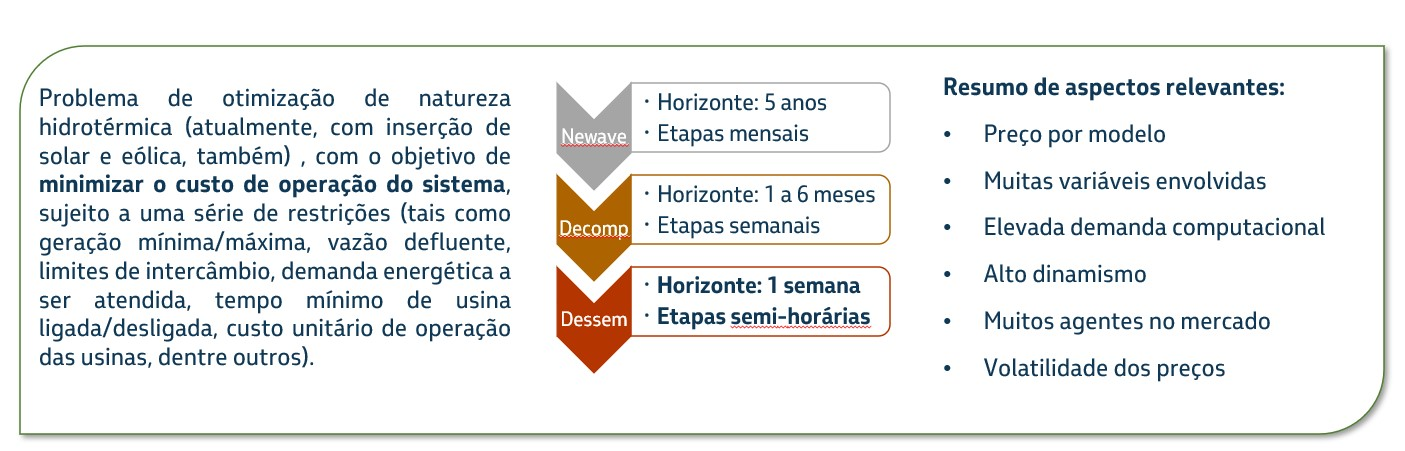

Figura 1 - Resumo do problema de planejamento eletroenergético brasileiro.

> Para a projeção do preço da energia elétrica, uma série de grandezas são utilizadas como entrada. Uma vez que a matriz eletroenergética brasileira é predominantemente hidráulica (e os modelos consideram este aspecto no equacionamento do problema de otimização), a diferença entre as vazões previstas e verificadas dos postos associados às usinas hidroelétricas responde por cerca de 50% das variações no PLD/CMO, conforme ilustrado na Figura 2, disponibilizada pela Câmara de Comercialização de Energia (CCEE). A Energia Armazenada e a Carga também desempenham papel relevante na influência do PLD/CMO. Juntas, as três grandezas respondem por mais de 70% das variações no custo marginal da operação sendo, portanto, as variáveis de interesse na primeira abordagem deste MVP.

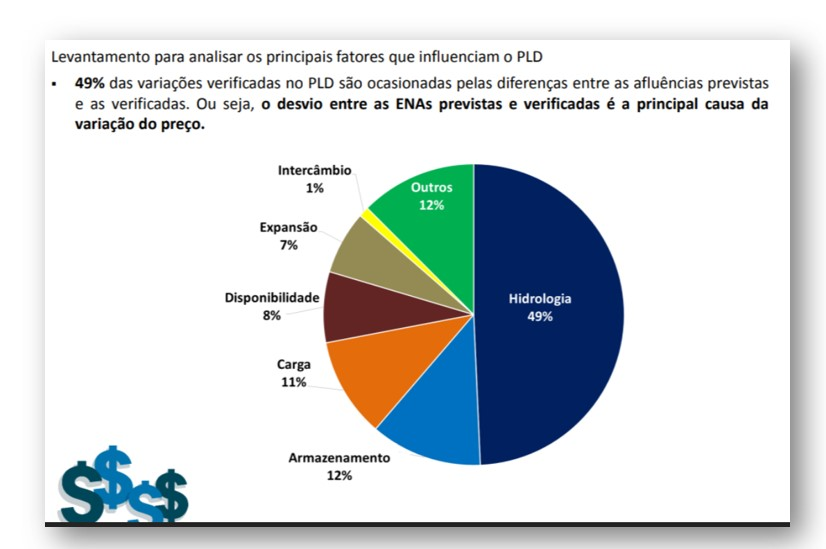

Figura 2 - Variação do PLD/CMO por variável de entrada nos modelos de planejamento eletroenergético do SIN. Fonte: CCEE


> Neste contexto, considerando a atuação na área de Inteligência de Mercado de Gás e Energia em um dos principais agentes geradores do Brasil, faz sentido estruturarmos a coleta e tratamento dos dados referentes às grandezas mencionadas, visando à melhor tomada de decisão sob a ótica da operação do parque e da comercialização e logística do gás e da energia elétrica.





# **Seção I: Obtenção e Tratamento Inicial dos Dados**


1.   [Energia Natural Afluente (ENA) por Subsistema](https://dados.ons.org.br/dataset/ena-diario-por-subsistema)
2.   [Energia Armazenada (EArm) por Subsistema](https://dados.ons.org.br/dataset/ear-diario-por-subsistema)
3.   [Demanda por Subsistema](https://dados.ons.org.br/dataset/carga-energia)
4.   [Custo Marginal da Operação (CMO) Semanal por Subsistema](https://dados.ons.org.br/dataset/cmo-semanal)





> Diariamente, o Operador Nacional do Sistema Elétrico disponibiliza os dados verificados das grandezas supracitadas, para cada um dos 4 subsistemas (Sudeste, Sul, Nordeste e Norte) que compõem eletroenergeticamente o Sistema Interligado Nacional. Para atender ao presente trabalho, estes dados serão tratados, manipulados, pré-processados e avaliados de modo que, em etapas futuras, seja possível aplicar técnicas e algoritmos de Machine Learning a eles, com o objetivo de tentar realizar predições e análises de sensibilidade de Custos Marginais da Operação futuros, por fora dos modelos oficiais.

> Trata-se, portanto, de um problema de Aprendizado Supervisionado, considerando as principais grandezas envolvidas no cálculo do CMO, segundo a Câmara de Comercialização de Energia.



Inicialmente, iremos importar e avaliar (utilizando a biblioteca Pandas, para fazer uma rápida análise exploratória) os dataset de "entrada", variáveis explicativas para a obtenção do CMO: ENA, EArm e Demanda, nesta ordem.

In [305]:
# Primeiro bloco: Importação das bibliotecas e módulos
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")
#
# Importando as bibliotecas pandas, matplotlib (pyplot), seaborn e datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
#
## Transformações Numéricas e ML
from sklearn.preprocessing import MinMaxScaler # para normalização
from sklearn.preprocessing import StandardScaler # para padronização
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import GridSearchCV # para tuning dos hiperparâmetros dos estimadores
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error # métrica de avaliação MSE
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import LogisticRegression # algoritmo Regressão Logística
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM
#
## Para aplicação de métodos ensemble em ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor #Histogram-Based Gradient Boosting: de acordo com a biblioteca do scikitlearn, mais rápido que o GradientBoostingRegressor
#
## Transformações Categóricas
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

## Energia Natural Afluente: ENA

***ENA DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia natural afluente (ENA) dos reservatórios com periodicidade diária por Subsistemas.

A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [306]:
# Seção I.1: Programa para obtenção das Energias Naturais Afluentes - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.
# ENA - Arquivos com os dados anuais, com histórico desde 2001
ano_zero=2001
ano_inicio=ano_zero+1
data_fim=datetime.datetime.now() - datetime.timedelta(days=5) #ano vigente, considerando um possível atraso de até 5 dias na publicação, o que é comum na virada de ano
ano_fim=data_fim.strftime("%Y")
ano_fim=int(ano_fim)
print(data_fim)
print(ano_fim)

2023-07-14 04:19:54.218371
2023


In [307]:
#Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
#Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ena=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
ena=pd.DataFrame(ena)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    ena_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ena_subsistema_di/ENA_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    ena_ano=pd.DataFrame(ena_ano)
    ena=pd.concat([ena,ena_ano])
print(ena)

    id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0               N          NORTE  2001-01-01            10154.000000   
1              NE       NORDESTE  2001-01-01            13472.000000   
2               S            SUL  2001-01-01             7703.000000   
3              SE        SUDESTE  2001-01-01            39186.000000   
4               N          NORTE  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
787            SE        SUDESTE  2023-07-16            23510.095703   
788             N          NORTE  2023-07-17             3790.403076   
789            NE       NORDESTE  2023-07-17             2400.691895   
790             S            SUL  2023-07-17            23886.515625   
791            SE        SUDESTE  2023-07-17            23387.808594   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [308]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
ena.head(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
0             N          NORTE  2001-01-01                 10154.0   
1            NE       NORDESTE  2001-01-01                 13472.0   
2             S            SUL  2001-01-01                  7703.0   
3            SE        SUDESTE  2001-01-01                 39186.0   
4             N          NORTE  2001-01-02                  9590.0   
5            NE       NORDESTE  2001-01-02                 13551.0   
6             S            SUL  2001-01-02                  6730.0   
7            SE        SUDESTE  2001-01-02                 41230.0   
8             N          NORTE  2001-01-03                  9066.0   
9            NE       NORDESTE  2001-01-03                 13551.0   

   ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                      122.339996                        9033.0   
1                      101.480003                       13385.0   
2                      160.910004                        7703.0   
3                       86.980003                       37611.0   
4                      115.550003                        8091.0   
5                      102.080002                       13465.0   
6                      140.580002                        6730.0   
7                       91.519997                       40063.0   
8                      109.239998                        7213.0   
9                      102.080002                       13461.0   

   ena_armazenavel_regiao_percentualmlt  
0                            108.839996  
1                            100.830002  
2                            160.910004  
3                             83.489998  
4                             97.489998  
5                            101.430000  
6                            140.580002  
7                             88.930000  
8                             86.910004  
9                            101.400002

In [309]:
# Conferindo as últimas 10 linhas
ena.tail(10)

id_subsistema nom_subsistema    ena_data  ena_bruta_regiao_mwmed  \
782             S            SUL  2023-07-15            37106.445312   
783            SE        SUDESTE  2023-07-15            23730.769531   
784             N          NORTE  2023-07-16             3881.238037   
785            NE       NORDESTE  2023-07-16             2425.052979   
786             S            SUL  2023-07-16            29043.859375   
787            SE        SUDESTE  2023-07-16            23510.095703   
788             N          NORTE  2023-07-17             3790.403076   
789            NE       NORDESTE  2023-07-17             2400.691895   
790             S            SUL  2023-07-17            23886.515625   
791            SE        SUDESTE  2023-07-17            23387.808594   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
782                      339.372101                  16259.193359   
783                       92.536598                  23232.585938   
784                       73.776703                   3768.150879   
785                       64.239403                   2402.173096   
786                      265.632507                   9325.972656   
787                       91.676102                  22996.693359   
788                       72.050102                   3691.900879   
789                       63.594002                   2379.241943   
790                      218.463898                  12383.575195   
791                       91.199203                  23229.300781   

     ena_armazenavel_regiao_percentualmlt  
782                            148.705093  
783                             90.594002  
784                             71.627098  
785                             63.633301  
786                             85.294502  
787                             89.674103  
788                             70.177696  
789                             63.025799  
790                            113.259003  
791                             90.581100

In [310]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(ena)/4

8233.0

In [311]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                            object
nom_subsistema                           object
ena_data                                 object
ena_bruta_regiao_mwmed                  float64
ena_bruta_regiao_percentualmlt          float64
ena_armazenavel_regiao_mwmed            float64
ena_armazenavel_regiao_percentualmlt    float64
dtype: object

In [312]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
ena['nom_subsistema']=ena['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [313]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
ena=ena.rename(columns = {'ena_data':'Data'})
print(ena)

    id_subsistema nom_subsistema        Data  ena_bruta_regiao_mwmed  \
0               N          Norte  2001-01-01            10154.000000   
1              NE       Nordeste  2001-01-01            13472.000000   
2               S            Sul  2001-01-01             7703.000000   
3              SE        Sudeste  2001-01-01            39186.000000   
4               N          Norte  2001-01-02             9590.000000   
..            ...            ...         ...                     ...   
787            SE        Sudeste  2023-07-16            23510.095703   
788             N          Norte  2023-07-17             3790.403076   
789            NE       Nordeste  2023-07-17             2400.691895   
790             S            Sul  2023-07-17            23886.515625   
791            SE        Sudeste  2023-07-17            23387.808594   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                        122.339996                   9033.000000 

In [314]:
# Alterando o tipo da coluna "Data"
ena['Data'] = pd.to_datetime(ena['Data'])

In [315]:
# Verificando os tipos de coluna do dataframe ena
ena.dtypes

id_subsistema                                   object
nom_subsistema                                  object
Data                                    datetime64[ns]
ena_bruta_regiao_mwmed                         float64
ena_bruta_regiao_percentualmlt                 float64
ena_armazenavel_regiao_mwmed                   float64
ena_armazenavel_regiao_percentualmlt           float64
dtype: object

In [316]:
# Reordenando o dataframe ena, pela coluna Data (em ordem decrescente)
ena=ena.sort_values(by='Data', ascending=False)
ena.head(20)

id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
791            SE        Sudeste 2023-07-17            23387.808594   
790             S            Sul 2023-07-17            23886.515625   
789            NE       Nordeste 2023-07-17             2400.691895   
788             N          Norte 2023-07-17             3790.403076   
787            SE        Sudeste 2023-07-16            23510.095703   
786             S            Sul 2023-07-16            29043.859375   
785            NE       Nordeste 2023-07-16             2425.052979   
784             N          Norte 2023-07-16             3881.238037   
781            NE       Nordeste 2023-07-15             2460.394043   
780             N          Norte 2023-07-15             4006.822021   
783            SE        Sudeste 2023-07-15            23730.769531   
782             S            Sul 2023-07-15            37106.445312   
779            SE        Sudeste 2023-07-14            23873.740234   
778             S            Sul 2023-07-14            46777.171875   
777            NE       Nordeste 2023-07-14             2472.462891   
776             N          Norte 2023-07-14             4079.535889   
773            NE       Nordeste 2023-07-13             2462.040039   
772             N          Norte 2023-07-13             4130.795898   
775            SE        Sudeste 2023-07-13            23976.847656   
774             S            Sul 2023-07-13            52554.441406   

     ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
791                       91.199203                  23229.300781   
790                      218.463898                  12383.575195   
789                       63.594002                   2379.241943   
788                       72.050102                   3691.900879   
787                       91.676102                  22996.693359   
786                      265.632507                   9325.972656   
785                       64.239403                   2402.173096   
784                       73.776703                   3768.150879   
781                       65.175499                   2423.740967   
780                       76.163902                   3847.044922   
783                       92.536598                  23232.585938   
782                      339.372101                  16259.193359   
779                       93.094101                  23757.843750   
778                      427.819702                  22166.828125   
777                       65.495201                   2472.462891   
776                       77.546097                   3899.908936   
773                       65.219101                   2442.735107   
772                       78.520500                   4011.274902   
775                       93.496201                  23695.212891   
774                      480.658112                  10852.024414   

     ena_armazenavel_regiao_percentualmlt  
791                             90.581100  
790                            113.259003  
789                             63.025799  
788                             70.177696  
787                             89.674103  
786                             85.294502  
785                             63.633301  
784                             71.627098  
781                             64.204597  
780                             73.126801  
783                             90.594002  
782                            148.705093  
779                             92.642197  
778                            202.735794  
777                             65.495201  
776                             74.131599  
773                             64.707802  
772                             76.248596  
775                             92.397903  
774                             99.251602

## Energia Armazenada: EArm

***EAR DIÁRIO POR SUBSISTEMA*** (Segundo o ONS)

Dados das grandezas de energia armazenada (EAR) em periodicidade diária por Subsistemas.

A Energia Armazenada (EAR) representa a energia associada ao volume de água disponível nos reservatórios que pode ser convertido em geração na própria usina e em todas as usinas à jusante na cascata. A grandeza de EAR leva em conta nível verificado nos reservatórios na data de referência. A grandeza de EAR máxima representa a capacidade de armazenamento caso todos os reservatórios do sistema estivessem cheios. A grandeza de EAR para o subsistema à jusante considera a utilização da água do reservatório para produzir energia em uma usina à jusante que está em um subsistema diferente.

Como esses dados podem ser utilizados: os dados podem servir de insumo para estudos energéticos e projeção do custo marginal de operação. Contudo, saiba que os dados disponibilizados fazem parte de um processo de consistência recorrente e, portanto, podem ser atualizados após a sua publicação.

In [317]:
# Seção I.2: Programa para obtenção das Energias Armazenadas - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# EArm - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
earm=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
earm=pd.DataFrame(earm)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    earm_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/ear_subsistema_di/EAR_DIARIO_SUBSISTEMA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    earm_ano=pd.DataFrame(earm_ano)
    earm=pd.concat([earm,earm_ano])
print (earm)

    id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0              NE       NORDESTE  2001-01-01        49967.000000   
1               N          NORTE  2001-01-01        12311.000000   
2              SE        SUDESTE  2001-01-01       159081.000000   
3               S            SUL  2001-01-01        14176.000000   
4              NE       NORDESTE  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
787             S            SUL  2023-07-16        20459.242188   
788            NE       NORDESTE  2023-07-17        51691.226562   
789             N          NORTE  2023-07-17        15302.396484   
790            SE        SUDESTE  2023-07-17       204615.328125   
791             S            SUL  2023-07-17        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [318]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
earm.head(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
0            NE       NORDESTE  2001-01-01             49967.0   
1             N          NORTE  2001-01-01             12311.0   
2            SE        SUDESTE  2001-01-01            159081.0   
3             S            SUL  2001-01-01             14176.0   
4            NE       NORDESTE  2001-01-02             49967.0   
5             N          NORTE  2001-01-02             12311.0   
6            SE        SUDESTE  2001-01-02            159081.0   
7             S            SUL  2001-01-02             14176.0   
8            NE       NORDESTE  2001-01-03             49967.0   
9             N          NORTE  2001-01-03             12311.0   

   ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                     18699.0                        37.419998  
1                      9137.0                        74.220001  
2                     46315.0                        29.110001  
3                     12857.0                        90.690002  
4                     18851.0                        37.730000  
5                      9327.0                        75.760002  
6                     46850.0                        29.450001  
7                     12920.0                        91.139999  
8                     19047.0                        38.119999  
9                      9453.0                        76.779999

In [319]:
# Conferindo as últimas 10 linhas
earm.tail(10)

id_subsistema nom_subsistema    ear_data  ear_max_subsistema  \
782            SE        SUDESTE  2023-07-15       204615.328125   
783             S            SUL  2023-07-15        20459.242188   
784            NE       NORDESTE  2023-07-16        51691.226562   
785             N          NORTE  2023-07-16        15302.396484   
786            SE        SUDESTE  2023-07-16       204615.328125   
787             S            SUL  2023-07-16        20459.242188   
788            NE       NORDESTE  2023-07-17        51691.226562   
789             N          NORTE  2023-07-17        15302.396484   
790            SE        SUDESTE  2023-07-17       204615.328125   
791             S            SUL  2023-07-17        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
782               174955.093750                        85.504402  
783                18701.484375                        91.408501  
784                42321.871094                        81.874397  
785                14521.419922                        94.896400  
786               174927.812500                        85.491096  
787                18742.306641                        91.608002  
788                42231.656250                        81.699898  
789                14492.754883                        94.709099  
790               174781.031250                        85.419296  
791                18768.328125                        91.735199

In [320]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(earm)/4

8233.0

In [321]:
# Verificando os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                       object
nom_subsistema                      object
ear_data                            object
ear_max_subsistema                 float64
ear_verif_subsistema_mwmes         float64
ear_verif_subsistema_percentual    float64
dtype: object

In [322]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
earm['nom_subsistema']=earm['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [323]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
earm=earm.rename(columns = {'ear_data':'Data'})
print(earm)

    id_subsistema nom_subsistema        Data  ear_max_subsistema  \
0              NE       Nordeste  2001-01-01        49967.000000   
1               N          Norte  2001-01-01        12311.000000   
2              SE        Sudeste  2001-01-01       159081.000000   
3               S            Sul  2001-01-01        14176.000000   
4              NE       Nordeste  2001-01-02        49967.000000   
..            ...            ...         ...                 ...   
787             S            Sul  2023-07-16        20459.242188   
788            NE       Nordeste  2023-07-17        51691.226562   
789             N          Norte  2023-07-17        15302.396484   
790            SE        Sudeste  2023-07-17       204615.328125   
791             S            Sul  2023-07-17        20459.242188   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
0                  18699.000000                        37.419998  
1                   9137.000000                  

In [324]:
# Alterando o tipo da coluna "Data"
earm['Data'] = pd.to_datetime(earm['Data'])

In [325]:
# Verificando novamente os tipos de coluna do dataframe earm
earm.dtypes

id_subsistema                              object
nom_subsistema                             object
Data                               datetime64[ns]
ear_max_subsistema                        float64
ear_verif_subsistema_mwmes                float64
ear_verif_subsistema_percentual           float64
dtype: object

In [326]:
# Reordenando o dataframe earm, pela coluna Data (em ordem decrescente)
earm=earm.sort_values(by='Data', ascending=False)
earm.head(20)

id_subsistema nom_subsistema       Data  ear_max_subsistema  \
791             S            Sul 2023-07-17        20459.242188   
790            SE        Sudeste 2023-07-17       204615.328125   
789             N          Norte 2023-07-17        15302.396484   
788            NE       Nordeste 2023-07-17        51691.226562   
787             S            Sul 2023-07-16        20459.242188   
786            SE        Sudeste 2023-07-16       204615.328125   
785             N          Norte 2023-07-16        15302.396484   
784            NE       Nordeste 2023-07-16        51691.226562   
781             N          Norte 2023-07-15        15302.396484   
780            NE       Nordeste 2023-07-15        51691.226562   
783             S            Sul 2023-07-15        20459.242188   
782            SE        Sudeste 2023-07-15       204615.328125   
779             S            Sul 2023-07-14        20459.242188   
778            SE        Sudeste 2023-07-14       204615.328125   
777             N          Norte 2023-07-14        15302.396484   
776            NE       Nordeste 2023-07-14        51691.226562   
773             N          Norte 2023-07-13        15302.396484   
772            NE       Nordeste 2023-07-13        51691.226562   
775             S            Sul 2023-07-13        20459.242188   
774            SE        Sudeste 2023-07-13       204615.328125   

     ear_verif_subsistema_mwmes  ear_verif_subsistema_percentual  
791                18768.328125                        91.735199  
790               174781.031250                        85.419296  
789                14492.754883                        94.709099  
788                42231.656250                        81.699898  
787                18742.306641                        91.608002  
786               174927.812500                        85.491096  
785                14521.419922                        94.896400  
784                42321.871094                        81.874397  
781                14536.443359                        94.994598  
780                42399.777344                        82.025101  
783                18701.484375                        91.408501  
782               174955.093750                        85.504402  
779                18640.298828                        91.109398  
778               174957.484375                        85.505600  
777                14545.019531                        95.050598  
776                42491.988281                        82.203499  
773                14577.323242                        95.261703  
772                42577.203125                        82.368301  
775                18524.369141                        90.542801  
774               175063.187500                        85.557198

## Carga (Demanda) Eletroenergética

***CARGA DE ENERGIA DIÁRIA*** (Segundo o ONS)

Dados de carga por subsistema em base diária, medida em MWmed.

Até fevereiro/2021, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS. Entre março/2021 e abril/23, os dados representam a carga atendida por usinas despachadas e/ou programadas pelo ONS, com base em dados recebidos pelo Sistema de Supervisão e Controle do ONS, mais a previsão de geração de usinas não despachadas pelo ONS. A partir de 29/04/2023, além dos dados anteriormente considerados, passou a ser incorporado o valor estimado da micro e minigeração distribuída (MMGD), com base em dados meteorológicos previstos.

In [327]:
# Seção I.3: Programa para obtenção da Carga Elétrica - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# Carga - Arquivos com os dados anuais, com histórico desde 2001.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas)
# Importando os dados da url para o dataframe, começando pelo ano inicial do histórico, até o ano vigente
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
carga=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+str(ano_zero)+".csv",delimiter=";",encoding = 'utf8')
carga=pd.DataFrame(carga)
for ano in range (ano_inicio,ano_fim+1):
    ano_str=str(ano)
    carga_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/carga_energia_di/CARGA_ENERGIA_"+ano_str+".csv",delimiter=";",encoding = 'utf8')
    carga_ano=pd.DataFrame(carga_ano)
    carga=pd.concat([carga,carga_ano])
print(carga)

    id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0               N                 Norte   2001-01-01            2376.731250
1              NE              Nordeste   2001-01-01            5035.816667
2               S                   Sul   2001-01-01            4925.373750
3              SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4               N                 Norte   2001-01-02            2537.383333
..            ...                   ...          ...                    ...
787            SE  Sudeste/Centro-Oeste   2023-07-16           33531.759500
788             N                 Norte   2023-07-17            7348.445958
789            NE              Nordeste   2023-07-17           11932.388042
790             S                   Sul   2023-07-17           11791.289262
791            SE  Sudeste/Centro-Oeste   2023-07-17           39555.550042

[32933 rows x 4 columns]


In [328]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
carga.head(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
0             N                 Norte   2001-01-01            2376.731250
1            NE              Nordeste   2001-01-01            5035.816667
2             S                   Sul   2001-01-01            4925.373750
3            SE  Sudeste/Centro-Oeste   2001-01-01           19729.233333
4             N                 Norte   2001-01-02            2537.383333
5            NE              Nordeste   2001-01-02            5946.387500
6             S                   Sul   2001-01-02            6779.687500
7            SE  Sudeste/Centro-Oeste   2001-01-02           24596.195417
8             N                 Norte   2001-01-03            2540.345833
9            NE              Nordeste   2001-01-03            6188.104167

In [329]:
# Conferindo as últimas 10 linhas
carga.tail(10)

id_subsistema        nom_subsistema din_instante  val_cargaenergiamwmed
782             S                   Sul   2023-07-15           10013.116333
783            SE  Sudeste/Centro-Oeste   2023-07-15           35918.580917
784             N                 Norte   2023-07-16            6787.679792
785            NE              Nordeste   2023-07-16           10689.597292
786             S                   Sul   2023-07-16            8588.719583
787            SE  Sudeste/Centro-Oeste   2023-07-16           33531.759500
788             N                 Norte   2023-07-17            7348.445958
789            NE              Nordeste   2023-07-17           11932.388042
790             S                   Sul   2023-07-17           11791.289262
791            SE  Sudeste/Centro-Oeste   2023-07-17           39555.550042

In [330]:
# Conferindo a quantidade de dias (considerando 4 subsistemas)
len(carga)/4

8233.25

In [331]:
carga_null=(carga['val_cargaenergiamwmed'].isnull() == True)
carganull=carga.loc[carga_null]
print(carganull)

     id_subsistema        nom_subsistema         din_instante  \
132              S                   Sul  2013-02-02 00:00:01   
1337             N                 Norte  2013-12-01 00:00:00   
1338            NE              Nordeste  2013-12-01 00:00:00   
1339             S                   Sul  2013-12-01 00:00:00   
1340            SE  Sudeste/Centro-Oeste  2013-12-01 00:00:00   
124              N                 Norte           2014-02-01   
125             NE              Nordeste           2014-02-01   
126              S                   Sul           2014-02-01   
127             SE  Sudeste/Centro-Oeste           2014-02-01   
392              N                 Norte           2015-04-09   
393             NE              Nordeste           2015-04-09   
394              S                   Sul           2015-04-09   
395             SE  Sudeste/Centro-Oeste           2015-04-09   
380              N                 Norte           2016-04-05   
381             NE       

Constata-se, pela quantidade de dias, que o dataframe "carga" tem uma linha a mais que os dataframes "ena" e "earm". Ao mesclarmos as consultas, desejaremos excluir essa linha a mais.

In [332]:
# Verificando os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema             object
nom_subsistema            object
din_instante              object
val_cargaenergiamwmed    float64
dtype: object

In [333]:
# Iniciando o tratamento dos dados
# Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
carga['nom_subsistema']=carga['nom_subsistema'].replace({'Sudeste/Centro-Oeste':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [334]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
carga=carga.rename(columns = {'din_instante':'Data'})
print(carga)

    id_subsistema nom_subsistema        Data  val_cargaenergiamwmed
0               N          Norte  2001-01-01            2376.731250
1              NE       Nordeste  2001-01-01            5035.816667
2               S            Sul  2001-01-01            4925.373750
3              SE        Sudeste  2001-01-01           19729.233333
4               N          Norte  2001-01-02            2537.383333
..            ...            ...         ...                    ...
787            SE        Sudeste  2023-07-16           33531.759500
788             N          Norte  2023-07-17            7348.445958
789            NE       Nordeste  2023-07-17           11932.388042
790             S            Sul  2023-07-17           11791.289262
791            SE        Sudeste  2023-07-17           39555.550042

[32933 rows x 4 columns]


In [335]:
# Alterando o tipo da coluna "Data"
carga['Data'] = pd.to_datetime(carga['Data'])

In [336]:
# Verificando novamente os tipos de coluna do dataframe carga
carga.dtypes

id_subsistema                    object
nom_subsistema                   object
Data                     datetime64[ns]
val_cargaenergiamwmed           float64
dtype: object

In [337]:
# Reordenando o dataframe carga, pela coluna Data (em ordem decrescente)
carga=carga.sort_values(by='Data', ascending=False)
carga.head(20)

id_subsistema nom_subsistema       Data  val_cargaenergiamwmed
791            SE        Sudeste 2023-07-17           39555.550042
790             S            Sul 2023-07-17           11791.289262
789            NE       Nordeste 2023-07-17           11932.388042
788             N          Norte 2023-07-17            7348.445958
787            SE        Sudeste 2023-07-16           33531.759500
786             S            Sul 2023-07-16            8588.719583
785            NE       Nordeste 2023-07-16           10689.597292
784             N          Norte 2023-07-16            6787.679792
781            NE       Nordeste 2023-07-15           11621.188167
780             N          Norte 2023-07-15            7070.928375
783            SE        Sudeste 2023-07-15           35918.580917
782             S            Sul 2023-07-15           10013.116333
779            SE        Sudeste 2023-07-14           39799.319708
778             S            Sul 2023-07-14           11964.354500
777            NE       Nordeste 2023-07-14           12017.206125
776             N          Norte 2023-07-14            7354.199292
773            NE       Nordeste 2023-07-13           11927.956833
772             N          Norte 2023-07-13            7362.410500
775            SE        Sudeste 2023-07-13           41440.380458
774             S            Sul 2023-07-13           12161.337542

## Custo Marginal da Operação (CMO)

***CUSTO MARGINAL DA OPERAÇÃO*** (Segundo o ONS)

Valores do custo, por unidade de energia produzida, para atender ao incremento de uma unidade de carga no SIN, chamado de Custo Marginal de Operação – CMO. Valores para cada semana operativa por subsistema, e por patamar de carga, além da média semanal, estimados pelo modelo Decomp.

> Considerações sobre o Custo Marginal da Operação: Até 2020, o cálculo do CMO era realizado por patamar de carga (pesada, média ou leve): um único valor para cada patamar dentro da semana operativa (iniciada no sábado até a sexta-feira seguinte).  A distribuição das horas pelos patamares de carga varia de acordo com o dia da semana (se é útil ou não) e com o mês (se verão, inverno ou "intermediário"). A partir de 2020, o CMO passou a ser calculado com granularidade horária. No entanto, considerando o histórico dos últimos 3 anos, poucas foram as vezes em que houve um descolamento significativo entre o custo horário e o custo semanal. Por este motivo, para este trabalho (e para as etapas futuras), será considerado o CMO semanal, para todo o horizonte disponível.




In [338]:
# Seção I.4: Programa para obtenção do Custo Marginal da Operação - Dados Abertos Operador Nacional do Sistema Elétrico
# Dados por subsistema do Sistema Interligado Nacional, atualizados diariamente.

# CMO - Arquivos com os dados anuais, com histórico desde 2005.
# Portanto, serão utilizados os mesmos parâmetros temporais base (que das demais grandezas), à exceção do ano zero/de início
# Ao contrário das demais grandezas, os valores de CMO ora importados são semanais, vigorando do sábado à sexta-feira da semana operativa.
# Conforme dicionário de dados disponibilizado na página de Arquitetura Aberta do ONS, os arquivos .csv estão no formato UTF-8, com delimitador do tipo ponto-e-vírgula
ano_zerocmo=2005
ano_iniciocmo=ano_zerocmo+1
cmo=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+str(ano_zerocmo)+".csv", delimiter=";",encoding = 'utf8')
cmo=pd.DataFrame(cmo)
for ano in range (ano_iniciocmo,ano_fim+1):
    ano_str=str(ano)
    cmo_ano=pd.read_csv("https://ons-dl-prod-opendata.s3.amazonaws.com/dataset/cmo_se/CMO_SEMANAL_"+ano_str+".csv", delimiter=";", encoding = 'utf8')
    cmo_ano=pd.DataFrame(cmo_ano)
    cmo=pd.concat([cmo,cmo_ano])
print(cmo)

    id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
0               N          NORTE   2005-01-07                 0.94   
1              NE       NORDESTE   2005-01-07                 0.94   
2               S            SUL   2005-01-07                 4.50   
3              SE        SUDESTE   2005-01-07                 0.00   
4               N          NORTE   2005-01-14                 6.34   
..            ...            ...          ...                  ...   
111            SE        SUDESTE   2023-07-14                 0.00   
112             N          NORTE   2023-07-21                 0.00   
113            NE       NORDESTE   2023-07-21                 0.00   
114             S            SUL   2023-07-21                 0.00   
115            SE        SUDESTE   2023-07-21                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.3

In [339]:
# Conferindo as primeiras 10 linhas, para check da importação de dados
cmo.head(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  val_cmoleve  \
0             N          NORTE   2005-01-07                 0.94         0.94   
1            NE       NORDESTE   2005-01-07                 0.94         0.94   
2             S            SUL   2005-01-07                 4.50         4.39   
3            SE        SUDESTE   2005-01-07                 0.00         0.00   
4             N          NORTE   2005-01-14                 6.34         5.87   
5            NE       NORDESTE   2005-01-14                 7.64         7.64   
6             S            SUL   2005-01-14                12.32        12.11   
7            SE        SUDESTE   2005-01-14                 6.34         5.87   
8             N          NORTE   2005-01-21                 0.82         0.83   
9            NE       NORDESTE   2005-01-21                 0.69         0.69   

   val_cmomedia  val_cmopesada  
0          0.94           0.94  
1          0.94           0.94  
2          4.59           4.59  
3          0.00           0.00  
4          6.41           7.64  
5          7.64           7.64  
6         12.44          12.44  
7          6.41           7.64  
8          0.79           0.93  
9          0.69           0.69

In [340]:
# Conferindo as últimas 10 linhas
cmo.tail(10)

id_subsistema nom_subsistema din_instante  val_cmomediasemanal  \
106             S            SUL   2023-07-07                  0.0   
107            SE        SUDESTE   2023-07-07                  0.0   
108             N          NORTE   2023-07-14                  0.0   
109            NE       NORDESTE   2023-07-14                  0.0   
110             S            SUL   2023-07-14                  0.0   
111            SE        SUDESTE   2023-07-14                  0.0   
112             N          NORTE   2023-07-21                  0.0   
113            NE       NORDESTE   2023-07-21                  0.0   
114             S            SUL   2023-07-21                  0.0   
115            SE        SUDESTE   2023-07-21                  0.0   

     val_cmoleve  val_cmomedia  val_cmopesada  
106          0.0           0.0            0.0  
107          0.0           0.0            0.0  
108          0.0           0.0            0.0  
109          0.0           0.0            0.0  
110          0.0           0.0            0.0  
111          0.0           0.0            0.0  
112          0.0           0.0            0.0  
113          0.0           0.0            0.0  
114          0.0           0.0            0.0  
115          0.0           0.0            0.0

In [341]:
# Iniciando o tratamento dos dados
#Convertendo os nomes dos subsistemas para 1ª letra em maiúscula: SE->Sudeste; S->Sul; NE->Nordeste; N->Norte
cmo['nom_subsistema']=cmo['nom_subsistema'].replace({'SUDESTE':'Sudeste',
                                                'SUL':'Sul',
                                                'NORDESTE':'Nordeste',
                                                'NORTE':'Norte'})

In [342]:
# Renomeando a coluna de data, de modo a ser o mesmo nome em todos os DataFrames, para facilitar a chave de mesclagem
cmo=cmo.rename(columns = {'din_instante':'Data'})
print(cmo)

    id_subsistema nom_subsistema        Data  val_cmomediasemanal  \
0               N          Norte  2005-01-07                 0.94   
1              NE       Nordeste  2005-01-07                 0.94   
2               S            Sul  2005-01-07                 4.50   
3              SE        Sudeste  2005-01-07                 0.00   
4               N          Norte  2005-01-14                 6.34   
..            ...            ...         ...                  ...   
111            SE        Sudeste  2023-07-14                 0.00   
112             N          Norte  2023-07-21                 0.00   
113            NE       Nordeste  2023-07-21                 0.00   
114             S            Sul  2023-07-21                 0.00   
115            SE        Sudeste  2023-07-21                 0.00   

     val_cmoleve  val_cmomedia  val_cmopesada  
0           0.94          0.94           0.94  
1           0.94          0.94           0.94  
2           4.39          4

In [343]:
# Verificando novamente os tipos de coluna do dataframe cmo
cmo.dtypes

id_subsistema           object
nom_subsistema          object
Data                    object
val_cmomediasemanal    float64
val_cmoleve            float64
val_cmomedia           float64
val_cmopesada          float64
dtype: object

In [344]:
# Alterando o tipo da coluna "Data"
cmo['Data'] = pd.to_datetime(cmo['Data'])

In [345]:
# Reordenando o dataframe cmo, pela coluna Data (em ordem decrescente)
cmo=cmo.sort_values(by='Data', ascending=False)
cmo.head(20)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
115            SE        Sudeste 2023-07-21                  0.0          0.0   
114             S            Sul 2023-07-21                  0.0          0.0   
113            NE       Nordeste 2023-07-21                  0.0          0.0   
112             N          Norte 2023-07-21                  0.0          0.0   
111            SE        Sudeste 2023-07-14                  0.0          0.0   
110             S            Sul 2023-07-14                  0.0          0.0   
109            NE       Nordeste 2023-07-14                  0.0          0.0   
108             N          Norte 2023-07-14                  0.0          0.0   
107            SE        Sudeste 2023-07-07                  0.0          0.0   
106             S            Sul 2023-07-07                  0.0          0.0   
105            NE       Nordeste 2023-07-07                  0.0          0.0   
104             N          Norte 2023-07-07                  0.0          0.0   
102             S            Sul 2023-06-30                  0.0          0.0   
100             N          Norte 2023-06-30                  0.0          0.0   
101            NE       Nordeste 2023-06-30                  0.0          0.0   
103            SE        Sudeste 2023-06-30                  0.0          0.0   
99             SE        Sudeste 2023-06-23                  0.0          0.0   
98              S            Sul 2023-06-23                  0.0          0.0   
97             NE       Nordeste 2023-06-23                  0.0          0.0   
96              N          Norte 2023-06-23                  0.0          0.0   

     val_cmomedia  val_cmopesada  
115           0.0            0.0  
114           0.0            0.0  
113           0.0            0.0  
112           0.0            0.0  
111           0.0            0.0  
110           0.0            0.0  
109           0.0            0.0  
108           0.0            0.0  
107           0.0            0.0  
106           0.0            0.0  
105           0.0            0.0  
104           0.0            0.0  
102           0.0            0.0  
100           0.0            0.0  
101           0.0            0.0  
103           0.0            0.0  
99            0.0            0.0  
98            0.0            0.0  
97            0.0            0.0  
96            0.0            0.0

In [346]:
cmo=cmo.assign(Diferenca=0)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
115            SE        Sudeste 2023-07-21                 0.00         0.00   
114             S            Sul 2023-07-21                 0.00         0.00   
113            NE       Nordeste 2023-07-21                 0.00         0.00   
112             N          Norte 2023-07-21                 0.00         0.00   
111            SE        Sudeste 2023-07-14                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [347]:
cmo.dtypes

id_subsistema                  object
nom_subsistema                 object
Data                   datetime64[ns]
val_cmomediasemanal           float64
val_cmoleve                   float64
val_cmomedia                  float64
val_cmopesada                 float64
Diferenca                       int64
dtype: object

In [348]:
# Estabelecendo os valores para a coluna "Razao" (= CMO_Pesada - CMO_Leve)
comp_cmo=len(cmo)
for i in range(1,comp_cmo):
    cmo['Razao']=(cmo['val_cmopesada']-cmo['val_cmoleve'])/cmo['val_cmopesada']
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
115            SE        Sudeste 2023-07-21                 0.00         0.00   
114             S            Sul 2023-07-21                 0.00         0.00   
113            NE       Nordeste 2023-07-21                 0.00         0.00   
112             N          Norte 2023-07-21                 0.00         0.00   
111            SE        Sudeste 2023-07-14                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-14                 6.34         5.87   
2               S            Sul 2005-01-07                 4.50         4.39   
1              NE       Nordeste 2005-01-07                 0.94         0.94   
3              SE        Sudeste 2005-01-07                 0.00         0.00   
0               N          Norte 2005-01-07                 0.94         0.94   

     val_cmomedia  val_cmop

In [349]:
# Substituindo os valores 'NaN' por '0', reordenando pela coluna Razao e avaliando os 500 resultados mais altos
cmo=cmo.fillna(0)
cmo=cmo.sort_values(by='Razao', ascending=False)
cmo.head(500)

id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
146             S            Sul 2005-09-16                18.89         0.00   
67             SE        Sudeste 2008-04-25                25.95         0.00   
26              S            Sul 2007-02-16                 2.67         0.00   
202             S            Sul 2015-12-18                61.10         0.00   
202             S            Sul 2005-12-23                 1.98         0.00   
..            ...            ...        ...                  ...          ...   
204             N          Norte 2012-12-28               318.85       315.89   
205            NE       Nordeste 2012-12-28               318.85       315.89   
69             NE       Nordeste 2018-05-04               148.13       139.83   
19             SE        Sudeste 2018-02-02               157.33       147.51   
73             NE       Nordeste 2016-05-06               110.05       103.20   

     val_cmomedia  val_cmopesada  Diferenca     Razao  
146         29.56          30.10          0  1.000000  
67          45.50          48.02          0  1.000000  
26           4.20           4.20          0  1.000000  
202         95.93          95.93          0  1.000000  
202          3.11           3.11          0  1.000000  
..            ...            ...        ...       ...  
204        315.89         349.09          0  0.095104  
205        315.89         349.09          0  0.095104  
69         154.51         154.51          0  0.095010  
19         162.93         162.93          0  0.094642  
73         113.95         113.95          0  0.094340  

[500 rows x 9 columns]



> Como pode ser observado, os dados de CMO semanal são disponibilizados para datas de sextas-feiras (último dia de cada semana operativa). Vamos alterar essa data para o sábado anterior (início da semana operativa). Além disso, constata-se que em aproximadamente 500 semanas da amostra (desde 2005 até abril/23) o CMO correspondente aos patamares de carga leve foram pelo menos 10% menores que o CMO de carga pesada.



In [350]:
# Alterando a data (sexta-feira) para o sábado anterior
cmo['Data']=cmo['Data']-datetime.timedelta(days=6)
cmo=cmo.sort_values(by='Data', ascending=False)
print(cmo)

    id_subsistema nom_subsistema       Data  val_cmomediasemanal  val_cmoleve  \
112             N          Norte 2023-07-15                 0.00         0.00   
113            NE       Nordeste 2023-07-15                 0.00         0.00   
115            SE        Sudeste 2023-07-15                 0.00         0.00   
114             S            Sul 2023-07-15                 0.00         0.00   
108             N          Norte 2023-07-08                 0.00         0.00   
..            ...            ...        ...                  ...          ...   
7              SE        Sudeste 2005-01-08                 6.34         5.87   
2               S            Sul 2005-01-01                 4.50         4.39   
3              SE        Sudeste 2005-01-01                 0.00         0.00   
1              NE       Nordeste 2005-01-01                 0.94         0.94   
0               N          Norte 2005-01-01                 0.94         0.94   

     val_cmomedia  val_cmop

# **Seção II: Mesclagem dos dados de ENA, EArm, Carga e CMO em uma consulta única**

> Uma vez que o ONS disponibiliza os dados em bases distintas e, em etapas futuras, pretendemos utilizar este *dataset* para predição de Custos Marginais da Operação futuros por meio de técnicas de Inteligência Artificial, vamos unificar os dados de ENA, EArm, Carga e CMO em um DataFrame único, utilizando como colunas em comum aquelas referentes às datas e aos nomes dos subsistemas. Além disso, desprezaremos as colunas com "id" dos subsistemas.



In [351]:
# Seção II.1: Mesclagem das consultas de ENA e EArm
ena_earm=pd.merge(ena, earm, how="left")
print(ena_earm)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-17            23387.808594   
1                 S            Sul 2023-07-17            23886.515625   
2                NE       Nordeste 2023-07-17             2400.691895   
3                 N          Norte 2023-07-17             3790.403076   
4                SE        Sudeste 2023-07-16            23510.095703   
...             ...            ...        ...                     ...   
32927            SE        Sudeste 2001-01-02            41230.000000   
32928             S            Sul 2001-01-01             7703.000000   
32929            NE       Nordeste 2001-01-01            13472.000000   
32930            SE        Sudeste 2001-01-01            39186.000000   
32931             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.199203               

In [352]:
# Seção II.2: Mesclagem das consultas de ENA e EArm com a carga
dados=pd.merge(ena_earm, carga, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-17            23387.808594   
1                 S            Sul 2023-07-17            23886.515625   
2                NE       Nordeste 2023-07-17             2400.691895   
3                 N          Norte 2023-07-17             3790.403076   
4                SE        Sudeste 2023-07-16            23510.095703   
...             ...            ...        ...                     ...   
32927            SE        Sudeste 2001-01-02            41230.000000   
32928             S            Sul 2001-01-01             7703.000000   
32929            NE       Nordeste 2001-01-01            13472.000000   
32930            SE        Sudeste 2001-01-01            39186.000000   
32931             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.199203               

In [353]:
# Mesclando o dataset "dados" com o dataset "cmo", utilizando as colunas "Data" e "nom_subsistema" como chaves
dados=pd.merge(dados, cmo, how="left")
print(dados)

      id_subsistema nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0                SE        Sudeste 2023-07-17            23387.808594   
1                 S            Sul 2023-07-17            23886.515625   
2                NE       Nordeste 2023-07-17             2400.691895   
3                 N          Norte 2023-07-17             3790.403076   
4                SE        Sudeste 2023-07-16            23510.095703   
...             ...            ...        ...                     ...   
32927            SE        Sudeste 2001-01-02            41230.000000   
32928             S            Sul 2001-01-01             7703.000000   
32929            NE       Nordeste 2001-01-01            13472.000000   
32930            SE        Sudeste 2001-01-01            39186.000000   
32931             N          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.199203               

In [354]:
# Excluindo a coluna "id_subsistema", que não agrega informação relevante ao conjunto de dados
dados=dados.drop(columns=['id_subsistema'])
print(dados)

      nom_subsistema       Data  ena_bruta_regiao_mwmed  \
0            Sudeste 2023-07-17            23387.808594   
1                Sul 2023-07-17            23886.515625   
2           Nordeste 2023-07-17             2400.691895   
3              Norte 2023-07-17             3790.403076   
4            Sudeste 2023-07-16            23510.095703   
...              ...        ...                     ...   
32927        Sudeste 2001-01-02            41230.000000   
32928            Sul 2001-01-01             7703.000000   
32929       Nordeste 2001-01-01            13472.000000   
32930        Sudeste 2001-01-01            39186.000000   
32931          Norte 2001-01-01            10154.000000   

       ena_bruta_regiao_percentualmlt  ena_armazenavel_regiao_mwmed  \
0                           91.199203                  23229.300781   
1                          218.463898                  12383.575195   
2                           63.594002                   2379.241943   
3      

In [355]:
# Renomeando as colunas do dataframe dados
dados.columns=['Subsistema','Data','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','CMO_leve[R$/MWh]','CMO_media[R$/MWh]','CMO_pesada[R$/MWh]','Diferenca_CMO [R$/MWh]','Razao_CMO']
print (dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-17      23387.808594        91.199203   
1            Sul 2023-07-17      23886.515625       218.463898   
2       Nordeste 2023-07-17       2400.691895        63.594002   
3          Norte 2023-07-17       3790.403076        72.050102   
4        Sudeste 2023-07-16      23510.095703        91.676102   
...          ...        ...               ...              ...   
32927    Sudeste 2001-01-02      41230.000000        91.519997   
32928        Sul 2001-01-01       7703.000000       160.910004   
32929   Nordeste 2001-01-01      13472.000000       101.480003   
32930    Sudeste 2001-01-01      39186.000000        86.980003   
32931      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23229.300781              90.581100  204615.328125   
1                12383.575195             113.259003   20459.2421

In [356]:
#Salvando uma cópia do dataset "original", preservado, para o caso de precisarmos em situações futuras.
dados_original=dados
print('DataFrame Original, para fins de histórico:')
print(dados_original)

DataFrame Original, para fins de histórico:
      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-17      23387.808594        91.199203   
1            Sul 2023-07-17      23886.515625       218.463898   
2       Nordeste 2023-07-17       2400.691895        63.594002   
3          Norte 2023-07-17       3790.403076        72.050102   
4        Sudeste 2023-07-16      23510.095703        91.676102   
...          ...        ...               ...              ...   
32927    Sudeste 2001-01-02      41230.000000        91.519997   
32928        Sul 2001-01-01       7703.000000       160.910004   
32929   Nordeste 2001-01-01      13472.000000       101.480003   
32930    Sudeste 2001-01-01      39186.000000        86.980003   
32931      Norte 2001-01-01      10154.000000       122.339996   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23229.300781              90.581100  204615.328125   
1                1238

# **Seção III: Análise Exploratória do DataFrame dados (ENA+EArm+Carga+CMO)**

## Pré-Processamento de Dados - parte 1

**Avaliações de dimensionalidade e principais informações do dataset dados, importado e inicialmente trabalhado nas seções anteriores**


In [357]:
# Mostrando as dimensões do dataset
dados.shape

(32932, 16)

In [358]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32932 entries, 0 to 32931
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              32932 non-null  object        
 1   Data                    32932 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        32932 non-null  float64       
 3   ENA_Bruta[%MLT]         32932 non-null  float64       
 4   ENA_Armazenavel[MWmed]  32932 non-null  float64       
 5   ENA_Armazenavel[%MLT]   32932 non-null  float64       
 6   EAR_max                 32932 non-null  float64       
 7   EAR[MWmes]              32932 non-null  float64       
 8   EAR[%max]               32932 non-null  float64       
 9   Carga_Diaria[MWmed]     32884 non-null  float64       
 10  CMO_semanal[R$/MWh]     3872 non-null   float64       
 11  CMO_leve[R$/MWh]        3872 non-null   float64       
 12  CMO_media[R$/MWh]       3872 non-null   float6



> Conforme esperado, as colunas correspondentes ao CMO possuem muito mais valores nulos que as demais. Isso ocorre em decorrência do fato de que o CMO é disponibilizado semanalmente. Além disso, os dados referentes à ENA, EArm e carga se iniciam em 2001 e o CMO, em 2005. Preencheremos os dados faltantes do CMO e reduziremos o horizonte, começando em 2005.



In [359]:
# Reduzindo o horizonte (iniciando em 2005)
data_inicio='2005-01-01'
filtro_data = (dados['Data'] >= data_inicio)
dados=dados.loc[filtro_data]
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-17      23387.808594        91.199203   
1            Sul 2023-07-17      23886.515625       218.463898   
2       Nordeste 2023-07-17       2400.691895        63.594002   
3          Norte 2023-07-17       3790.403076        72.050102   
4        Sudeste 2023-07-16      23510.095703        91.676102   
...          ...        ...               ...              ...   
27083      Norte 2005-01-02       4184.000000        51.080002   
27084    Sudeste 2005-01-01      43952.000000        87.320000   
27085        Sul 2005-01-01       2812.000000        50.650002   
27086   Nordeste 2005-01-01      10222.000000        74.010002   
27087      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23229.300781              90.581100  204615.328125   
1                12383.575195             113.259003   20459.2421

In [360]:
# Preenchendo os valores NaN das colunas que vieram do dataset de CMO, com os dados do sábado da respectiva semana operativa
# Criando uma coluna que concatena "Subsistema" e "Data"
comp_dados=len(dados)
dados=dados.assign(Concatenar="xxx")
for i in range(0,comp_dados):
    dados['Concatenar'][i]=dados['Subsistema'][i]+"//"+str(dados['Data'][i])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-17      23387.808594        91.199203   
1            Sul 2023-07-17      23886.515625       218.463898   
2       Nordeste 2023-07-17       2400.691895        63.594002   
3          Norte 2023-07-17       3790.403076        72.050102   
4        Sudeste 2023-07-16      23510.095703        91.676102   
...          ...        ...               ...              ...   
27083      Norte 2005-01-02       4184.000000        51.080002   
27084    Sudeste 2005-01-01      43952.000000        87.320000   
27085        Sul 2005-01-01       2812.000000        50.650002   
27086   Nordeste 2005-01-01      10222.000000        74.010002   
27087      Norte 2005-01-01       4157.000000        50.750000   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]        EAR_max  \
0                23229.300781              90.581100  204615.328125   
1                12383.575195             113.259003   20459.2421

In [361]:
# Ordenando pela coluna "Concatenar"
dados=dados.sort_values(by='Concatenar', ascending=False)
dados.head(20)

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1         Sul 2023-07-17      23886.515625       218.463898   
5         Sul 2023-07-16      29043.859375       265.632507   
11        Sul 2023-07-15      37106.445312       339.372101   
13        Sul 2023-07-14      46777.171875       427.819702   
19        Sul 2023-07-13      52554.441406       480.658112   
21        Sul 2023-07-12      38150.558594       348.921509   
25        Sul 2023-07-11      22474.474609       205.549500   
29        Sul 2023-07-10      14450.744141       132.165207   
35        Sul 2023-07-09      12076.796875       110.453300   
37        Sul 2023-07-08       8570.633789        78.386200   
41        Sul 2023-07-07       4960.347168        45.366901   
45        Sul 2023-07-06       4743.876953        43.387100   
50        Sul 2023-07-05       4907.020996        44.879200   
53        Sul 2023-07-04       5300.462891        48.477501   
57        Sul 2023-07-03       5670.689941        51.863602   
61        Sul 2023-07-02       6156.287109        56.304798   
67        Sul 2023-07-01       6742.789062        61.668900   
69        Sul 2023-06-30       7623.522949        72.983704   
73        Sul 2023-06-29       8898.184570        85.186600   
77        Sul 2023-06-28      10477.563477       100.306801   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]  \
1             12383.575195             113.259003  20459.242188  18768.328125   
5              9325.972656              85.294502  20459.242188  18742.306641   
11            16259.193359             148.705093  20459.242188  18701.484375   
13            22166.828125             202.735794  20459.242188  18640.298828   
19            10852.024414              99.251602  20459.242188  18524.369141   
21             7699.810059              70.421799  20459.242188  18433.054688   
25             9576.435547              87.585197  20459.242188  18205.677734   
29            10333.961914              94.513496  20459.242188  17983.210938   
35             9341.637695              85.437798  20459.242188  17881.542969   
37             7909.856934              72.342796  20459.242188  17745.675781   
41             4903.553223              44.847401  20459.242188  17691.658203   
45             4685.915039              42.856899  20459.242188  17893.707031   
50             4775.258789              43.674099  20459.242188  17988.291016   
53             5194.267090              47.506302  20459.242188  18003.371094   
57             5611.313965              51.320599  20459.242188  17989.880859   
61             5982.458984              54.715000  20459.242188  18081.523438   
67             6679.166992              61.087002  20459.242188  18094.062500   
69             7522.014160              72.011902  20459.242188  18074.236328   
73             8103.008789              77.573998  20459.242188  18145.933594   
77             7770.748047              74.393097  20459.242188  18192.511719   

    EAR[%max]  Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
1   91.735199         11791.289262                  NaN               NaN   
5   91.608002          8588.719583                  NaN               NaN   
11  91.408501         10013.116333                  0.0               0.0   
13  91.109398         11964.354500                  NaN               NaN   
19  90.542801         12161.337542                  NaN               NaN   
21  90.096497         12878.772708                  NaN               NaN   
25  88.985100         12614.668208                  NaN               NaN   
29  87.897697         12420.954000                  NaN               NaN   
35  87.400803          9590.247708                  NaN               NaN   
37  86.736702         11084.718667                  0.0               0.0   
41  86.472702         13165.964958                  NaN               NaN   
45  87.460297         12945.813208                  N

In [362]:
# Preenchimento "backward" para todo o DataFrame
# Em relação ao CMO, o que será feito é o preenchimento de domingo a sexta com os dados de sábado.
# Valores de dias faltantes serão preenchidos com os últimos valores disponíveis "no entorno",
# pois neste caso tendem a ser mais fieis à realidade do dia do que algum parâmetro estatístico
dados=dados.bfill(axis=0)
print(dados)
dados.tail(30)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-17      23886.515625       218.463898   
5            Sul 2023-07-16      29043.859375       265.632507   
11           Sul 2023-07-15      37106.445312       339.372101   
13           Sul 2023-07-14      46777.171875       427.819702   
19           Sul 2023-07-13      52554.441406       480.658112   
...          ...        ...               ...              ...   
27071   Nordeste 2005-01-05      11820.000000        85.580002   
27074   Nordeste 2005-01-04      11285.000000        81.709999   
27078   Nordeste 2005-01-03      10929.000000        79.129997   
27082   Nordeste 2005-01-02      10267.000000        74.339996   
27086   Nordeste 2005-01-01      10222.000000        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]       EAR_max  \
1                12383.575195             113.259003  20459.242188   
5                 9325.972656              85.294502  20459.242188 

Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
26970   Nordeste 2005-01-30           12569.0        91.010002   
26973   Nordeste 2005-01-29           12205.0        88.370003   
26977   Nordeste 2005-01-28           12051.0        87.250000   
26982   Nordeste 2005-01-27           11921.0        86.309998   
26986   Nordeste 2005-01-26           11567.0        83.750000   
26989   Nordeste 2005-01-25           11484.0        83.150002   
26994   Nordeste 2005-01-24           11420.0        82.690002   
26998   Nordeste 2005-01-23           11585.0        83.879997   
27002   Nordeste 2005-01-22           11705.0        84.750000   
27007   Nordeste 2005-01-21           11862.0        85.889999   
27008   Nordeste 2005-01-20           11946.0        86.489998   
27014   Nordeste 2005-01-19           11899.0        86.150002   
27018   Nordeste 2005-01-18           11668.0        84.480003   
27022   Nordeste 2005-01-17           11380.0        82.400002   
27024   Nordeste 2005-01-16           10961.0        79.360001   
27030   Nordeste 2005-01-15           10755.0        77.870003   
27034   Nordeste 2005-01-14           10804.0        78.230003   
27038   Nordeste 2005-01-13           11235.0        81.349998   
27040   Nordeste 2005-01-12           11818.0        85.570000   
27046   Nordeste 2005-01-11           12615.0        91.339996   
27050   Nordeste 2005-01-10           13311.0        96.379997   
27054   Nordeste 2005-01-09           13892.0       100.580002   
27057   Nordeste 2005-01-08           13809.0        99.980003   
27062   Nordeste 2005-01-07           13176.0        95.400002   
27066   Nordeste 2005-01-06           12534.0        90.750000   
27071   Nordeste 2005-01-05           11820.0        85.580002   
27074   Nordeste 2005-01-04           11285.0        81.709999   
27078   Nordeste 2005-01-03           10929.0        79.129997   
27082   Nordeste 2005-01-02           10267.0        74.339996   
27086   Nordeste 2005-01-01           10222.0        74.010002   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  EAR_max  EAR[MWmes]  \
26970                 12569.0              91.010002  50757.0     36039.0   
26973                 12205.0              88.370003  50757.0     35735.0   
26977                 12051.0              87.250000  50757.0     35417.0   
26982                 11921.0              86.309998  50757.0     35239.0   
26986                 11567.0              83.750000  50757.0     35002.0   
26989                 11484.0              83.150002  50757.0     34866.0   
26994                 11420.0              82.690002  50757.0     34803.0   
26998                 11585.0              83.879997  50757.0     34541.0   
27002                 11705.0              84.750000  50757.0     34361.0   
27007                 11862.0              85.889999  50757.0     34175.0   
27008                 11946.0              86.489998  50757.0     33950.0   
27014                 11899.0              86.150002  50757.0     33670.0   
27018                 11668.0              84.480003  50757.0     33693.0   
27022                 11380.0              82.400002  50757.0     33631.0   
27024                 10961.0              79.360001  50757.0     33348.0   
27030                 10755.0              77.870003  50757.0     33151.0   
27034                 10804.0              78.230003  50757.0     32926.0   
27038                 11235.0              81.349998  50757.0     32683.0   
27040                 11818.0              85.570000  50757.0     32612.0   
27046                 12615.0              91.339996  50757.0     32551.0   
27050                 13304.0              96.330002  50757.0     32375.0   
27054                 13892.0             100.580002  50757.0     32208.0   
27057                 13809.0              99.980003  50757.0     31934.0   
27062                 13176.0              95.400002  50757.0     31652.0   
27066                 12534.0     

In [363]:
# Mostrando as informações do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27088 entries, 1 to 27086
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27088 non-null  object        
 1   Data                    27088 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27088 non-null  float64       
 3   ENA_Bruta[%MLT]         27088 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27088 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27088 non-null  float64       
 6   EAR_max                 27088 non-null  float64       
 7   EAR[MWmes]              27088 non-null  float64       
 8   EAR[%max]               27088 non-null  float64       
 9   Carga_Diaria[MWmed]     27088 non-null  float64       
 10  CMO_semanal[R$/MWh]     27088 non-null  float64       
 11  CMO_leve[R$/MWh]        27088 non-null  float64       
 12  CMO_media[R$/MWh]       27088 non-null  float6

In [364]:
# verificando nulls no dataset (apenas para confirmação)
dados.isnull().sum()

Subsistema                0
Data                      0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[MWmes]                0
EAR[%max]                 0
Carga_Diaria[MWmed]       0
CMO_semanal[R$/MWh]       0
CMO_leve[R$/MWh]          0
CMO_media[R$/MWh]         0
CMO_pesada[R$/MWh]        0
Diferenca_CMO [R$/MWh]    0
Razao_CMO                 0
Concatenar                0
dtype: int64



> Conforme as etapas anteriores, todas as colunas estão totalmente preenchidas com dados não-nulos, graças aos tratamentos realizados no dataset.



In [365]:
# Arredondando os dados das colunas float64 para 2 casas decimais
dados=dados.round(2)
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-17          23886.52           218.46   
5            Sul 2023-07-16          29043.86           265.63   
11           Sul 2023-07-15          37106.45           339.37   
13           Sul 2023-07-14          46777.17           427.82   
19           Sul 2023-07-13          52554.44           480.66   
...          ...        ...               ...              ...   
27071   Nordeste 2005-01-05          11820.00            85.58   
27074   Nordeste 2005-01-04          11285.00            81.71   
27078   Nordeste 2005-01-03          10929.00            79.13   
27082   Nordeste 2005-01-02          10267.00            74.34   
27086   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                    12383.58                 113.26  20459.24    18768.33   
5                     9325.97                  85.2

In [366]:
# Excluindo a coluna auxiliar "Concatenar" e a coluna "Diferenca_CMO"
dados=dados.drop(columns=['Concatenar','Diferenca_CMO [R$/MWh]'])
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-17          23886.52           218.46   
5            Sul 2023-07-16          29043.86           265.63   
11           Sul 2023-07-15          37106.45           339.37   
13           Sul 2023-07-14          46777.17           427.82   
19           Sul 2023-07-13          52554.44           480.66   
...          ...        ...               ...              ...   
27071   Nordeste 2005-01-05          11820.00            85.58   
27074   Nordeste 2005-01-04          11285.00            81.71   
27078   Nordeste 2005-01-03          10929.00            79.13   
27082   Nordeste 2005-01-02          10267.00            74.34   
27086   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                    12383.58                 113.26  20459.24    18768.33   
5                     9325.97                  85.2

##Informações Gerais e Estatísticas Descritivas

In [367]:
# Fazendo um resumo estatístico do dataset
dados.describe()

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count      27088.000000     27088.000000            27088.000000   
mean       14316.336020        89.135591            12554.845746   
std        16169.440255        52.593838            13876.632574   
min          618.000000         8.170000            -4636.000000   
25%         3210.000000        58.537500             3123.955000   
50%         8014.740000        80.540000             7116.000000   
75%        18941.885000       105.880000            16477.500000   
max       110765.000000      1042.380000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]     EAR[%max]  \
count           27088.000000   27088.000000   27088.000000  27088.000000   
mean               78.851711   70683.181661   38093.298509     58.772789   
std                36.800902   74884.682784   43549.229946     24.084149   
min               -47.220000   12311.000000    2246.000000      4.340000   
25%                54.787500   15365.100000   10075.500000     39.487500   
50%                74.070000   35608.120000   16766.000000     58.925000   
75%                96.130000   83931.060000   46634.745000     79.880000   
max               409.620000  204615.330000  179345.000000    100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count         27088.000000         27088.000000      27088.000000   
mean          14646.500879           199.085708        191.917252   
std           12062.394428           306.405855        300.250076   
min            2763.850000             0.000000          0.000000   
25%            6378.375000            25.820000         22.430000   
50%            9576.265000           100.630000         96.650000   
75%           17547.777500           226.760000        219.990000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]     Razao_CMO  
count       27088.000000        27088.000000  27088.000000  
mean          203.311113          205.093948      0.080569  
std           310.830858          311.941461      0.188173  
min             0.000000            0.000000      0.000000  
25%            27.480000           28.090000      0.010000  
50%           104.010000          105.580000      0.030000  
75%           234.780000          237.970000      0.050000  
max          3069.180000         3091.730000      1.000000


> Pela definição constante no [site](https://dados.ons.org.br/dataset/ena-diario-por-subsistema) do ONS: "A Energia Natural Afluente (ENA) Bruta representa a energia produzível pela usina e é calculada pelo produto das vazões naturais aos reservatórios com as produtividades a 65% dos volumes úteis. A ENA Armazenável considera as vazões naturais descontadas das vazões vertidas nos reservatórios." Deste modo, a existência de dados negativos de ENA Armazenável é, pelo conceito, fisicamente possível (o que não seria verdadeiro se fosse o caso da ENA Bruta) em casos de necessidade de vertimento superior à vazão natural da usina. Por este motivo, os dados negativos serão considerados reais e não serão aplicadas transformações algébricas a eles.



> Para melhorar a análise do resumo estatístico dos dados, faz sentido avaliar por subsistema, uma vez que possuem dados de ENA, EArm e Carga muito distintos entre si.







### Avaliação por Subsistema


> Esta avaliação inicial, numérica, considera todo o horizonte de estudo, de 2005 a 2023. Ao longo do período, houve expansões (da geração e da transmissão de energia), oscilações climáticas, variações político-econômicas. Esses fatores "indiretos" interferem na evolução temporal das grandezas "de entrada": ENA, EArm e carga.



In [368]:
# Realizando novo resumo estatístico, mas por cada subsistema
# Criando novos datasets, a partir do dataset "global" dados, para cada subsistema
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [369]:
print('Resumo Estatístico Sudeste:')
dados_SE.describe()

Resumo Estatístico Sudeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6772.000000      6772.000000             6772.000000   
mean       34798.997689        96.046105            31560.029367   
std        18251.525011        28.506269            14781.919517   
min        10013.000000        29.060000             8717.000000   
25%        20580.005000        76.887500            20044.570000   
50%        29822.000000        92.230000            28367.660000   
75%        45729.512500       109.905000            41087.722500   
max       110765.000000       245.130000            86357.000000   

       ENA_Armazenavel[%MLT]        EAR_max     EAR[MWmes]    EAR[%max]  \
count            6772.000000    6772.000000    6772.000000  6772.000000   
mean               88.530941  197750.346655  103284.775458    52.744550   
std                23.678420    8086.888935   38936.991406    20.925044   
min                26.220000  177852.000000   30746.000000    15.120000   
25%                72.100000  189205.000000   71828.027500    35.397500   
50%                86.060000  200625.000000  101151.795000    50.835000   
75%               101.575000  203343.000000  136423.797500    71.650000   
max               190.600000  204615.330000  179345.000000    89.620000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6772.000000          6772.000000       6772.000000   
mean          34726.939530           213.946038        207.987314   
std            4530.854666           327.134792        321.340734   
min           21533.060000             0.000000          0.000000   
25%           31528.615000            35.830000         34.060000   
50%           34649.435000           105.660000        102.750000   
75%           37916.942500           233.260000        227.180000   
max           47636.050000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6772.000000         6772.000000  6772.000000  
mean          217.594618          218.828869     0.076812  
std           330.985506          331.671145     0.167142  
min             0.000000            0.000000     0.000000  
25%            36.550000           37.210000     0.020000  
50%           107.900000          109.090000     0.040000  
75%           239.850000          241.700000     0.060000  
max          3069.180000         3091.730000     1.000000

In [370]:
print('Resumo Estatístico Sul:')
dados_S.describe()

Resumo Estatístico Sul:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6772.000000      6772.000000             6772.000000   
mean        9294.541413       106.098643             7473.176378   
std         8147.091231        85.585730             4806.230073   
min          705.690000         8.170000            -4636.000000   
25%         4118.855000        49.652500             3946.267500   
50%         6817.340000        81.235000             6428.065000   
75%        11567.405000       134.970000             9960.750000   
max        86961.000000      1042.380000            38795.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6772.000000   6772.000000   6772.000000  6772.000000   
mean               86.608442  19312.473150  12448.937832    64.514436   
std                53.214687   1130.245546   4254.616429    21.707425   
min               -47.220000  15386.000000   2952.940000    14.840000   
25%                47.400000  18599.000000   8969.500000    46.340000   
50%                75.855000  19735.000000  12230.320000    63.640000   
75%               113.690000  20100.000000  16529.257500    84.930000   
max               409.620000  20459.240000  19947.000000    99.240000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6772.000000          6772.000000       6772.000000   
mean          10013.574319           211.348451        203.404319   
std            1936.454772           326.986381        322.038339   
min            5413.870000             0.000000          0.000000   
25%            8566.260000            34.320000         28.250000   
50%            9952.505000           102.860000         95.520000   
75%           11405.197500           227.150000        221.670000   
max           16219.350000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6772.000000         6772.000000  6772.000000  
mean          216.282397          217.538872     0.112039  
std           330.902195          331.534080     0.238601  
min             0.000000            0.000000     0.000000  
25%            36.400000           36.790000     0.020000  
50%           105.470000          107.640000     0.040000  
75%           235.050000          237.970000     0.060000  
max          3069.180000         3091.730000     1.000000

In [371]:
print('Resumo Estatístico Nordeste:')
dados_NE.describe()

Resumo Estatístico Nordeste:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6772.000000      6772.000000             6772.000000   
mean        5497.891536        67.216091             5294.580328   
std         4689.764125        32.183098             4292.506244   
min          618.000000        11.480000              542.000000   
25%         2145.922500        42.705000             2129.705000   
50%         3643.500000        62.255000             3628.935000   
75%         7252.250000        85.570000             7168.657500   
max        26612.420000       217.860000            24886.000000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6772.000000   6772.000000   6772.000000  6772.000000   
mean               65.386905  51695.937605  27757.954123    53.749430   
std                30.281502    362.693204  13125.775945    25.529244   
min                10.070000  50757.000000   2246.000000     4.340000   
25%                42.047500  51602.070000  17378.182500    33.617500   
50%                61.945000  51766.000000  27750.620000    53.720000   
75%                84.185000  51809.000000  38928.770000    75.460000   
max               217.860000  52624.080000  51520.000000    99.530000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6772.000000          6772.000000       6772.000000   
mean           9155.645484           196.917649        188.100316   
std            1619.789378           286.121823        277.926903   
min            3969.770000             0.000000          0.000000   
25%            7721.437500            22.400000         21.310000   
50%            9279.860000           107.560000        104.070000   
75%           10418.020000           248.600000        224.980000   
max           12967.400000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6772.000000         6772.000000  6772.000000  
mean          202.067239          203.117404     0.054330  
std           291.845668          293.053703     0.122634  
min             0.000000            0.000000     0.000000  
25%            22.630000           22.940000     0.000000  
50%           111.230000          111.230000     0.020000  
75%           263.600000          263.600000     0.040000  
max          3069.180000         3091.730000     1.000000

In [372]:
print('Resumo Estatístico Norte:')
dados_N.describe()

Resumo Estatístico Norte:


ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  ENA_Armazenavel[MWmed]  \
count       6772.000000      6772.000000             6772.000000   
mean        7673.913442        87.181527             5891.596912   
std         7596.288987        32.748924             5108.447316   
min          686.000000        18.850000              686.000000   
25%         1865.750000        65.340000             1833.000000   
50%         4575.000000        81.805000             4349.315000   
75%        11361.250000       103.450000             8097.500000   
max        39130.020000       325.170000            27709.990000   

       ENA_Armazenavel[%MLT]       EAR_max    EAR[MWmes]    EAR[%max]  \
count            6772.000000   6772.000000   6772.000000  6772.000000   
mean               74.880557  13973.969232   8881.526624    64.082741   
std                27.521057   1331.847726   3453.910154    25.236399   
min                18.630000  12311.000000   2266.000000    15.040000   
25%                57.090000  12415.000000   5721.750000    41.407500   
50%                70.015000  15041.000000   9417.000000    65.260000   
75%                86.160000  15164.890000  11938.250000    88.190000   
max               300.570000  15302.400000  15228.540000   100.510000   

       Carga_Diaria[MWmed]  CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
count          6772.000000          6772.000000       6772.000000   
mean           4689.844183           174.130696        168.177057   
std            1055.148994           280.674225        274.699735   
min            2763.850000             0.000000          0.000000   
25%            3691.387500             9.960000          3.030000   
50%            4898.290000            89.220000         86.410000   
75%            5490.800000           205.950000        197.670000   
max            7464.430000          3044.450000       2995.740000   

       CMO_media[R$/MWh]  CMO_pesada[R$/MWh]    Razao_CMO  
count        6772.000000         6772.000000  6772.000000  
mean          177.300201          180.890647     0.079096  
std           285.015775          287.295281     0.200127  
min             0.000000            0.000000     0.000000  
25%             9.980000           13.740000     0.000000  
50%            90.520000           92.350000     0.030000  
75%           207.510000          214.100000     0.050000  
max          3069.180000         3091.730000     1.000000

**Pelos resultados acima descritos, é possível concluir que:**


> **Em relação à ENA:** Em termos absolutos (MWmed), a região Sudeste é a que apresenta maiores valores de ENA Bruta média (seguido pelo Sul, Norte e Nordeste, nesta ordem). Ao considerarmos as estatísticas referentes ao terceiro quartil, Sul e Norte se aproximam, no histórico, em termos de ENA bruta. Pela avaliação da ENA Bruta em percentual da média de longo termo (1931-dias atuais), percebe-se que os subsistemas Sul e Nordeste já registraram episódios de seca extrema, com ENAs mínimas próximas ou inferiores a 10% da MLT. Uma outra constatação importante é a diferença expressiva entre a média e a mediana (indicando potencial de outliers) da ENA Bruta do Sul. Por fim, para o período de 2005 a 2023, pode-se observar que a mediana da ENA Bruta, em % da MLT: para o Sudeste foi de 92%; Sul: 81% Nordeste: 63% e Norte: 82%. Todos os subsistemas, portanto, registraram chuvas próximas/abaixo da média de longo termo, nestes anos.


> **Em relação à EArm:** O Sudeste responde por mais de 70% do volume útil armazenável (EAR_max) do Sistema Interligado Nacional. Em relação ao volume máximo, considerando o desvio padrão e valores mínimos e máximos de cada subsistema, pode-se concluir que, entre 2005 e 2023, praticamente não houve a incorporação/crescimento de reservatórios no Nordeste, ao passo que, no Sudeste, houve um incremento de mais de 25 GWmed em termos de energia armazenável nos reservatórios das usinas hidroelétricas. Quanto aos valores observados (em %máx), observa-se que os reservatórios do Sudeste não ultrapassaram os 90% do volume máximo em nenhum momento do período analisado e que, considerando o terceiro quartil, apenas na região Norte os reservatórios superaram 85% do V.U.



> **Em relação à Carga:** O Sudeste responde por aproximadamente 60% da carga média do SIN (seguido pelo Nordeste/Sul e pelo Norte). Para todos os subsistemas, a média e a mediana (P50) são bastante próximas, o que nos leva a crer que as distribuições devem ser simétricas para essa grandeza. Embora em termos médios Sul e Nordeste sejam similares, a carga diária máxima registrada no Sul é cerca de 3,5 GWmed (~30%) superior à do NE e, olhando o terceiro quartil, a diferença é de 1 GWmed a mais para o S.



>  **Em relação ao CMO Semanal:** A região norte é a de menor CMO Médio no período (~ 176 Reais/MWh), seguido pelo Nordeste (~ 200 Reais/MWh), Sul (~ 213 Reais/MWh) e Sudeste (~ 216 Reais/MWh). Esta característica indica uma tendência de "desacoplamento" de CMO entre os subsistemas (fato que ocorre sempre que uma restrição de limite de fluxo entre eles torna-se ativa no problema de otimização dos modelos de planejamento eletroenergético). O valor para baixo no N e no NE significa que, em parte do período, os subsistemas dispunham de excedente de energia para exportar para as demais regiões (ou seja, que a geração no subsistema era maior que a carga), mas não podiam fazê-lo em função da capacidade de transmissão de energia das linhas elétricas. Pode-se observar também que o valor máximo para todos os subsistemas é equalizado (~3044 Reais/MWh). E, a despeito do destes 3044 Reais/MWh máximos, o  CMO correspondente ao terceiro quartil não ultrapassa os 250 Reais/MWh para todos os subsistemas.











In [373]:
# Aplicando a correlação de Pearson ao DataFrame como um todo
dados.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.412632   
ENA_Bruta[%MLT]                 0.412632         1.000000   
ENA_Armazenavel[MWmed]          0.970390         0.303877   
ENA_Armazenavel[%MLT]           0.356260         0.829995   
EAR_max                         0.702625         0.028964   
EAR[MWmes]                      0.682684         0.127097   
EAR[%max]                       0.072326         0.386987   
Carga_Diaria[MWmed]             0.717185         0.046501   
CMO_semanal[R$/MWh]            -0.117156        -0.188685   
CMO_leve[R$/MWh]               -0.116390        -0.190142   
CMO_media[R$/MWh]              -0.117414        -0.188076   
CMO_pesada[R$/MWh]             -0.117209        -0.186587   
Razao_CMO                       0.092672         0.144783   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.970390               0.356260   
ENA_Bruta[%MLT]                       0.303877               0.829995   
ENA_Armazenavel[MWmed]                1.000000               0.359191   
ENA_Armazenavel[%MLT]                 0.359191               1.000000   
EAR_max                               0.768211               0.113447   
EAR[MWmes]                            0.719422               0.201750   
EAR[%max]                             0.000483               0.295524   
Carga_Diaria[MWmed]                   0.779277               0.115799   
CMO_semanal[R$/MWh]                  -0.087486              -0.173734   
CMO_leve[R$/MWh]                     -0.085202              -0.170788   
CMO_media[R$/MWh]                    -0.088584              -0.175552   
CMO_pesada[R$/MWh]                   -0.088962              -0.175449   
Razao_CMO                             0.046546               0.027113   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.702625    0.682684   0.072326             0.717185   
ENA_Bruta[%MLT]         0.028964    0.127097   0.386987             0.046501   
ENA_Armazenavel[MWmed]  0.768211    0.719422   0.000483             0.779277   
ENA_Armazenavel[%MLT]   0.113447    0.201750   0.295524             0.115799   
EAR_max                 1.000000    0.865846  -0.191249             0.964625   
EAR[MWmes]              0.865846    1.000000   0.160891             0.810436   
EAR[%max]              -0.191249    0.160891   1.000000            -0.205022   
Carga_Diaria[MWmed]     0.964625    0.810436  -0.205022             1.000000   
CMO_semanal[R$/MWh]     0.040747   -0.143977  -0.366353             0.077845   
CMO_leve[R$/MWh]        0.042931   -0.140268  -0.363622             0.079832   
CMO_media[R$/MWh]       0.039682   -0.145751  -0.367918             0.076970   
CMO_pesada[R$/MWh]      0.038177   -0.146529  -0.365120             0.075280   
Razao_CMO              -0.027442   -0.015115   0.062987            -0.011867   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.117156         -0.116390   
ENA_Bruta[%MLT]                   -0.188685         -0.190142   
ENA_Armazenavel[MWmed]            -0.087486         -0.085202   
ENA_Armazenavel[%MLT]             -0.173734         -0.170788   
EAR_max                            0.040747          0.042931   
EAR[MWmes]                        -0.143977         -0.140268   
EAR[%max]                         -0.366353         -0.363622   
Carga_Diaria[MWmed]                0.077845          0.079832   
CMO_semanal[R$/MWh]                1.000000          0.998051   
CMO_leve[R$/MWh]                   0.998051          1.000000   
CMO_media[R$/MWh]                  0.999298          0.995106   
CMO_pesada[R$/MWh]                 0.998308          0.993781   
Razao_CMO                         -0.086364         -0.120008   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.1174

In [374]:
# Aplicando a correlação de Pearson ao Dataset relativo ao Sudeste
dados_SE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.481805   
ENA_Bruta[%MLT]                 0.481805         1.000000   
ENA_Armazenavel[MWmed]          0.963230         0.420209   
ENA_Armazenavel[%MLT]           0.294994         0.916273   
EAR_max                        -0.032162        -0.309251   
EAR[MWmes]                      0.176023         0.405127   
EAR[%max]                       0.167619         0.413910   
Carga_Diaria[MWmed]             0.132830        -0.323937   
CMO_semanal[R$/MWh]            -0.267393        -0.400682   
CMO_leve[R$/MWh]               -0.266903        -0.401878   
CMO_media[R$/MWh]              -0.267438        -0.400123   
CMO_pesada[R$/MWh]             -0.267988        -0.399887   
Razao_CMO                       0.206736         0.151701   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.963230               0.294994   
ENA_Bruta[%MLT]                       0.420209               0.916273   
ENA_Armazenavel[MWmed]                1.000000               0.327946   
ENA_Armazenavel[%MLT]                 0.327946               1.000000   
EAR_max                              -0.010651              -0.305747   
EAR[MWmes]                            0.116239               0.347199   
EAR[%max]                             0.109298               0.359676   
Carga_Diaria[MWmed]                   0.153948              -0.353571   
CMO_semanal[R$/MWh]                  -0.239126              -0.359009   
CMO_leve[R$/MWh]                     -0.238039              -0.359314   
CMO_media[R$/MWh]                    -0.239562              -0.359106   
CMO_pesada[R$/MWh]                   -0.240117              -0.358753   
Razao_CMO                             0.178546               0.079315   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.032162    0.176023   0.167619             0.132830   
ENA_Bruta[%MLT]        -0.309251    0.405127   0.413910            -0.323937   
ENA_Armazenavel[MWmed] -0.010651    0.116239   0.109298             0.153948   
ENA_Armazenavel[%MLT]  -0.305747    0.347199   0.359676            -0.353571   
EAR_max                 1.000000   -0.505369  -0.601512             0.655448   
EAR[MWmes]             -0.505369    1.000000   0.992955            -0.368135   
EAR[%max]              -0.601512    0.992955   1.000000            -0.426784   
Carga_Diaria[MWmed]     0.655448   -0.368135  -0.426784             1.000000   
CMO_semanal[R$/MWh]     0.293339   -0.534850  -0.531994             0.203263   
CMO_leve[R$/MWh]        0.288806   -0.531828  -0.528679             0.203091   
CMO_media[R$/MWh]       0.296186   -0.536701  -0.534027             0.203599   
CMO_pesada[R$/MWh]      0.295963   -0.536156  -0.533492             0.203020   
Razao_CMO               0.002441    0.085482   0.079191            -0.036535   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.267393         -0.266903   
ENA_Bruta[%MLT]                   -0.400682         -0.401878   
ENA_Armazenavel[MWmed]            -0.239126         -0.238039   
ENA_Armazenavel[%MLT]             -0.359009         -0.359314   
EAR_max                            0.293339          0.288806   
EAR[MWmes]                        -0.534850         -0.531828   
EAR[%max]                         -0.531994         -0.528679   
Carga_Diaria[MWmed]                0.203263          0.203091   
CMO_semanal[R$/MWh]                1.000000          0.999342   
CMO_leve[R$/MWh]                   0.999342          1.000000   
CMO_media[R$/MWh]                  0.999745          0.998285   
CMO_pesada[R$/MWh]                 0.999695          0.998191   
Razao_CMO                         -0.122306         -0.141686   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2674

In [375]:
# Aplicando a correlação de Pearson Dataset relativo ao Sul
dados_S.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.943089   
ENA_Bruta[%MLT]                 0.943089         1.000000   
ENA_Armazenavel[MWmed]          0.823494         0.787834   
ENA_Armazenavel[%MLT]           0.719598         0.811042   
EAR_max                         0.121644         0.045382   
EAR[MWmes]                      0.477919         0.453489   
EAR[%max]                       0.461633         0.452495   
Carga_Diaria[MWmed]            -0.064423        -0.087191   
CMO_semanal[R$/MWh]            -0.083500        -0.109971   
CMO_leve[R$/MWh]               -0.095781        -0.118260   
CMO_media[R$/MWh]              -0.077637        -0.106233   
CMO_pesada[R$/MWh]             -0.076038        -0.105090   
Razao_CMO                       0.228762         0.215570   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.823494               0.719598   
ENA_Bruta[%MLT]                       0.787834               0.811042   
ENA_Armazenavel[MWmed]                1.000000               0.915554   
ENA_Armazenavel[%MLT]                 0.915554               1.000000   
EAR_max                               0.175922               0.068338   
EAR[MWmes]                            0.440488               0.381844   
EAR[%max]                             0.413713               0.375623   
Carga_Diaria[MWmed]                  -0.023686              -0.048260   
CMO_semanal[R$/MWh]                  -0.025244              -0.058931   
CMO_leve[R$/MWh]                     -0.033640              -0.062099   
CMO_media[R$/MWh]                    -0.021899              -0.058344   
CMO_pesada[R$/MWh]                   -0.020911              -0.057874   
Razao_CMO                             0.106504               0.092431   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.121644    0.477919   0.461633            -0.064423   
ENA_Bruta[%MLT]         0.045382    0.453489   0.452495            -0.087191   
ENA_Armazenavel[MWmed]  0.175922    0.440488   0.413713            -0.023686   
ENA_Armazenavel[%MLT]   0.068338    0.381844   0.375623            -0.048260   
EAR_max                 1.000000    0.146318  -0.042053             0.551844   
EAR[MWmes]              0.146318    1.000000   0.980628            -0.052836   
EAR[%max]              -0.042053    0.980628   1.000000            -0.153730   
Carga_Diaria[MWmed]     0.551844   -0.052836  -0.153730             1.000000   
CMO_semanal[R$/MWh]     0.251706   -0.260801  -0.302790             0.227550   
CMO_leve[R$/MWh]        0.246945   -0.267585  -0.308478             0.225156   
CMO_media[R$/MWh]       0.254211   -0.258002  -0.300562             0.229398   
CMO_pesada[R$/MWh]      0.254002   -0.257667  -0.300212             0.228784   
Razao_CMO              -0.077030    0.163154   0.179084            -0.072586   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.083500         -0.095781   
ENA_Bruta[%MLT]                   -0.109971         -0.118260   
ENA_Armazenavel[MWmed]            -0.025244         -0.033640   
ENA_Armazenavel[%MLT]             -0.058931         -0.062099   
EAR_max                            0.251706          0.246945   
EAR[MWmes]                        -0.260801         -0.267585   
EAR[%max]                         -0.302790         -0.308478   
Carga_Diaria[MWmed]                0.227550          0.225156   
CMO_semanal[R$/MWh]                1.000000          0.997518   
CMO_leve[R$/MWh]                   0.997518          1.000000   
CMO_media[R$/MWh]                  0.999096          0.993683   
CMO_pesada[R$/MWh]                 0.998964          0.993421   
Razao_CMO                         -0.154596         -0.190012   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.0776

In [376]:
# Aplicando a correlação de Pearson Dataset relativo ao Nordeste
dados_NE.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.724396   
ENA_Bruta[%MLT]                 0.724396         1.000000   
ENA_Armazenavel[MWmed]          0.983609         0.709435   
ENA_Armazenavel[%MLT]           0.664701         0.979961   
EAR_max                        -0.159317        -0.275537   
EAR[MWmes]                      0.334049         0.504393   
EAR[%max]                       0.334992         0.506656   
Carga_Diaria[MWmed]            -0.172289        -0.414265   
CMO_semanal[R$/MWh]            -0.299565        -0.408782   
CMO_leve[R$/MWh]               -0.292781        -0.395656   
CMO_media[R$/MWh]              -0.302217        -0.414999   
CMO_pesada[R$/MWh]             -0.302611        -0.414529   
Razao_CMO                      -0.122368        -0.215723   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.983609               0.664701   
ENA_Bruta[%MLT]                       0.709435               0.979961   
ENA_Armazenavel[MWmed]                1.000000               0.683890   
ENA_Armazenavel[%MLT]                 0.683890               1.000000   
EAR_max                              -0.158517              -0.274167   
EAR[MWmes]                            0.326553               0.500943   
EAR[%max]                             0.327498               0.503168   
Carga_Diaria[MWmed]                  -0.183973              -0.436908   
CMO_semanal[R$/MWh]                  -0.301904              -0.411362   
CMO_leve[R$/MWh]                     -0.294817              -0.397735   
CMO_media[R$/MWh]                    -0.304714              -0.417876   
CMO_pesada[R$/MWh]                   -0.305100              -0.417308   
Razao_CMO                            -0.125401              -0.222156   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]       -0.159317    0.334049   0.334992            -0.172289   
ENA_Bruta[%MLT]        -0.275537    0.504393   0.506656            -0.414265   
ENA_Armazenavel[MWmed] -0.158517    0.326553   0.327498            -0.183973   
ENA_Armazenavel[%MLT]  -0.274167    0.500943   0.503168            -0.436908   
EAR_max                 1.000000   -0.287336  -0.305135             0.462708   
EAR[MWmes]             -0.287336    1.000000   0.999815            -0.361339   
EAR[%max]              -0.305135    0.999815   1.000000            -0.368493   
Carga_Diaria[MWmed]     0.462708   -0.361339  -0.368493             1.000000   
CMO_semanal[R$/MWh]     0.339261   -0.480833  -0.483728             0.281556   
CMO_leve[R$/MWh]        0.336689   -0.462278  -0.465245             0.273792   
CMO_media[R$/MWh]       0.339563   -0.489781  -0.492624             0.285190   
CMO_pesada[R$/MWh]      0.340781   -0.488743  -0.491612             0.285510   
Razao_CMO               0.111419   -0.345622  -0.345675             0.189019   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.299565         -0.292781   
ENA_Bruta[%MLT]                   -0.408782         -0.395656   
ENA_Armazenavel[MWmed]            -0.301904         -0.294817   
ENA_Armazenavel[%MLT]             -0.411362         -0.397735   
EAR_max                            0.339261          0.336689   
EAR[MWmes]                        -0.480833         -0.462278   
EAR[%max]                         -0.483728         -0.465245   
Carga_Diaria[MWmed]                0.281556          0.273792   
CMO_semanal[R$/MWh]                1.000000          0.996988   
CMO_leve[R$/MWh]                   0.996988          1.000000   
CMO_media[R$/MWh]                  0.999042          0.992677   
CMO_pesada[R$/MWh]                 0.999036          0.992711   
Razao_CMO                          0.074770          0.014195   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.3022

In [377]:
# Aplicando a correlação de Pearson Dataset relativo ao Norte
dados_N.corr(method='pearson')

ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
ENA_Bruta[MWmed]                1.000000         0.496485   
ENA_Bruta[%MLT]                 0.496485         1.000000   
ENA_Armazenavel[MWmed]          0.926552         0.422809   
ENA_Armazenavel[%MLT]           0.046573         0.729826   
EAR_max                         0.205049        -0.167578   
EAR[MWmes]                      0.433432         0.331573   
EAR[%max]                       0.366257         0.364976   
Carga_Diaria[MWmed]             0.214994        -0.119207   
CMO_semanal[R$/MWh]            -0.248027        -0.216802   
CMO_leve[R$/MWh]               -0.251641        -0.218759   
CMO_media[R$/MWh]              -0.246384        -0.215889   
CMO_pesada[R$/MWh]             -0.237619        -0.209434   
Razao_CMO                       0.076858         0.056848   

                        ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]  \
ENA_Bruta[MWmed]                      0.926552               0.046573   
ENA_Bruta[%MLT]                       0.422809               0.729826   
ENA_Armazenavel[MWmed]                1.000000               0.193157   
ENA_Armazenavel[%MLT]                 0.193157               1.000000   
EAR_max                               0.276466              -0.118806   
EAR[MWmes]                            0.323171               0.004843   
EAR[%max]                             0.236301               0.020147   
Carga_Diaria[MWmed]                   0.286773              -0.067667   
CMO_semanal[R$/MWh]                  -0.225598              -0.107946   
CMO_leve[R$/MWh]                     -0.227069              -0.105048   
CMO_media[R$/MWh]                    -0.225163              -0.109326   
CMO_pesada[R$/MWh]                   -0.217799              -0.109761   
Razao_CMO                             0.019546              -0.086858   

                         EAR_max  EAR[MWmes]  EAR[%max]  Carga_Diaria[MWmed]  \
ENA_Bruta[MWmed]        0.205049    0.433432   0.366257             0.214994   
ENA_Bruta[%MLT]        -0.167578    0.331573   0.364976            -0.119207   
ENA_Armazenavel[MWmed]  0.276466    0.323171   0.236301             0.286773   
ENA_Armazenavel[%MLT]  -0.118806    0.004843   0.020147            -0.067667   
EAR_max                 1.000000    0.033962  -0.218192             0.902702   
EAR[MWmes]              0.033962    1.000000   0.963480             0.115089   
EAR[%max]              -0.218192    0.963480   1.000000            -0.118183   
Carga_Diaria[MWmed]     0.902702    0.115089  -0.118183             1.000000   
CMO_semanal[R$/MWh]     0.323241   -0.113623  -0.190618             0.246811   
CMO_leve[R$/MWh]        0.317249   -0.122383  -0.197444             0.242937   
CMO_media[R$/MWh]       0.325385   -0.109564  -0.187256             0.248519   
CMO_pesada[R$/MWh]      0.329212   -0.100352  -0.179654             0.249463   
Razao_CMO              -0.082148    0.111014   0.137070            -0.102217   

                        CMO_semanal[R$/MWh]  CMO_leve[R$/MWh]  \
ENA_Bruta[MWmed]                  -0.248027         -0.251641   
ENA_Bruta[%MLT]                   -0.216802         -0.218759   
ENA_Armazenavel[MWmed]            -0.225598         -0.227069   
ENA_Armazenavel[%MLT]             -0.107946         -0.105048   
EAR_max                            0.323241          0.317249   
EAR[MWmes]                        -0.113623         -0.122383   
EAR[%max]                         -0.190618         -0.197444   
Carga_Diaria[MWmed]                0.246811          0.242937   
CMO_semanal[R$/MWh]                1.000000          0.998193   
CMO_leve[R$/MWh]                   0.998193          1.000000   
CMO_media[R$/MWh]                  0.999265          0.995439   
CMO_pesada[R$/MWh]                 0.994857          0.989641   
Razao_CMO                         -0.075104         -0.106127   

                        CMO_media[R$/MWh]  CMO_pesada[R$/MWh]  Razao_CMO  
ENA_Bruta[MWmed]                -0.2463

Como podemos observar, o CMO Semanal, nossa variável "alvo" possui correlação negativa com a Energia Natural Afluente (em % da MLT) e com a Energia Armazenada (em % do máximo) e positiva com a carga para todos os subsistemas, como era de se esperar. Chama a atenção a baixa correlação do CMO com a ENA do Sul. Isto provavelmente se deve a algumas questões: a primeira é a própria característica de solo da região Sul que faz com que a ocorrência de chuvas rapidamente se converta em ENA (da mesma forma como a ausência de chuva leva a rápido deplecionamento dos reservatórios do subsistema). Somado a isso, o fato de a operação do sudeste e a do sul praticamente sempre "andarem juntas". Além disso (e muito importante), os reservatórios do Sudeste e do Nordeste são significativamente maiores que do Sul e do Norte, o que também contribui para a maior correlação do CMO com a ENA (%MLT) e com a EAR (%máx) nos dois primeiros subsistemas.

## Covid-19



> Antes de prosseguir com as análises estatísticas, será inserida uma coluna "dummy", referente à pandemia de Covid-19, que impactou a carga e, consequentemente, o Custo Marginal da Operação. Será atribuído o valor "Pré-Pandemia" para o horizonte anterior a 15/03/20, "Pandemia" para o período de 15/03/20 a 22/04/22 e "Pós-Pandemia" para as datas posteriores a tal. A data de 22/04/22 se baseia no "fim do Estado de Emergência em Saúde Pública de Importância Nacional", decretado pelo Ministério da Saúde.

 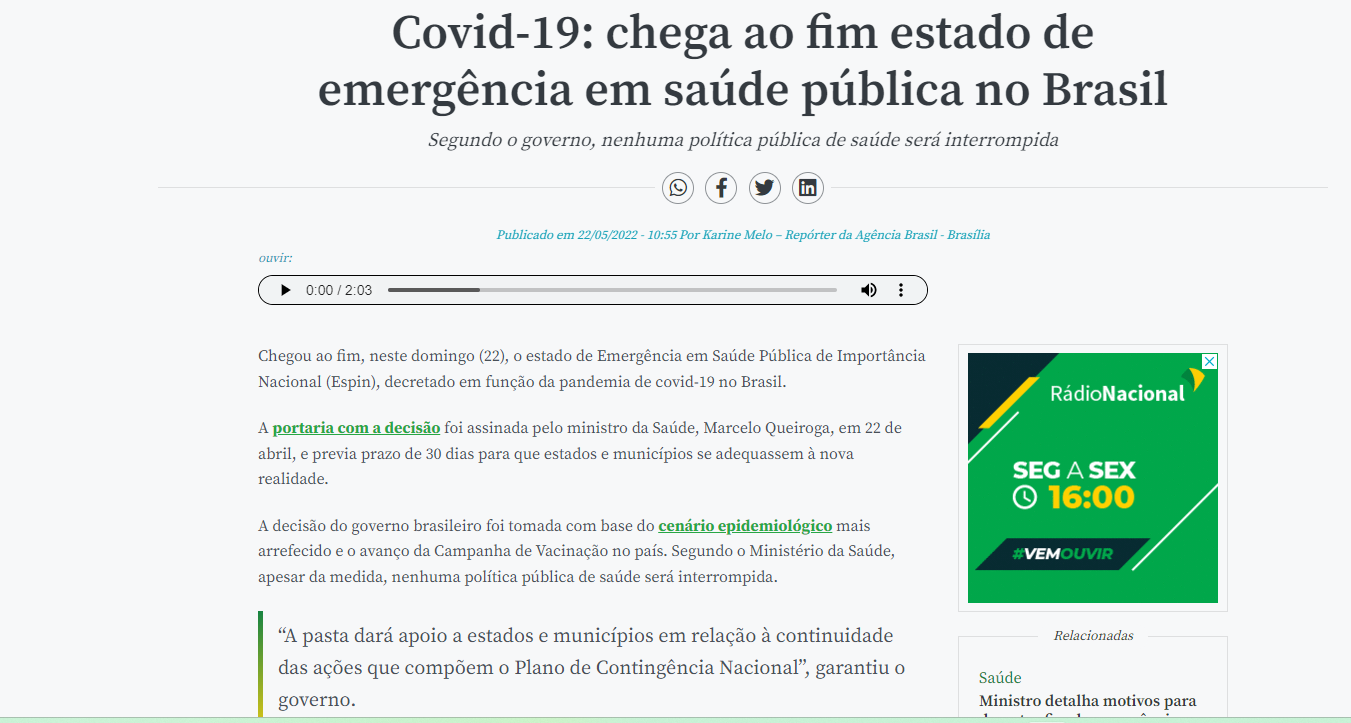


In [378]:
# Criando a coluna "Covid"
dados=dados.assign(Covid='xxx')
inicio_pandemia= pd.to_datetime('2020-03-15')
fim_pandemia=pd.to_datetime('2022-04-22')
for i in range(0,comp_dados):
    if dados['Data'][i]<inicio_pandemia:
        dados['Covid'][i]="Pré-Pandemia"
    elif dados['Data'][i]> fim_pandemia:
        dados['Covid'][i]="Pós-Pandemia"
    else:
        dados['Covid'][i]="Pandemia"
print(dados)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1            Sul 2023-07-17          23886.52           218.46   
5            Sul 2023-07-16          29043.86           265.63   
11           Sul 2023-07-15          37106.45           339.37   
13           Sul 2023-07-14          46777.17           427.82   
19           Sul 2023-07-13          52554.44           480.66   
...          ...        ...               ...              ...   
27071   Nordeste 2005-01-05          11820.00            85.58   
27074   Nordeste 2005-01-04          11285.00            81.71   
27078   Nordeste 2005-01-03          10929.00            79.13   
27082   Nordeste 2005-01-02          10267.00            74.34   
27086   Nordeste 2005-01-01          10222.00            74.01   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[MWmes]  \
1                    12383.58                 113.26  20459.24    18768.33   
5                     9325.97                  85.2

In [379]:
# Exibindo as informações do DataFrame "final", incorporada a coluna "Covid"
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27088 entries, 1 to 27086
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Subsistema              27088 non-null  object        
 1   Data                    27088 non-null  datetime64[ns]
 2   ENA_Bruta[MWmed]        27088 non-null  float64       
 3   ENA_Bruta[%MLT]         27088 non-null  float64       
 4   ENA_Armazenavel[MWmed]  27088 non-null  float64       
 5   ENA_Armazenavel[%MLT]   27088 non-null  float64       
 6   EAR_max                 27088 non-null  float64       
 7   EAR[MWmes]              27088 non-null  float64       
 8   EAR[%max]               27088 non-null  float64       
 9   Carga_Diaria[MWmed]     27088 non-null  float64       
 10  CMO_semanal[R$/MWh]     27088 non-null  float64       
 11  CMO_leve[R$/MWh]        27088 non-null  float64       
 12  CMO_media[R$/MWh]       27088 non-null  float6

Portanto, o dataframe "dados" possui todos os valores "não-nulos", sendo as colunas 'Subsistema' e 'Covid' qualitativas.

In [380]:
# Verificando a distribuição das classes (Covid)
dados.groupby('Covid').size()

Covid
Pandemia         3076
Pré-Pandemia    22208
Pós-Pandemia     1804
dtype: int64

Numa etapa futura, que objetivará a predição do CMO, espera-se que o período da pandemia mereça algum tipo de tratamento especial, de modo a evitar vieses incorretos nas saídas dos modelos de Machine Learning, a ser tratado nos próximos Sprints.

In [381]:
# Redefinindo os datasets por subsistema, incorporando a coluna "Covid"
filtro_SE = (dados['Subsistema'] == 'Sudeste')
dados_SE=dados.loc[filtro_SE]
filtro_S = (dados['Subsistema'] == 'Sul')
dados_S=dados.loc[filtro_S]
filtro_NE = (dados['Subsistema'] == 'Nordeste')
dados_NE=dados.loc[filtro_NE]
filtro_N = (dados['Subsistema'] == 'Norte')
dados_N=dados.loc[filtro_N]

In [382]:
print(dados_SE)

      Subsistema       Data  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
0        Sudeste 2023-07-17          23387.81            91.20   
4        Sudeste 2023-07-16          23510.10            91.68   
10       Sudeste 2023-07-15          23730.77            92.54   
12       Sudeste 2023-07-14          23873.74            93.09   
18       Sudeste 2023-07-13          23976.85            93.50   
...          ...        ...               ...              ...   
27069    Sudeste 2005-01-05          45324.00            90.05   
27075    Sudeste 2005-01-04          44388.00            88.19   
27076    Sudeste 2005-01-03          43314.00            86.06   
27080    Sudeste 2005-01-02          43352.00            86.13   
27084    Sudeste 2005-01-01          43952.00            87.32   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[MWmes]  \
0                    23229.30                  90.58  204615.33   174781.03   
4                    22996.69                  89

## Visualizações Unimodais

### Histogramas

In [383]:
# Histograma para visualização dos dados de ENA_Bruta[MWmed];ENA_Bruta[%MLT]; EAR[MWmes]; EAR[%max]; Carga_Diaria[MWmed] e CMO_Semanal[R$/MWh]
# Carregando o estilo "seaborn-v0_8"
plt.style.use("seaborn-v0_8")

# Alterando alguns parâmetros gráficos
plt.rc("axes", facecolor="#fafafa", grid = True)
plt.rc("grid", color = "#f0f0f0")
plt.rc("axes", edgecolor="#cccccc", lw=0.1)

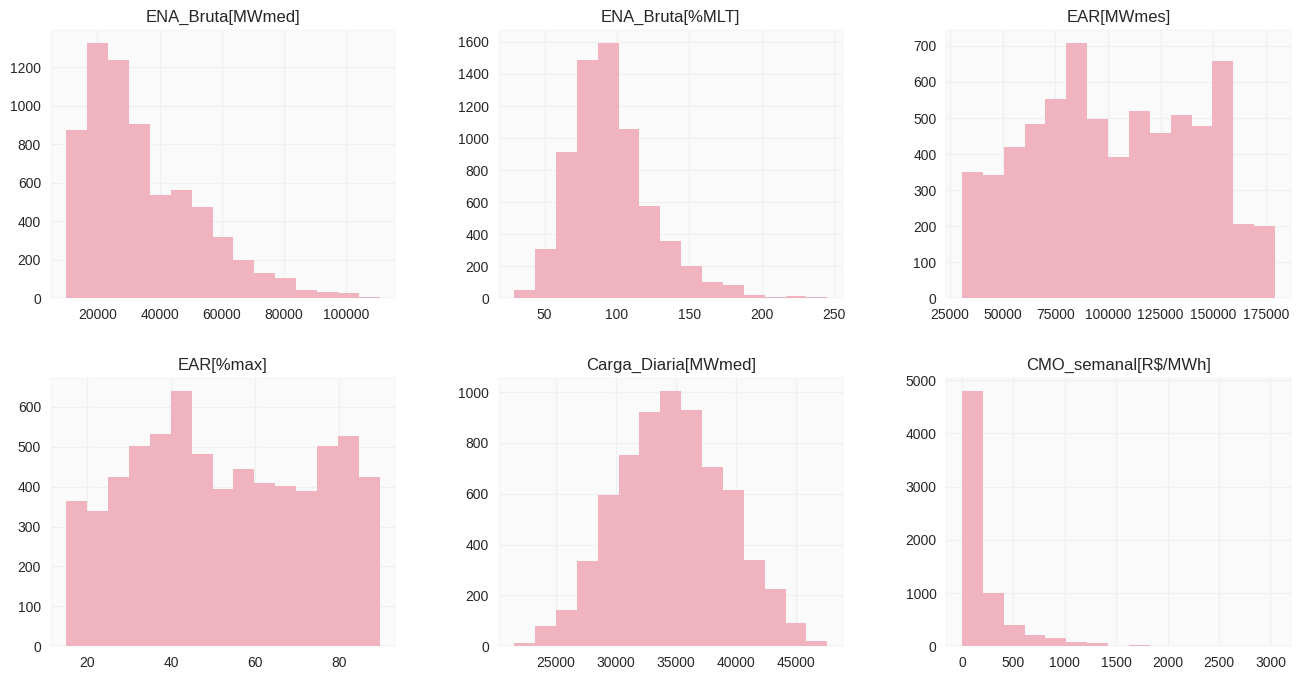

In [384]:
# Histograma Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#F0b3c0")
plt.show()

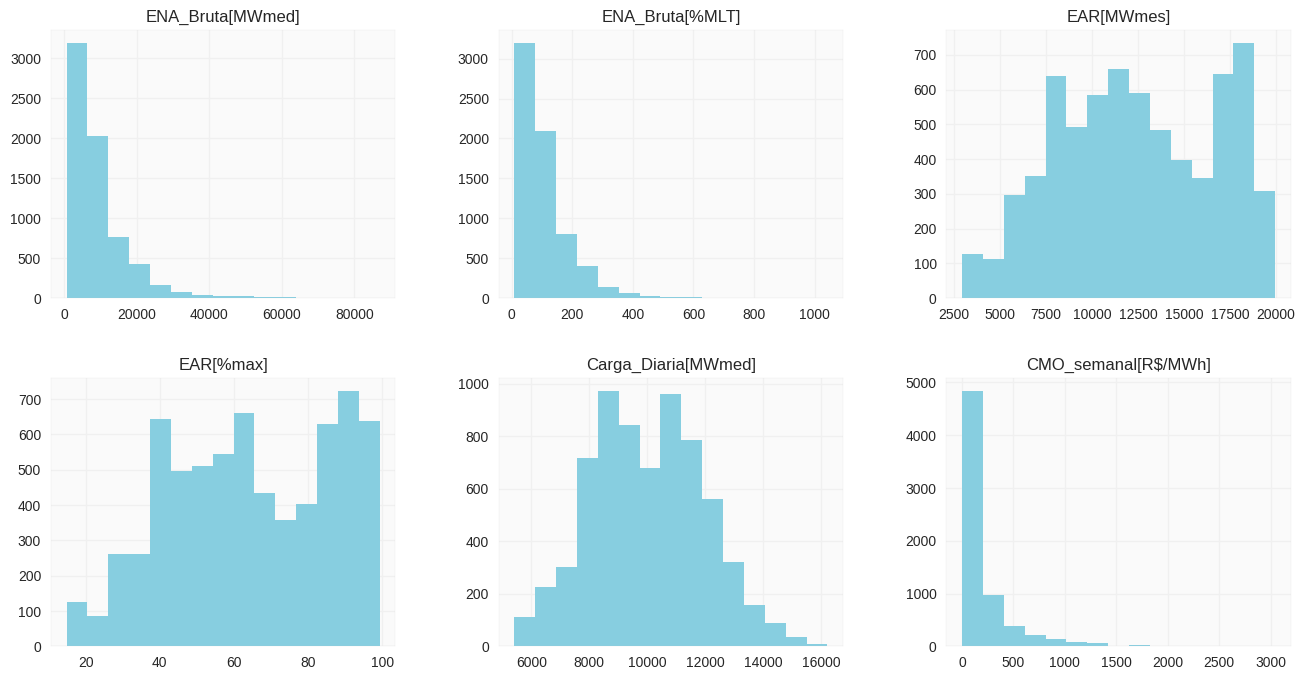

In [385]:
# Histograma Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#87cee0")
plt.bar_label
plt.show()

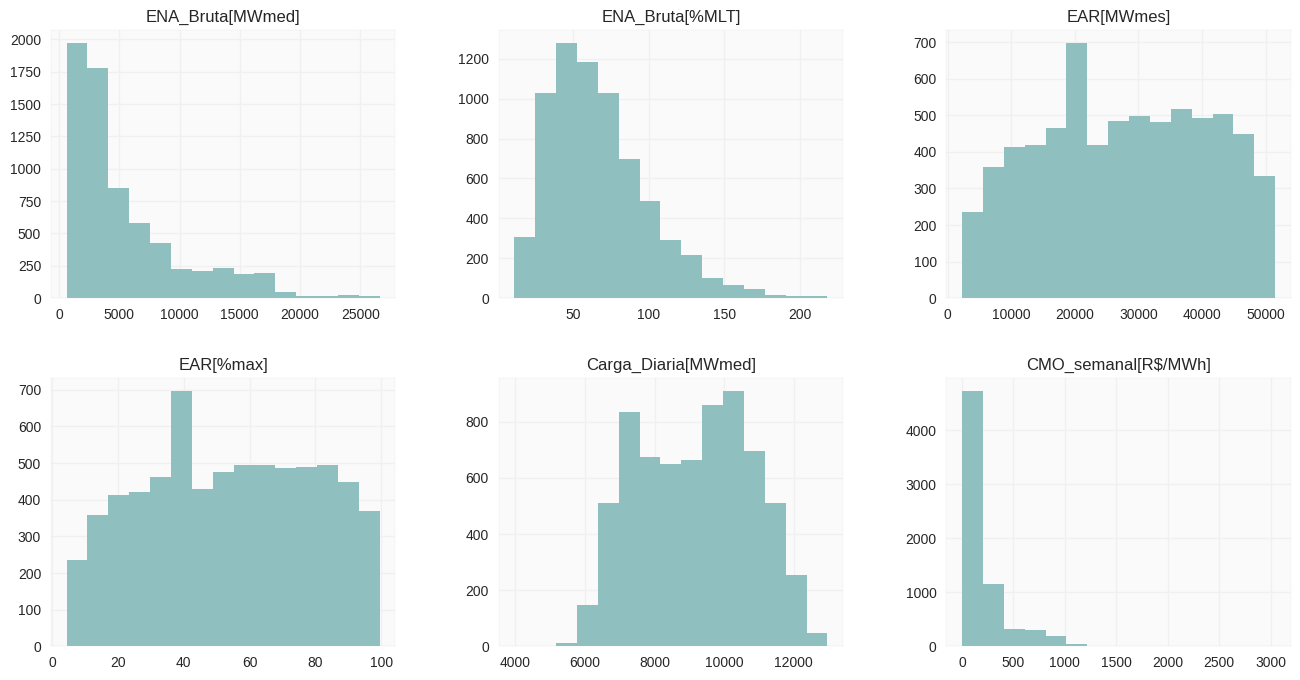

In [386]:
# Histograma Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15,layout = (2,3), figsize = (16,8), color="#8FBfbF")
plt.show()

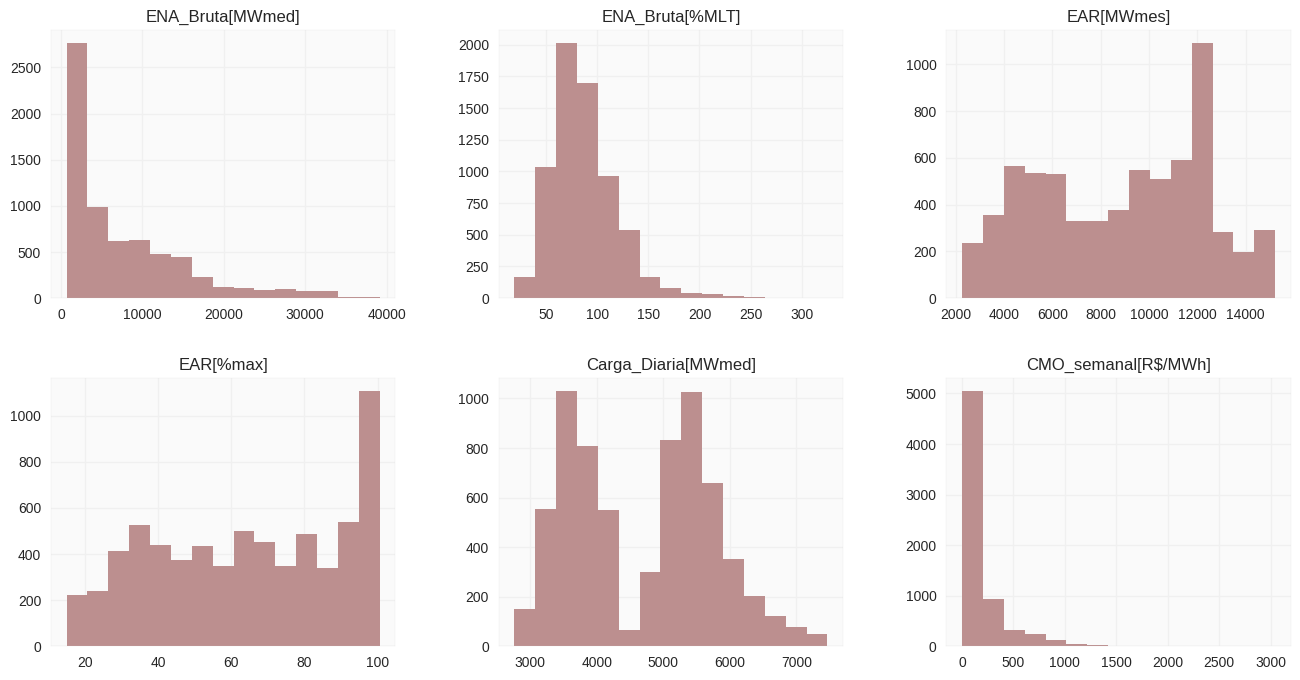

In [387]:
# Histograma Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].hist(bins=15, layout = (2,3), figsize = (16,8), color="#BC8F8F")
plt.show()



> Pela análise dos histogramas, para todos os subsistemas o CMO semanal apresenta assimetria positiva, indicando que a enorme maioria dos valores encontra-se abaixo dos 250 Reais/MWh, embora haja valores extremos, ultrapassando os 3000 R$/MWh, conforme visto nas tabelas com as estatísticas descritivas.


> Em relação ao comportamento da carga diária, para o Sudeste, aproxima-se bastante de uma distribuição normal. Chama a atenção a carga do Norte: provavelmente, esse comportamento "dividido em dois blocos bem definidos" se deve à entrada/saída de algum grande consumidor, que faça com que a ocorrência de valores entre 4 e 5 GWmed seja baixa.


> Em relação aos reservatórios, é interessante observar como, para o subsistema Nordeste, a maior frequência de EAR (%máx) no período está na faixa dos 40%. E que Sudeste e Sul também tiveram reservatórios próximos a esse patamar em um número expressivo de dias.



> Sobre a ENA em % da MLT, todos os subsistemas apresentam assimetria à direita. Para o Sudeste, a maior frequência é próxima dos 80-100% da MLT.









### Boxplot

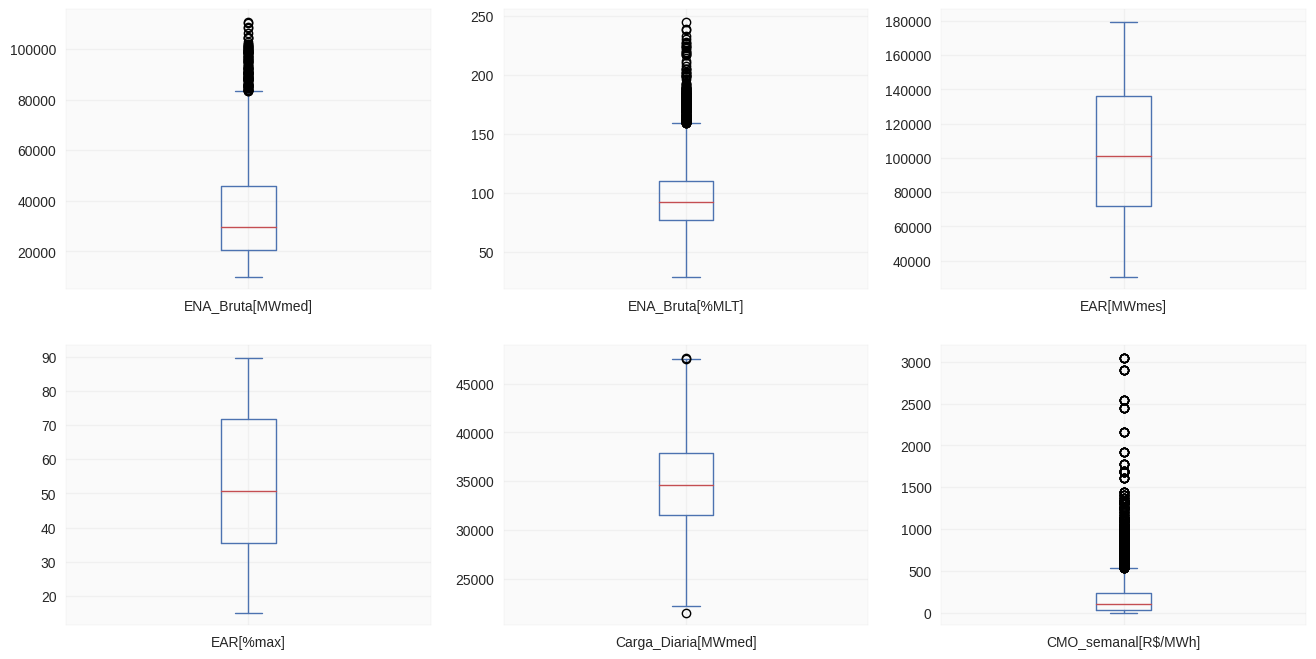

In [388]:
# Boxplot Sudeste
dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

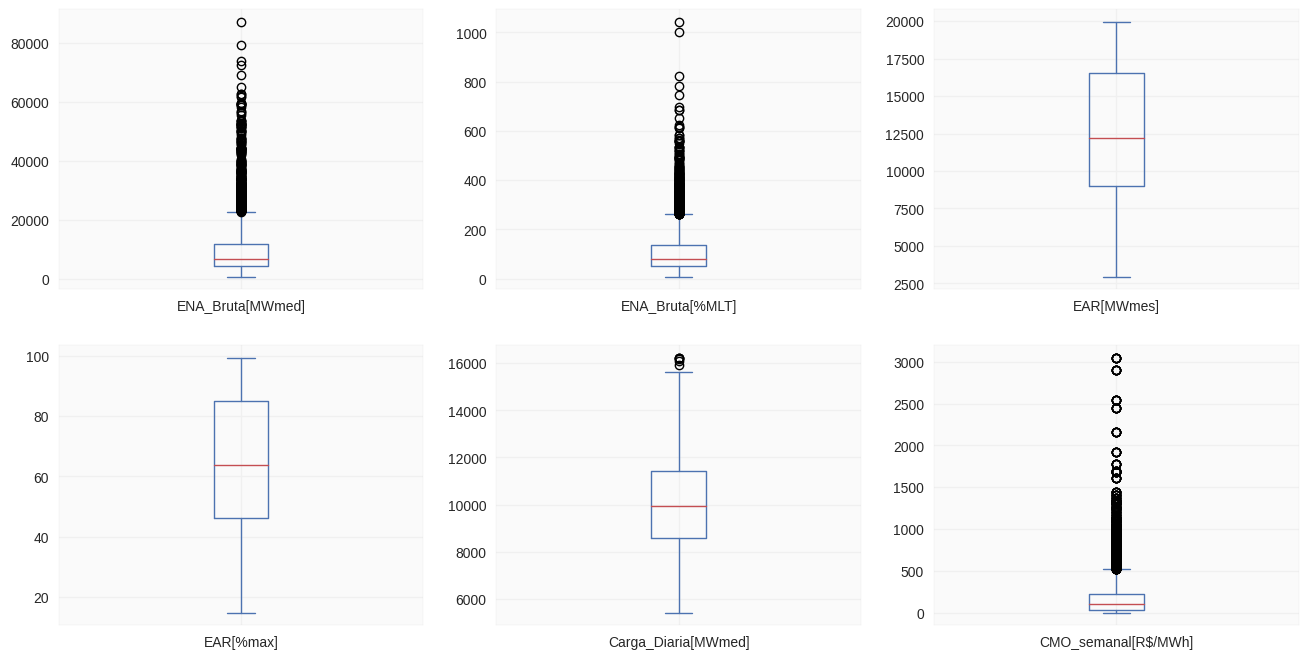

In [389]:
# Boxplot Sul
dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

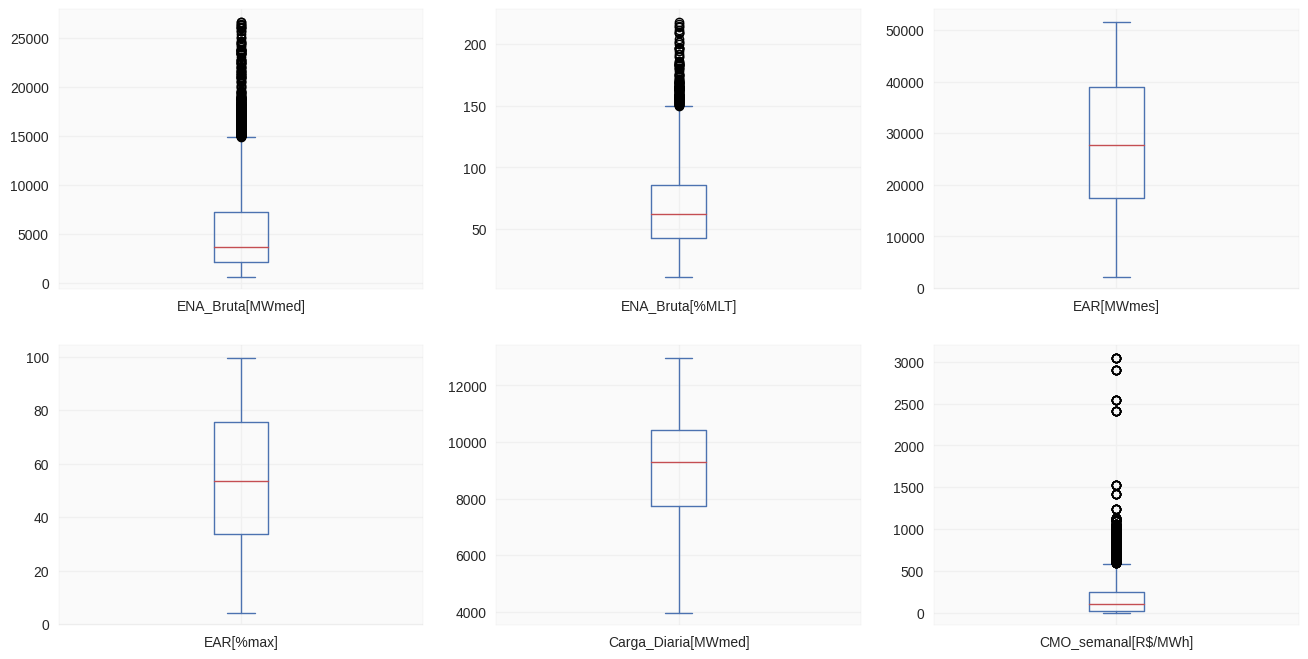

In [390]:
# Boxplot Nordeste
dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()

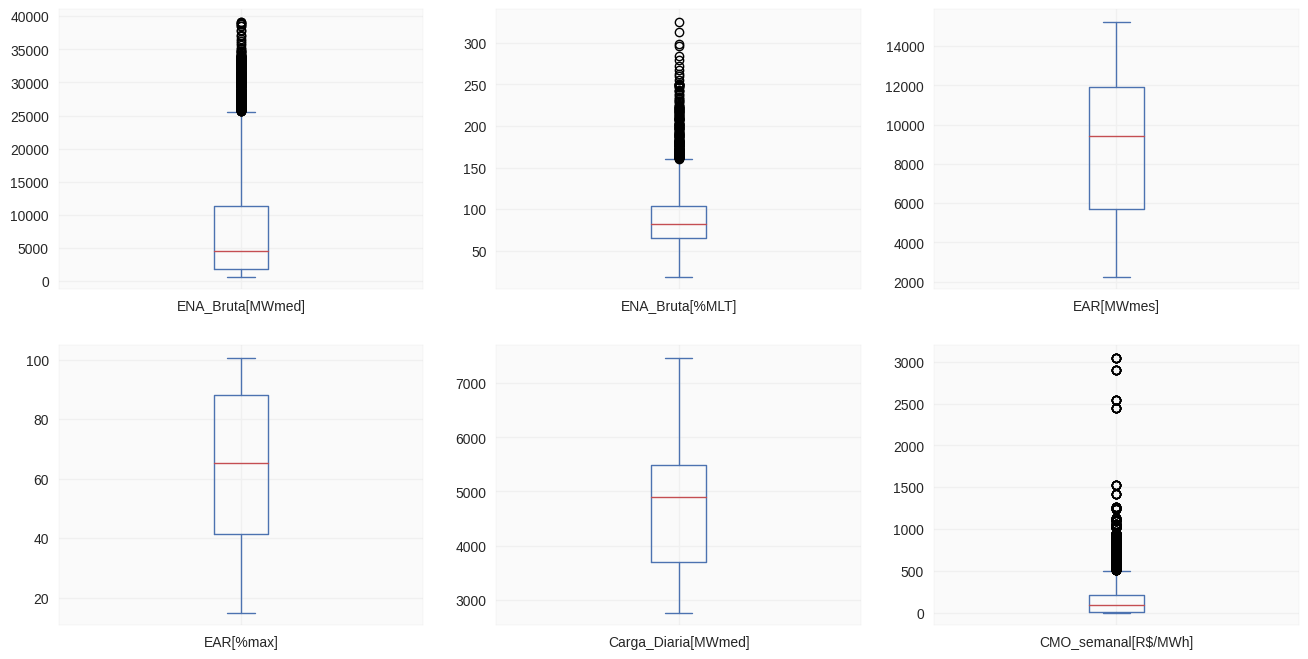

In [391]:
# Boxplot Norte
dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[MWmes]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].plot(kind = 'box', subplots = True, layout = (2,3), sharex = False, figsize = (16,8))
plt.show()



> A análise dos gráficos boxplot corrobora as constatações do histograma. Nas plotagens, a linha vermelha representa a mediana (imune a outliers). Para todos os subsistemas, observa-se que, em relação à Energia Armazenada, todos os valores encontram-se dentro dos limites do boxplot (tanto em MWmes quanto em %máximo). Este fato pode ser depreendido do histograma, pelo qual é possível perceber que não há diferenças significativas nas distribuições de probabilidade dos reservatórios, considerando um mesmo subsistema. Fato semelhante ocorre para os gráficos de carga diária. Neste ponto, destaca-se o fato de que, para a região Norte, o valor de P50 (próximo aos 5 GWmed) está bem mais próximo do valor correspondente ao terceiro quartil (P75) do que do primeiro (P25). Isso indica uma distribuição elevada de carga na faixa dos 5 ao 5,5 GWmed no referido subsistema. Para o Sul e Sudeste, alguns poucos valores acima do limite superior do intervalo.

> Em relação à ENA, no entanto, para todos os subsistemas se observam bastante valores fora dos limites do boxplot, característica das distribuições com assimetria à direita. Como destaque, para o Sul, houve uma ocorrência de ENA superior aos 1000% da MLT o que, certamente, configura um evento extremamente atípico em termos meteorológicos/climatológicos.


> Por fim, em relação ao CMO, observa-se que em 50% da amostra, os valores são inferiores a 150 Reais/MWh para os 4 subsistemas. O P75 não chega aos 250 Reais/MWh e o limite da faixa gira em torno dos 500 Reais/MWh. Nas etapas de predição/prescrição, faz-se necessário, portanto, maior atenção aos valores fora do intervalo, provavelmente correspondentes a períodos de grave escassez hídrica, como foi o biênio 2020-2021, quando os baixos valores de ENA e EArm levaram ao CMO de mais de 3000 Reais/MWh.






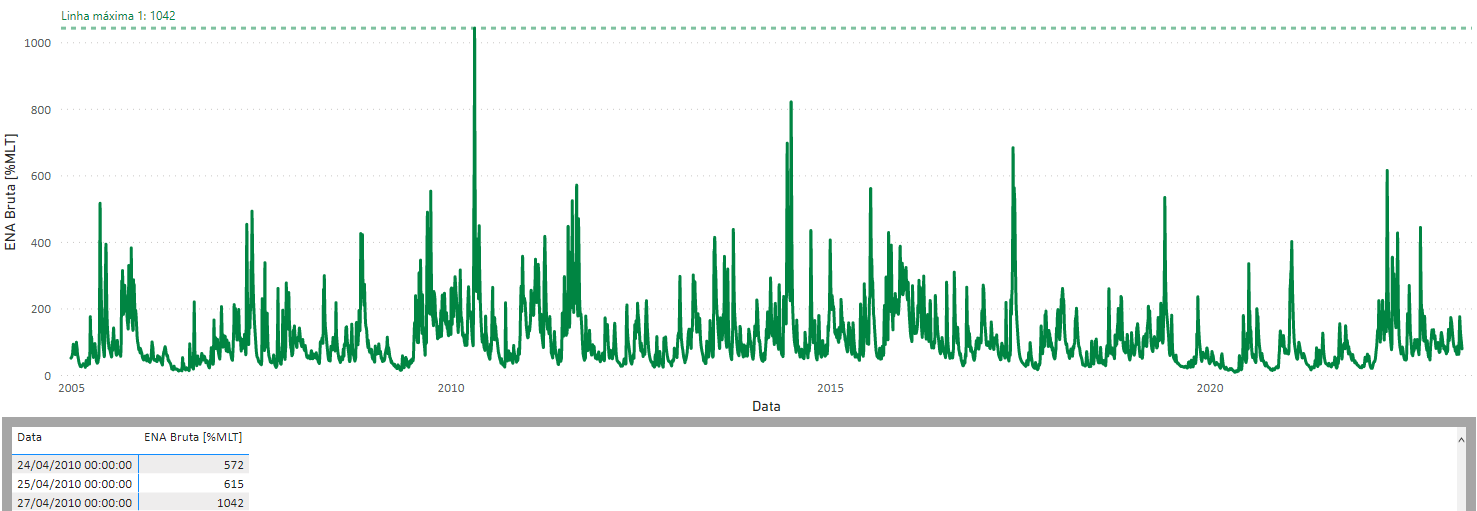
Data de ocorrência do evento de mais de 1000% da MLT na região Sul, correspondente a cerca de 60 GWmed (gráfico elaborado por meio do Power BI).

## Visualizações Multimodais

### Matriz de Correlação

<Axes: >

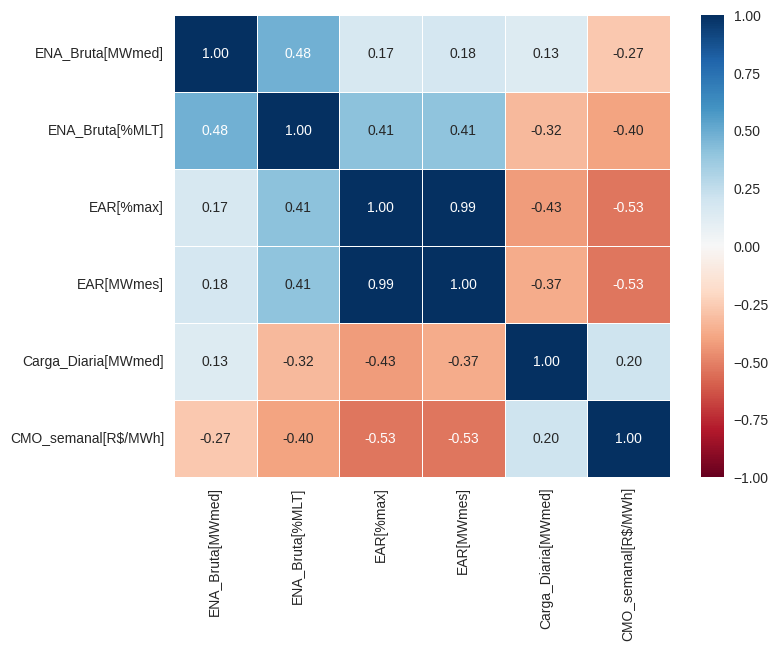

In [392]:
# Matriz de Correlação para o Sudeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

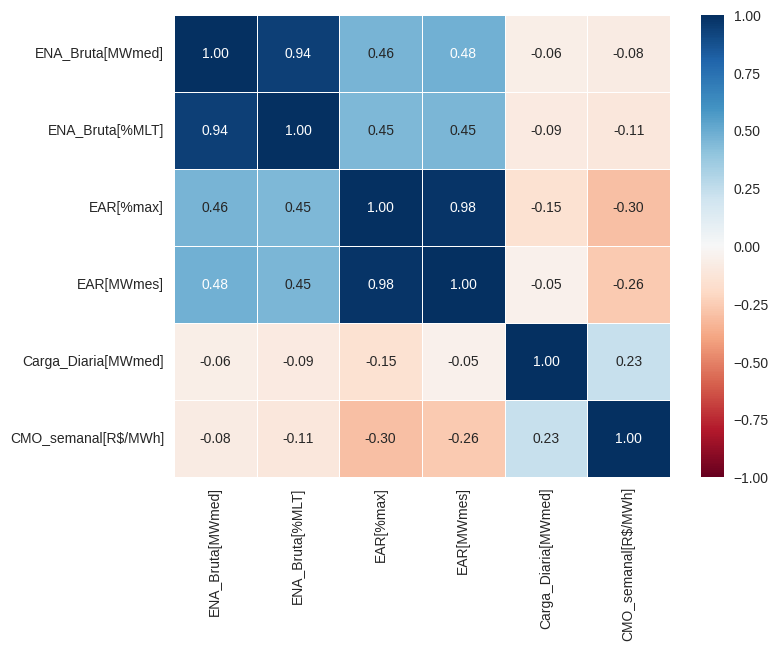

In [393]:
# Matriz de Correlação para o Sul
plt.figure(figsize=(8,6))
sns.heatmap(dados_S[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

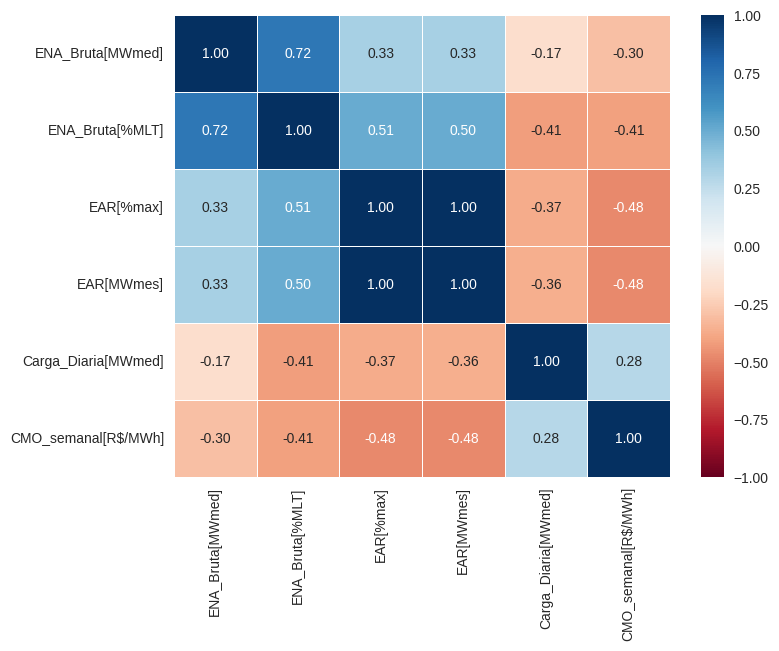

In [394]:
# Matriz de Correlação para o Nordeste
plt.figure(figsize=(8,6))
sns.heatmap(dados_NE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

<Axes: >

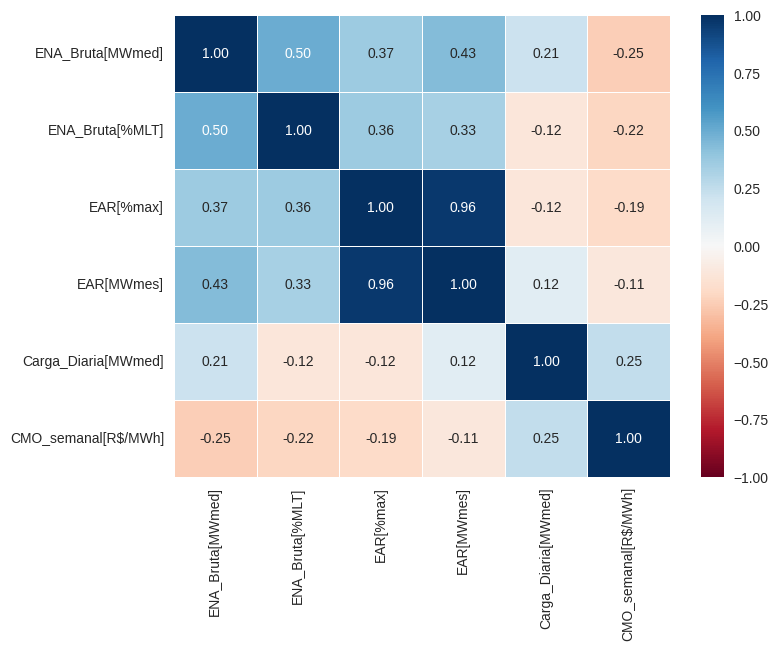

In [395]:
# Matriz de Correlação para o Norte
plt.figure(figsize=(8,6))
sns.heatmap(dados_N[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']].corr(), annot=True,
            fmt = ".2f", cmap='RdBu',
            linewidths=.5,
            vmin = -1, vmax = 1)

Conforme analisado anteriormente, considerando todo o horizonte de dados disponível (2005-dias atuais), é possível identificar uma correlação moderada (negativa) do CMO com a Energia Armazenada (em % do volume útil) e com a Energia Natural Afluente (em % da MLT) principalmente para o Sudeste e o Nordeste, que são os subsistemas com maior volume máximo de reservatórios do SIN. Para a carga, a correlação é positiva moderada, em todos os subsistemas, conforme esperado "intuitivamente". É possível constatar ainda que ENA (%MLT) e EArm (%máx) se correlacionam positivamente. Esse comportamento faz sentido, uma vez que na ocorrência de chuvas (e, consequentemente, de elevação da ENA) espera-se que os reservatórios (EArm) também se encham. As políticas operativas, no entanto, podem acabar levando a maiores ou menores deplecionamentos dos reservatórios das usinas hidroelétricas, por fora dos modelos, a depender da conjuntura hidrológica e do balanço energético do Sistema Interligado Nacional.

### Scatter Plot

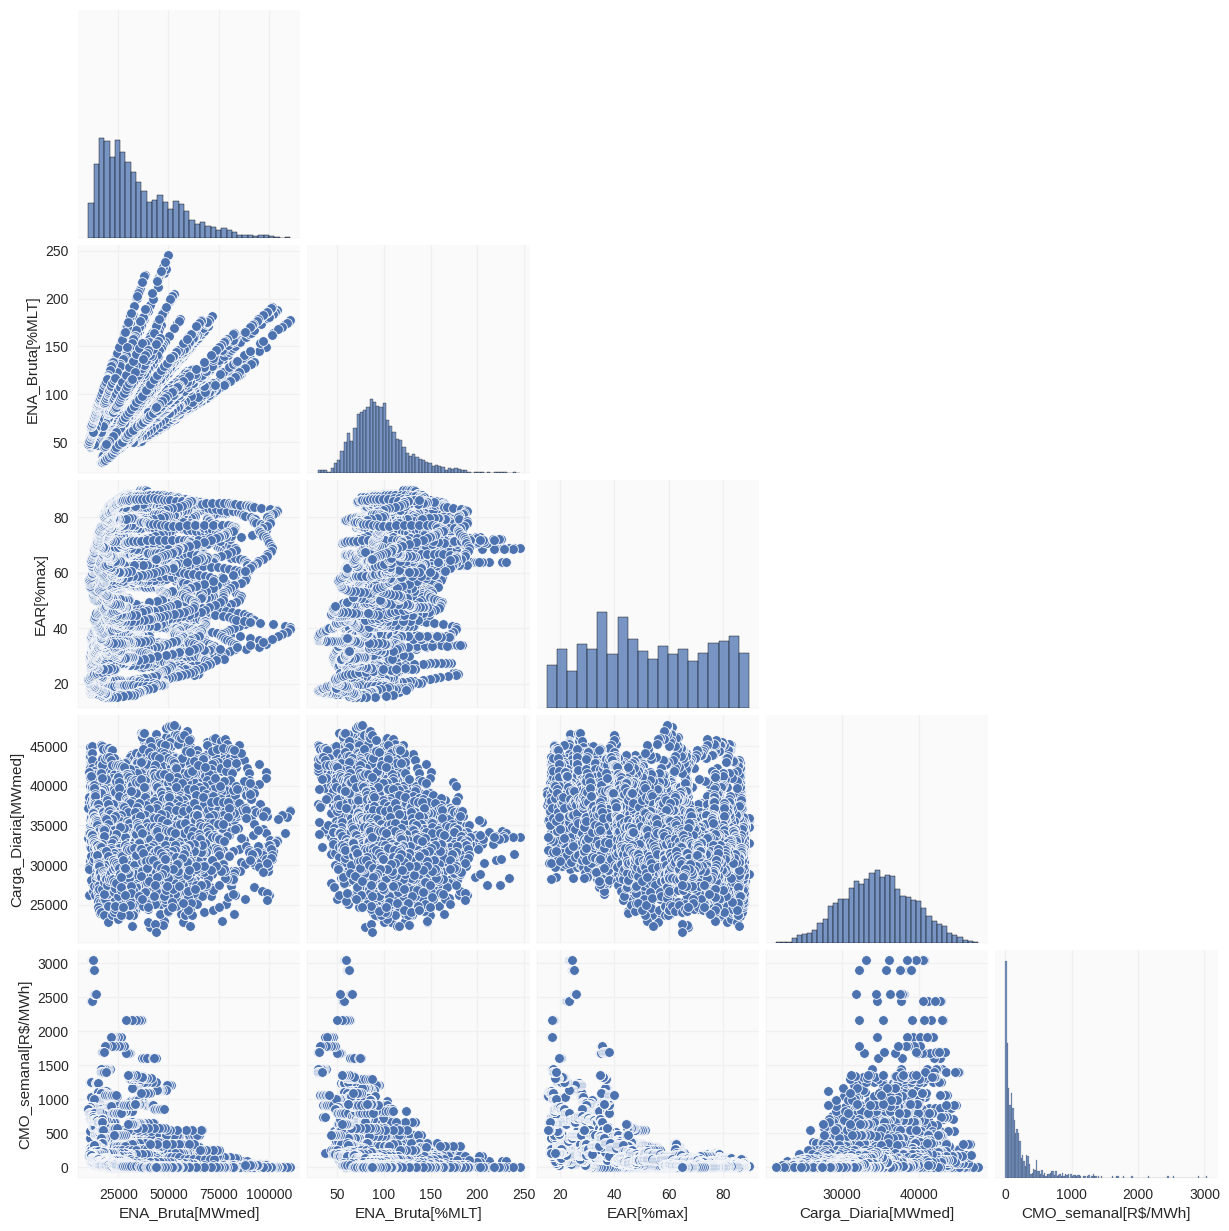

In [396]:
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
# Scatter Plot com Seaborn - Sudeste
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]']], corner=True)

Pela avaliação do scatter-plot, podemos observar como os maiores valores de CMO semanal ocorrem para valores de ENA Bruta inferiores a 75% da MLT e para reservatórios abaixo dos 40% do volume útil no Sudeste. É possível observar também que o CMO de 0 R$/MWh nunca ocorreu em casos de ENA diária inferior a 50% da MLT no Sudeste. Um outro destaque é o fato de os maiores valores de CMO não terem ocorrido para valores mínimos de ENA em % da MLT (e sim próximo aos 60%), mas, para ENAs muito baixas em termos absolutos (MWmed). Isto nos leva a crer que esses Custos muito elevados se deram em algum mês de MLT mais baixa (ou seja, de valores históricos de chuva mais baixos, pela sazonalidade/climatologia. Provavelmente, entre junho e novembro, meses do chamado "período seco"). Além disso, para reservatórios superiores a 50%-55%, o CMO não ultrapassou os 500 Reais/MWh que, como vimos no Boxplot, é o limite superior do mesmo. Em relação à carga, à exceção de valores outlier de CMO, o comportamento da curva Carga x CMO parece ter uma tendência de distribuição normal, para a qual valores mais elevados de CMO ocorrem em cargas intermediárias, entre 30 e 40 GWmed. Esse comportamento não é intuitivo, a princípio. Porém, como pode ser visto no gráfico de ENA Bruta (MWmed) x Carga, os maiores valores de ENA ocorreram para cargas de aproximadamente 35 GWmed e isso poderia explicar o comportamento do CMO (embora essa relação ENA x Carga possa ser uma coincidência em função da pandemia - menor carga e El Niño - condições climáticas - menor ENA). Para trabalhos futuros, fazem-se necessárias avaliações mais detalhadas a respeito.

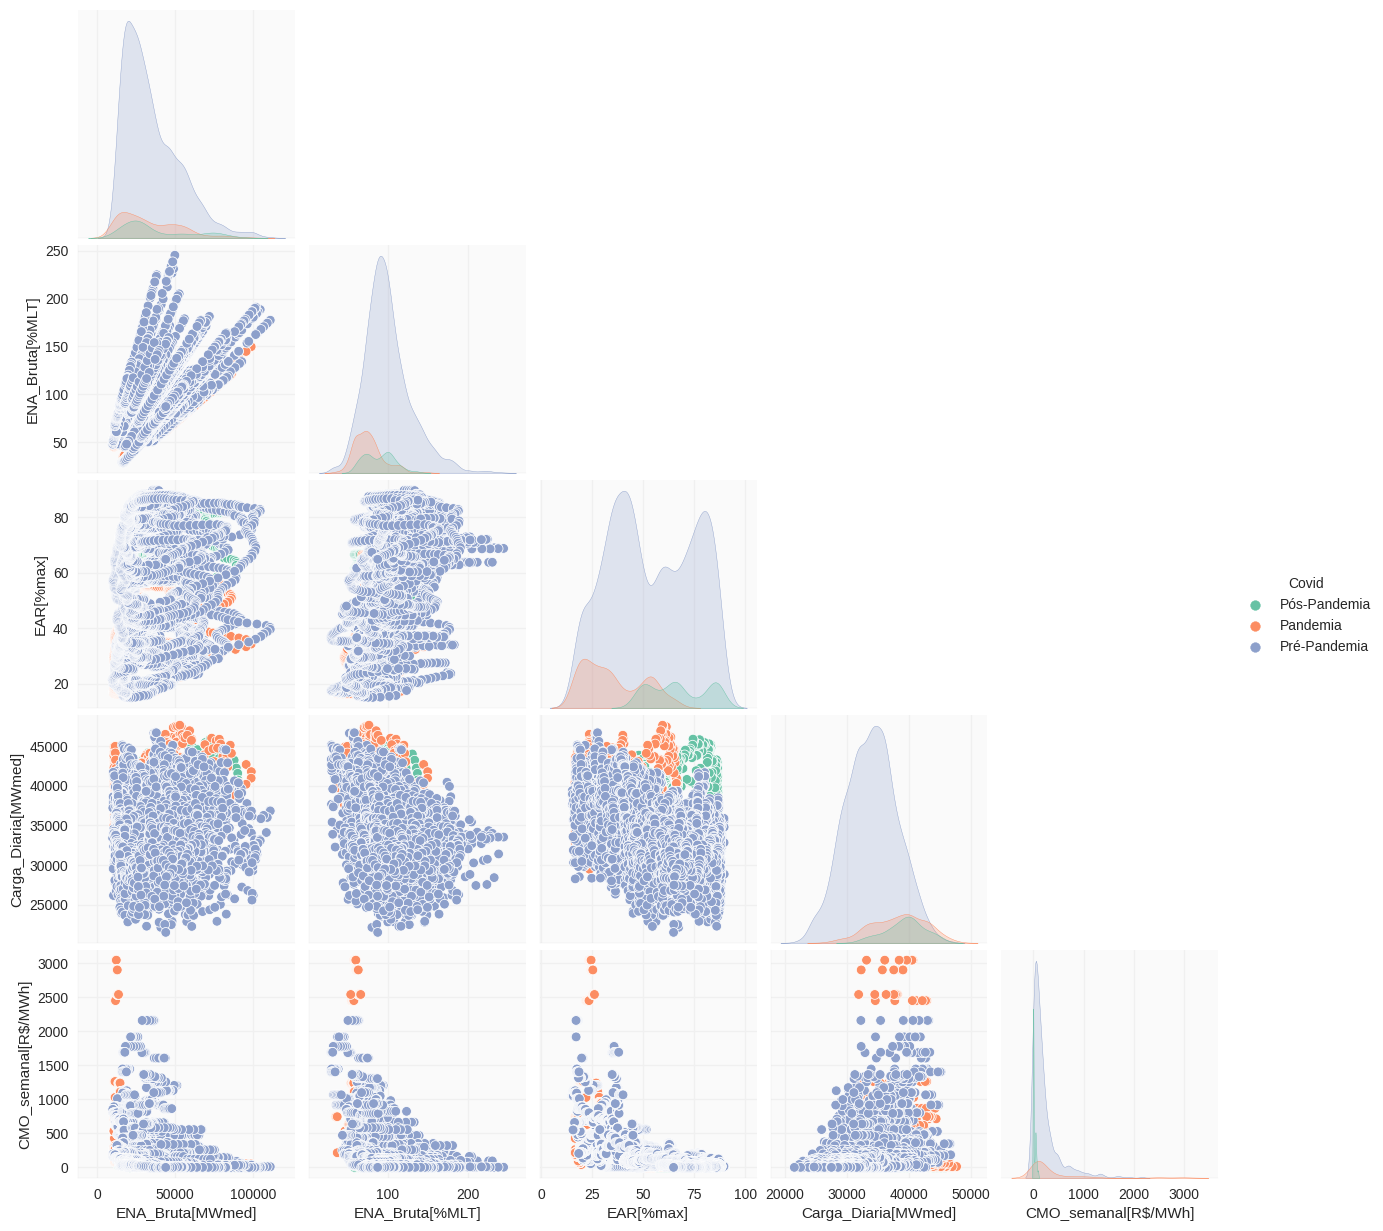

In [397]:
# Scatter Plot considerando a variável qualitativa referente à pandemia de Covid-19
# Faremos a análise apenas para o subsistema sudeste, por ser o mais relevante para o SIN
sns.pairplot(dados_SE[['ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','EAR[%max]','Carga_Diaria[MWmed]','CMO_semanal[R$/MWh]','Covid']], hue = "Covid", height = 2.5, corner=True, palette="Set2")

A principal interferência da pandemia de Covid-19 nas grandezas avaliadas diz respeito à carga. Embora, coincidentemente (mas sem nenhum tipo de relação causal), os valores de ENA (em MWmed e em % da MLT) tenham tido uma distribuição mais assimétrica à direita no período da pandemia do que no período anterior a ela. É necessário, em análises futuras (e no treinamento dos modelos de ML) cautela neste aspecto, para que os algoritmos não indiquem correlações indevidas entre a pandemia e a ENA. Em relação à carga, durante a pandemia (e no pós), o que enxergamos é um deslocamento da curva para uma assimetria mais à esquerda. Para análises futuras, é interessante avaliar os anos imediatamente anteriores à pandemia (talvez encurtar o horizonte, neste caso, por exemplo), para tentar entender melhor os efeitos. Além disso, no durante e pós-pandemia observa-se um desvio-padrão maior (da carga) em comparação aos anos prévios. Sobre a correlação com o CMO, observamos que os maiores valores de CMO registrados ocorreram durante a pandemia, mesmo para cargas intermediárias que, fora da pandemia, levaram o custo no máximo a 70% dos 3000 Reais/MWh). E este fato provavelmente se explica pelos valores mais severos de ENA e EArm no intervalo de 2020 a 2022.

## Avaliações Temporais no Power BI

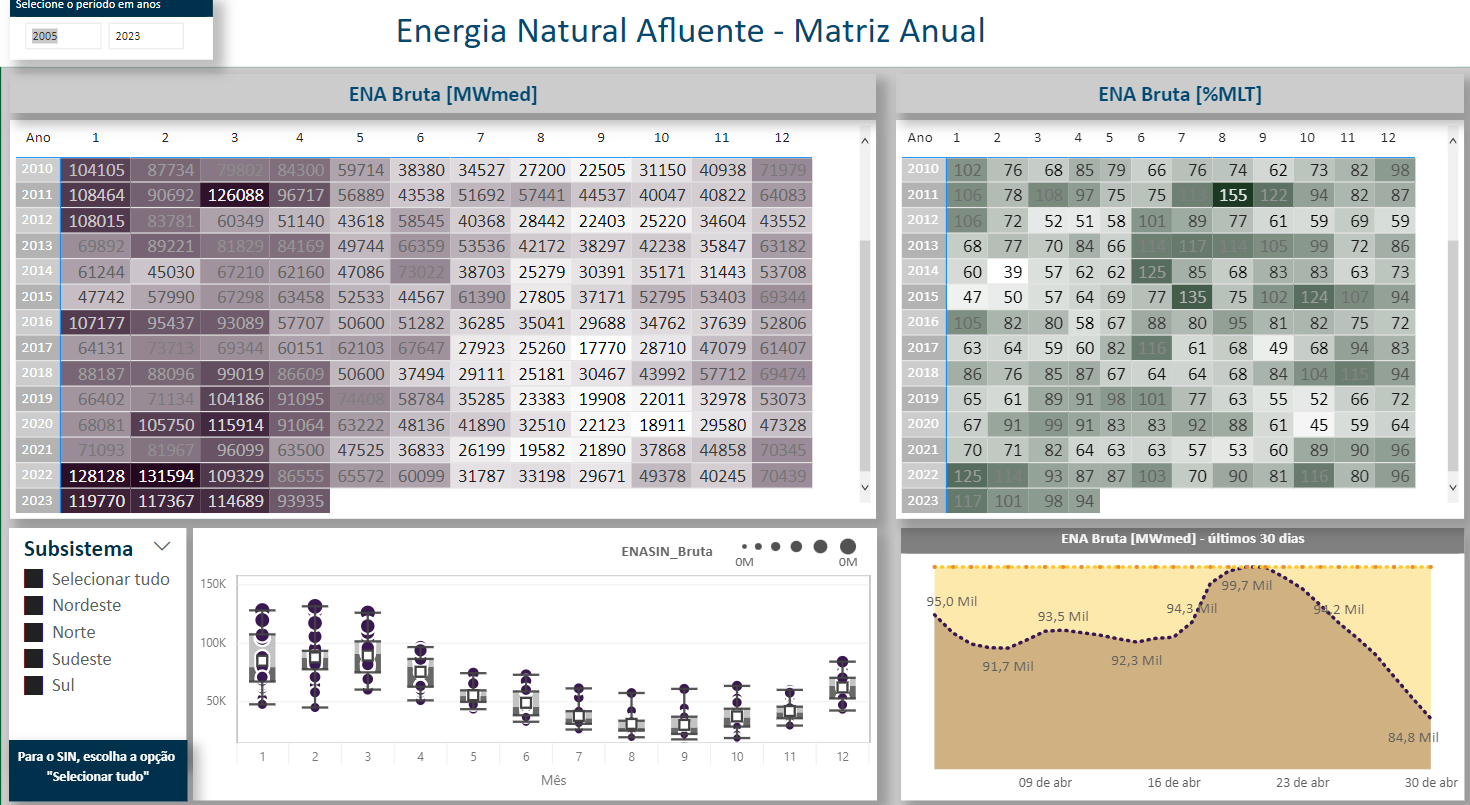

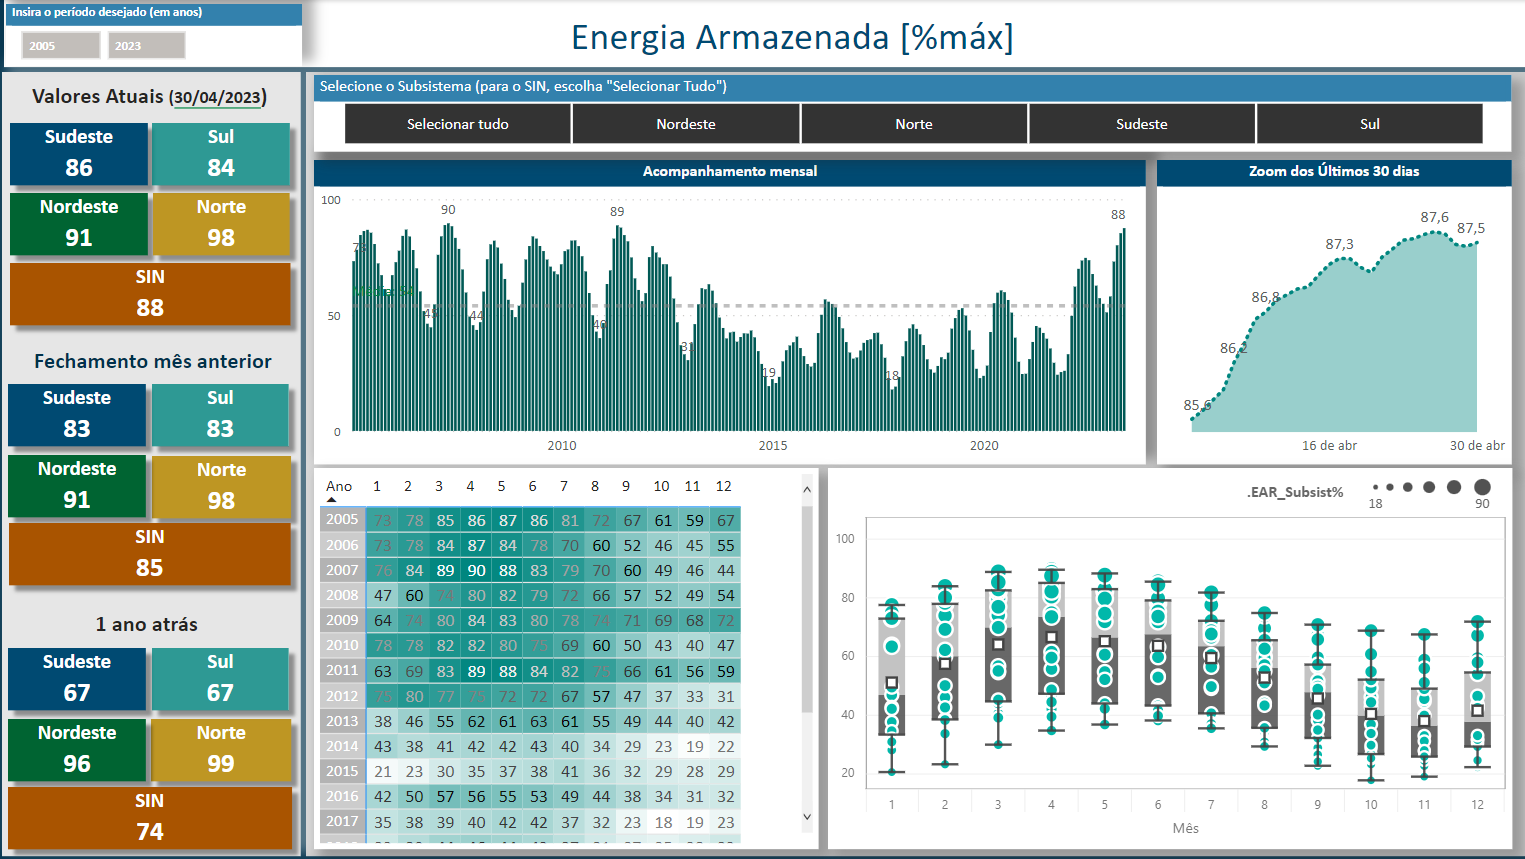

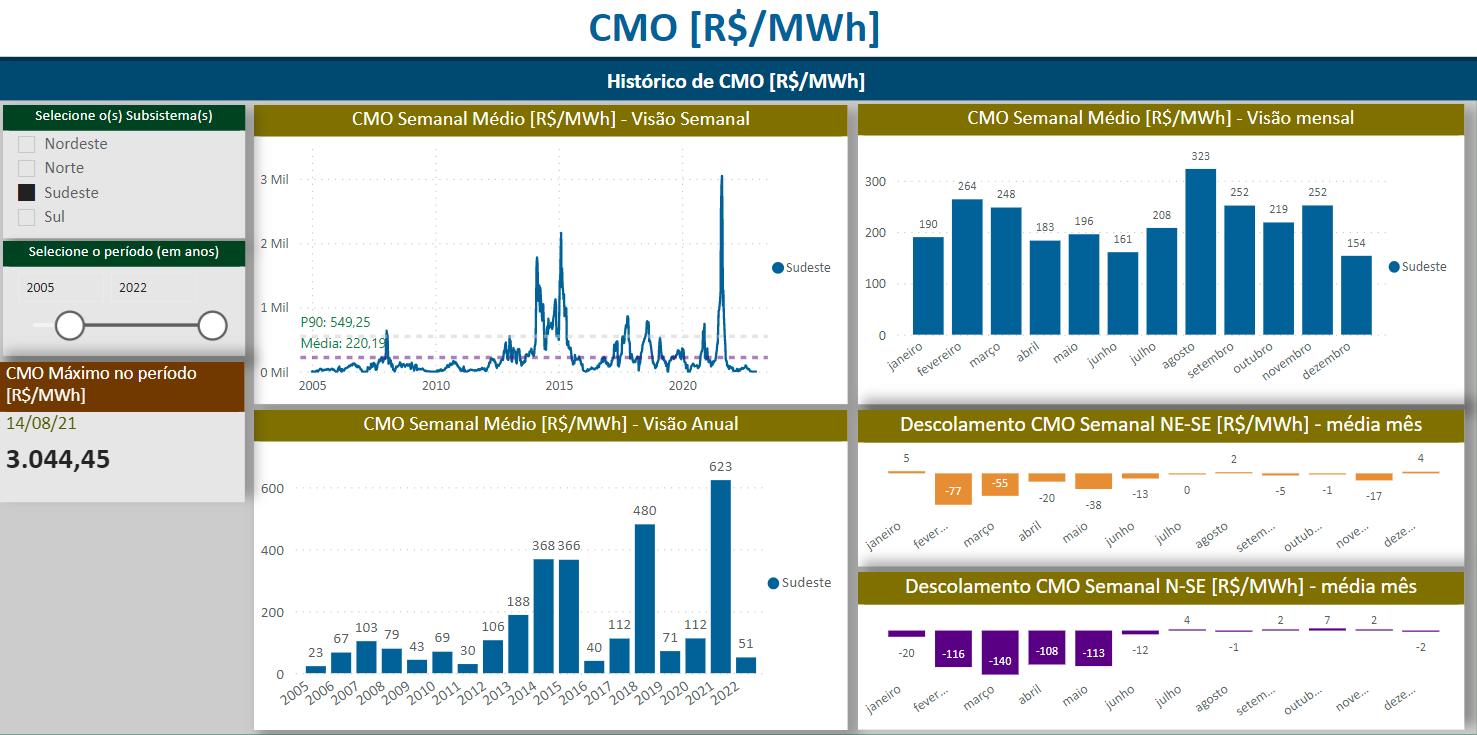

Os dados obtidos a partir da Área de Dados Abertos do ONS foram importados no Power BI (via Power Query) e, em seguida, foram gerados os dashboard acima. Pelas visualizações, pode-se concluir, por exemplo, que: desde 2011, o mês de abril não registrava ENA (% da MLT) tão alta. Além disso, pelo boxplot de ENA é possível identificar a sazonalidade do período chuvoso/seco no Brasil, de modo que dezembro a abril são os meses de maior mediana (período úmido). Em relação ao histórico recente, observa-se uma queda de mais de 10 GWmed de ENA no SIN entre o final de março e o final de abril o que é, de certa forma, esperado pela climatologia dos referidos meses. Apesar da redução da ENA (em termos absolutos) os reservatórios do SIN sofreram uma elevação no último mês. Quando comparados ao mesmo período de 2022 (30/04/23 vs 30/04/22), a crescente é muito expressiva, principalmente no Sul e no Sudeste. Podemos perceber que o enchimento/deplecionamento dos reservatórios tem um comportamento cíclico ao longo de um ano e que, desde 2011, não observávamos condições tão favoráveis de energia armazenada quanto atualmente. Em relação ao CMO médio no decorrer dos anos, observa-se que, de fato, 2011 teve valores baixíssimos do custo de operação médio. Também é possível observar que em 2021, quando as ENAs ficaram muito baixas, o preço médio anual foi o maior do histórico e que basta um ano favorável ou desfavorável em termos de chuva para alterar a tendência de CMO do ano anterior. Em relação aos valores médios nos meses, observa-se que agosto (mês de menor MLT no Sudeste) é o de maior CMO médio, ao passo que dezembro (início do período úmido), o de menor. Em relação aos valores por subsistema, observa-se que nos meses chuvosos, dentro do horizonte analisado, em geral o CMO do Nordeste e do Norte foi menor que o do Sudeste. Este aspecto está diretamente relacionado à capacidade de fluxo de energia entre os subsistemas e, considerando ampliações e reforços na transmissão, pode não ser mais replicável daqui em diante. Este aspecto não está explícito pelos dados do presente trabalho mas, em etapas futuras, faz-se pertinente a inclusão.


# **Seção IV: Pré-Processamento de Dados - Parte 2**


> Ao longo das seções/etapas anteriores, já realizamos várias atividades de pré-processamento de dados, de modo a deixar nosso DataFrame mais "enxuto", menos "redundante" e mais adequado para aplicação de Modelos de Machine Learning. Neste momento, iremos reduzir ainda mais a dimensionalidade e realizar algumas transformações numéricas.



## Redução da Dimensionalidade

In [398]:
# Reduzindo a dimensionalidade do dataset dados, excluindo as colunas de CMO por patamar
dados=dados[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_SE=dados_SE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_S=dados_S[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_NE=dados_NE[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]']]
dados_N=dados_N[['Data','Subsistema','ENA_Bruta[MWmed]','ENA_Bruta[%MLT]','ENA_Armazenavel[MWmed]','ENA_Armazenavel[%MLT]','EAR_max', 'EAR[%max]','EAR[MWmes]','Carga_Diaria[MWmed]','Covid','CMO_semanal[R$/MWh]',]]

# Avaliando as 20 primeiras linhas do dataset dados
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-17        Sul          23886.52           218.46   
5  2023-07-16        Sul          29043.86           265.63   
11 2023-07-15        Sul          37106.45           339.37   
13 2023-07-14        Sul          46777.17           427.82   
19 2023-07-13        Sul          52554.44           480.66   
21 2023-07-12        Sul          38150.56           348.92   
25 2023-07-11        Sul          22474.47           205.55   
29 2023-07-10        Sul          14450.74           132.17   
35 2023-07-09        Sul          12076.80           110.45   
37 2023-07-08        Sul           8570.63            78.39   
41 2023-07-07        Sul           4960.35            45.37   
45 2023-07-06        Sul           4743.88            43.39   
50 2023-07-05        Sul           4907.02            44.88   
53 2023-07-04        Sul           5300.46            48.48   
57 2023-07-03        Sul           5670.69            51.86   
61 2023-07-02        Sul           6156.29            56.30   
67 2023-07-01        Sul           6742.79            61.67   
69 2023-06-30        Sul           7623.52            72.98   
73 2023-06-29        Sul           8898.18            85.19   
77 2023-06-28        Sul          10477.56           100.31   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                 12383.58                 113.26  20459.24      91.74   
5                  9325.97                  85.29  20459.24      91.61   
11                16259.19                 148.71  20459.24      91.41   
13                22166.83                 202.74  20459.24      91.11   
19                10852.02                  99.25  20459.24      90.54   
21                 7699.81                  70.42  20459.24      90.10   
25                 9576.44                  87.59  20459.24      88.99   
29                10333.96                  94.51  20459.24      87.90   
35                 9341.64                  85.44  20459.24      87.40   
37                 7909.86                  72.34  20459.24      86.74   
41                 4903.55                  44.85  20459.24      86.47   
45                 4685.92                  42.86  20459.24      87.46   
50                 4775.26                  43.67  20459.24      87.92   
53                 5194.27                  47.51  20459.24      88.00   
57                 5611.31                  51.32  20459.24      87.93   
61                 5982.46                  54.72  20459.24      88.38   
67                 6679.17                  61.09  20459.24      88.44   
69                 7522.01                  72.01  20459.24      88.34   
73                 8103.01                  77.57  20459.24      88.69   
77                 7770.75                  74.39  20459.24      88.92   

    EAR[MWmes]  Carga_Diaria[MWmed]         Covid  CMO_semanal[R$/MWh]  
1     18768.33             11791.29  Pós-Pandemia                  0.0  
5     18742.31              8588.72  Pós-Pandemia                  0.0  
11    18701.48             10013.12  Pós-Pandemia                  0.0  
13    18640.30             11964.35  Pós-Pandemia                  0.0  
19    18524.37             12161.34  Pós-Pandemia                  0.0  
21    18433.05             12878.77  Pós-Pandemia                  0.0  
25    18205.68             12614.67  Pós-Pandemia                  0.0  
29    17983.21             12420.95  Pós-Pandemia                  0.0  
35    17881.54              9590.25  Pós-Pandemia                  0.0  
37    17745.68             11084.72  Pós-Pandemia                  0.0  
41    17691.66             13165.96  Pós-Pandemia                  0.0  
45    17893.71             12945.81  Pós-Pandemia                  0.0  
50    17988.29             12878.85  Pós-Pandemia                  0.0  
53    18003.37             12744.65  Pós-Pandemia                  0.0  
57    17989.88             12325.33

In [399]:
# Confirmando novamente a ausência de dados faltantes
dados.isnull().sum()

Data                      0
Subsistema                0
ENA_Bruta[MWmed]          0
ENA_Bruta[%MLT]           0
ENA_Armazenavel[MWmed]    0
ENA_Armazenavel[%MLT]     0
EAR_max                   0
EAR[%max]                 0
EAR[MWmes]                0
Carga_Diaria[MWmed]       0
Covid                     0
CMO_semanal[R$/MWh]       0
dtype: int64

In [400]:
# Exibindo as dimensões de cada dataset
print("SIN:")
print(dados.shape)
print("Sudeste:")
print(dados_SE.shape)
print("Sul:")
print(dados_S.shape)
print("Nordeste:")
print(dados_NE.shape)
print("Norte:")
print(dados_N.shape)

SIN:
(27088, 12)
Sudeste:
(6772, 12)
Sul:
(6772, 12)
Nordeste:
(6772, 12)
Norte:
(6772, 12)


## Preparação para os Algoritmos de ML

A Normalização e a padronização são técnicas frequentemente aplicadas na etapa de preparação dos dados, com o objetivo de colocá-los em um intervalo de valores comuns. Não são técnicas obrigatórias para todos os algoritmos de Machine Learning mas podem impactar na acurácia do modelo a ser utilizado.

Alterando os dados da coluna 'Covid' de qualitativos (categóricos) para codificação ordinal, de modo que "Pré-Pandemia"=0; "Pandemia"=1 e "Pós-Pandemia"=2

In [401]:
# Armazenando os datasets com a coluna 'Covid' original
dados_pandemia=dados
dados_pandemia_SE=dados_SE
dados_pandemia_S=dados_S
dados_pandemia_NE=dados_NE
dados_pandemia_N=dados_N

In [402]:
# Aplicando Ordinal Encoding
dados['Covid']=dados['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_SE['Covid']=dados_SE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_S['Covid']=dados_S['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_NE['Covid']=dados_NE['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados_N['Covid']=dados_N['Covid'].replace({'Pós-Pandemia':'2',
                                                'Pré-Pandemia':'0',
                                                'Pandemia':'1'}).astype(int)
dados.head(20)

Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
1  2023-07-17        Sul          23886.52           218.46   
5  2023-07-16        Sul          29043.86           265.63   
11 2023-07-15        Sul          37106.45           339.37   
13 2023-07-14        Sul          46777.17           427.82   
19 2023-07-13        Sul          52554.44           480.66   
21 2023-07-12        Sul          38150.56           348.92   
25 2023-07-11        Sul          22474.47           205.55   
29 2023-07-10        Sul          14450.74           132.17   
35 2023-07-09        Sul          12076.80           110.45   
37 2023-07-08        Sul           8570.63            78.39   
41 2023-07-07        Sul           4960.35            45.37   
45 2023-07-06        Sul           4743.88            43.39   
50 2023-07-05        Sul           4907.02            44.88   
53 2023-07-04        Sul           5300.46            48.48   
57 2023-07-03        Sul           5670.69            51.86   
61 2023-07-02        Sul           6156.29            56.30   
67 2023-07-01        Sul           6742.79            61.67   
69 2023-06-30        Sul           7623.52            72.98   
73 2023-06-29        Sul           8898.18            85.19   
77 2023-06-28        Sul          10477.56           100.31   

    ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]   EAR_max  EAR[%max]  \
1                 12383.58                 113.26  20459.24      91.74   
5                  9325.97                  85.29  20459.24      91.61   
11                16259.19                 148.71  20459.24      91.41   
13                22166.83                 202.74  20459.24      91.11   
19                10852.02                  99.25  20459.24      90.54   
21                 7699.81                  70.42  20459.24      90.10   
25                 9576.44                  87.59  20459.24      88.99   
29                10333.96                  94.51  20459.24      87.90   
35                 9341.64                  85.44  20459.24      87.40   
37                 7909.86                  72.34  20459.24      86.74   
41                 4903.55                  44.85  20459.24      86.47   
45                 4685.92                  42.86  20459.24      87.46   
50                 4775.26                  43.67  20459.24      87.92   
53                 5194.27                  47.51  20459.24      88.00   
57                 5611.31                  51.32  20459.24      87.93   
61                 5982.46                  54.72  20459.24      88.38   
67                 6679.17                  61.09  20459.24      88.44   
69                 7522.01                  72.01  20459.24      88.34   
73                 8103.01                  77.57  20459.24      88.69   
77                 7770.75                  74.39  20459.24      88.92   

    EAR[MWmes]  Carga_Diaria[MWmed]  Covid  CMO_semanal[R$/MWh]  
1     18768.33             11791.29      2                  0.0  
5     18742.31              8588.72      2                  0.0  
11    18701.48             10013.12      2                  0.0  
13    18640.30             11964.35      2                  0.0  
19    18524.37             12161.34      2                  0.0  
21    18433.05             12878.77      2                  0.0  
25    18205.68             12614.67      2                  0.0  
29    17983.21             12420.95      2                  0.0  
35    17881.54              9590.25      2                  0.0  
37    17745.68             11084.72      2                  0.0  
41    17691.66             13165.96      2                  0.0  
45    17893.71             12945.81      2                  0.0  
50    17988.29             12878.85      2                  0.0  
53    18003.37             12744.65      2                  0.0  
57    17989.88             12325.33      2                  0.0  
61    18081.52              9694.24      2                  0.0  
67    18

In [403]:
# Adicionando uma coluna referente ao dia da semana correspondente à data

dados=dados.assign(Dia_da_semana=1)
dados=dados.assign(Numero_da_semana=100000)
dados=dados.sort_values('Data',ascending=True)
for i in range(0,comp_dados):
    dados['Dia_da_semana'][i]=dados['Data'][i].weekday() #Por esta lógica, as segundas recebem o índice 0  e os domingos, 6
# Para retratar semanas operativas, que vão do sábado à sexta da semana seguinte, é interessante que os sábados correspondam ao 0, domingos ao 1...sexta-feira corresponda a 6:
    if dados['Dia_da_semana'][i]<5:   #(de segunda a sexta-feira)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]+2
       dados['Numero_da_semana'][i]=dados['Data'][i].week
    else:    #(sábado e domingo)
       dados['Dia_da_semana'][i]=dados['Dia_da_semana'][i]-5
       dados['Numero_da_semana'][i]=dados['Data'][i].week+1
print(dados)


            Data Subsistema  ENA_Bruta[MWmed]  ENA_Bruta[%MLT]  \
27084 2005-01-01    Sudeste          43952.00            87.32   
27087 2005-01-01      Norte           4157.00            50.75   
27085 2005-01-01        Sul           2812.00            50.65   
27086 2005-01-01   Nordeste          10222.00            74.01   
27081 2005-01-02        Sul           2814.00            50.69   
...          ...        ...               ...              ...   
6     2023-07-16   Nordeste           2425.05            64.24   
2     2023-07-17   Nordeste           2400.69            63.59   
3     2023-07-17      Norte           3790.40            72.05   
0     2023-07-17    Sudeste          23387.81            91.20   
1     2023-07-17        Sul          23886.52           218.46   

       ENA_Armazenavel[MWmed]  ENA_Armazenavel[%MLT]    EAR_max  EAR[%max]  \
27084                40017.00                  79.51  177852.00      64.78   
27087                 4157.00                  50.7

A variável que pretendemos predizer é o CMO Semanal Médio. Para tal, dividiremos nosso dataset por cada um dos subsistemas, considerando os subconjuntos de treino, teste e validação.

Por se tratar de uma variável numérica, contínua, utilizaremos algoritmos de Machine Learning destinados a problemas de regressão.

In [404]:
# Separando cada dataset (por subsistema) em componentes de "entrada" e "saída"
# A variável de interesse é o CMO Semanal Médio [R$/MWh]
# A data não será considerada

# SIN
array=dados.values
X= array[:,1:11] # atributos
y=array[:,11] # classe (target)
# Sudeste
X_SE= dados_SE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_SE=dados_SE.values[:,11]  # classe (target)
# Sul
X_S= dados_S.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_S=dados_S.values[:,11]  # classe (target)
# Nordeste
X_NE= dados_NE.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_NE=dados_NE.values[:,11]  # classe (target)
# Norte
X_N= dados_N.values[:,2:11] # atributos (neste caso, o subsistema já é um valor único, por isso não está considerado como atributo)
y_N=dados_N.values[:,11]  # classe (target)

Neste momento, realizaremos a análise apenas para o subsistema Sudeste, uma vez que responde por mais de 60% da carga do Sistema Interligado Nacional e por mais de 70% da capacidade de armazenamento. Portanto, será realizada etapa de normalização e padronização dos dados quantitativos do dataset dados_SE

In [405]:
# Dividindo os dados nos subconjuntos de treino e teste (25% dos dados serão utilizados para teste)
X_train,X_test,y_train,y_test= train_test_split(X_SE, y_SE, test_size=0.25, random_state=1) # Dividindo o conjunto original em treino e teste
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1) # Redividindo o conjunto de treino em treino e validação

# Criando os folds para validação cruzada
num_particoes = 30 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=0) # faz o particionamento em 30 folds

### Normalização dos Dados

In [ ]:
# Normalizando os dados
rescaledX_norm_train = MinMaxScaler().fit_transform(X_train)
rescaledX_norm_test = MinMaxScaler().fit_transform(X_test)

# Exibindo os dados transformados
print("Dados de Treino Originais: \n\n", X_train)
print("\nDados de Treino Normalizados (não inclui a coluna class): \n\n", rescaledX_norm_train)

print("Dados de Teste Originais: \n\n", X_test)
print("\nDados de Teste Normalizados (não inclui a coluna class): \n\n", rescaledX_norm_test)

Dados de Treino Originais: 

 [[61267.0 98.11 47002.0 ... 64622.0 39501.09 0]
 [25718.0 103.44 25699.0 ... 152998.0 33002.58 0]
 [30419.0 52.8 28981.0 ... 70754.0 39797.67 0]
 ...
 [56225.88 85.45 52953.44 ... 82067.55 46023.04 1]
 [69686.03 101.1 63688.62 ... 95469.95 39716.8 0]
 [21539.0 80.48 18290.0 ... 120760.0 29470.66 0]]

Dados de Treino Normalizados (não inclui a coluna class): 

 [[0.50871447 0.32910729 0.49310922 ... 0.22796923 0.68835141 0.        ]
 [0.1558778  0.35451122 0.21872746 ... 0.82269733 0.43939487 0.        ]
 [0.20253692 0.11314999 0.26099948 ... 0.26923465 0.69971333 0.        ]
 ...
 [0.45867953 0.26876698 0.56976352 ... 0.34536942 0.93820593 0.5       ]
 [0.59227638 0.34335828 0.7080322  ... 0.43556114 0.69661522 0.        ]
 [0.11439971 0.24507888 0.12329985 ... 0.60575105 0.30408777 0.        ]]
Dados de Teste Originais: 

 [[45502.0 66.03 42732.0 ... 82002.0 43453.83 0]
 [33458.0 60.51 32974.0 ... 86008.0 39122.66 0]
 [23751.0 112.71 23509.0 ... 136855.0 

### Padronização dos Dados

In [ ]:
# Padronizando os dados
rescaledX_padr_train = StandardScaler().fit_transform(X_train)
rescaledX_padr_test = StandardScaler().fit_transform(X_test)

# Exibindo os dados transformados
print("Dados de Treino Originais: \n\n", X_train)
print("\nDados de Treino Padronizados (não inclui a coluna class): \n\n", rescaledX_padr_train)

print("Dados de Teste Originais: \n\n", X_test)
print("\nDados de Teste Padronizados (não inclui a coluna class): \n\n", rescaledX_padr_test)

Dados de Treino Originais: 

 [[34069.0 130.8 30258.0 ... 130410.0 35309.56 0]
 [44917.0 91.69 41815.0 ... 145433.0 31354.51 0]
 [23288.0 85.57 23164.0 ... 150021.0 29760.78 0]
 ...
 [57732.46 87.74 54977.06 ... 81704.36 46369.54 1]
 [72768.34 105.57 67262.8 ... 94823.34 42913.54 0]
 [22382.0 83.63 20570.0 ... 120938.0 32662.15 0]]

Dados de Treino Padronizados (não inclui a coluna class): 

 [[-0.03414075  1.22810155 -0.08221066 ...  0.70204524  0.1207332
  -0.43465703]
 [ 0.56543806 -0.139515    0.70531021 ...  1.08775161 -0.75137789
  -0.43465703]
 [-0.63001642 -0.35352199 -0.56561232 ...  1.20554571 -1.10280445
  -0.43465703]
 ...
 [ 1.27376017 -0.27764043  1.6022036  ... -0.54844239  2.5595219
   1.33676222]
 [ 2.10480692  0.34584725  2.43938251 ... -0.21162057  1.79745418
  -0.43465703]
 [-0.68009186 -0.42136081 -0.74237351 ...  0.45885741 -0.46303581
  -0.43465703]]
Dados de Teste Originais: 

 [[14608.0 85.97 14192.0 ... 135799.0 29691.79 0]
 [45407.0 111.6 35568.0 ... 174192.0

LR: MSE 68452.56 (28194.18) - RMSE 261.63
Ridge: MSE 68452.52 (28193.48) - RMSE 261.63
Lasso: MSE 68612.93 (28322.40) - RMSE 261.94
KNN: MSE 28237.83 (10471.07) - RMSE 168.04
CART: MSE 12394.33 (11307.69) - RMSE 111.33
SVM: MSE 93527.94 (37600.25) - RMSE 305.82


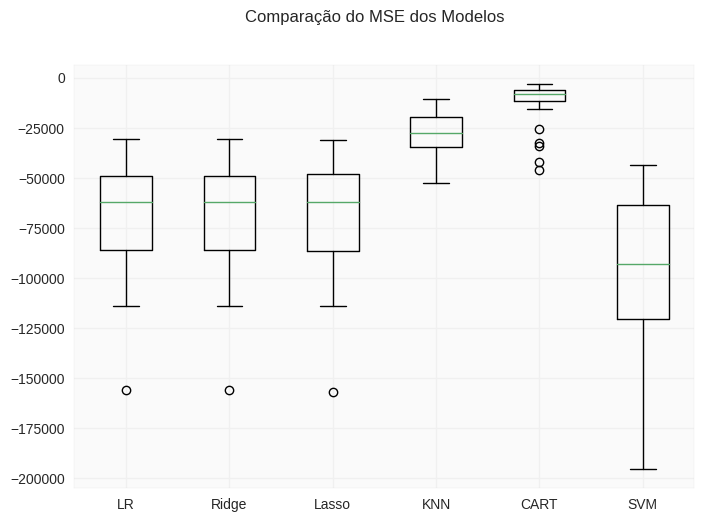

In [ ]:
# Modelagem

# Definindo uma semente global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


> Avaliando o boxplot de comparação dos valores de MSE e do RMSE (mais fácil de analisar, justamente por estar na mesma dimensão - R$/MWh - que a variável target) para cada um dos métodos de regressão elencados, observa-se que o algoritmo de Árvore de Decisão (CART) se mostra consideravelmente mais promissor que os demais para o problema de predição do Custo Marginal da Operação a partir de grandezas relevantes (Energia Natural Afluente, Energia Armazenada e Demanda Energética). Nesse caso, construiremos um novo modelo, treinado com toda a base de treino.




In [ ]:
# Criando um modelo com todo o conjunto de treino
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 7017.41
RMSE 83.77




> Quando ampliamos a avaliação do modelo de Árvore de Decisão para o conjunto de teste, observamos que o valor do RMSE permanece inferior ao dos demais métodos para o subconjunto de treino. Todavia, apesar de o modelo de Árvore de Decisão tenha se mostrado, numa primeira análise, melhor do que os demais, as métricas de erro (MSE e RMSE) ainda podem ser reduzidas. Para tal, podemos lançar mão de técnicas avançadas de Aprendizado Supervisionado, considerando a possibilidade de utilizarmos métodos "ensemble" e a seleção de features na tentativa de alcançarmos melhores predições.



# **Seção V: Técnicas Avançadas para Aprendizado Supervisionado**

## Modelagem e Inferência
O problema em voga necessita de modelos de regressão, uma vez que os resultados esperados (CMO Médio) são numéricos. Por este motivo, nesta seção buscaremos métodos ensemble voltados para problemas de Regressão. Testaremos os "mais populares": voting, bagging e boosting, com o objetivo de aprimorarmos a predição da variável target.

## Random Forest

> De acordo com a teoria da "sabedoria das multidões", as predições agregadas de um grupo de preditores tende a gerar melhores respostas do que o melhor preditor individual. Em Aprendizado Supervisionado, um dos métodos "ensemble" mais poderosos na atualidade consiste no treinamento de um grupo de decisores de uma árvore de decisão, cada um com um subconjunto aleatório diferente do conjunto de treinamento. São obtidas, então, as predições de todas as árvores individuais e, depois, a mais votada. Este agrupamento de árvores de decisão se chama "Random Forest" e será um dos métodos aplicados na próxima seção.
No Random Forest, algumas amostras dos dados de treino
(linhas do dataset) são selecionadas de maneira aleatória, sendo que as árvores criadas pelo algoritmo não conterão a totalidade dos dados utilizados na construção do modelo.



In [ ]:
# Criando um modelo com todo o conjunto de treino
model = RandomForestRegressor(min_samples_leaf=1, n_estimators=1000, random_state=0)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictionsRF = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictionsRF)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 6127.57
RMSE 78.28




> Conforme pode ser observado, aplicando-se o método da Floresta Aleatória com 1000 estimadores reduz o MSE e o RMSE em comparação ao método de Árvore de Decisão, inclusive quando estendemos a validação para o conjunto de teste. Como desdobramento, pode-se concluir, portanto, que o Random Forest está reduzindo o overfitting em comparação ao CART, visto que o erro na predição (como verificado para o subset de teste) diminui ao aplicarmos o RF.



## Histogram Gradient Boosting

Uma outra alternativa de técnica avançada de ML que pode ser aplicada, desdobrada do algoritmo de Árvore de Decisão, é o Histogram Gradient Boosting Regressor. As principais diferenças em relação ao Random Forest estão no fato de no HGBT as árvores serem treinadas sequencialmente, de forma que as árvores subsequentes corrijam os erros das anteriores. Além disso, as rodadas acontecem em uma ordem fixa e a sequência não pode ser alterada. O risco associado é que, se os dados forem muito ruidosos, as árvores no Gradient Boosting Regressor podem acabar modelando este ruído, contribuindo para o overfitting.



> A seguir, faremos uma análise alterando um dos principais hiperparâmetros do HGBT: o número máximo de iterações, mantendo a mesma profundidade máxima (5 nós). Podemos constatar que, para os valores testados, quanto maior o número máximo de iterações, menor o erro (com a desvantagem do aumento do tempo computacional, considerando um único núcleo para processamento. Este tempo pode diminuir ao utilizarmos computação paralela). Os testes serão realizados com validação cruzada, na tentativa de reduzirmos o overfitting.



In [ ]:
names2=[]
results2=[]
prediction = []
models2=[]
params_var=[]

models2.append(('HGBT_50', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 50, early_stopping=False)))
models2.append(('HGBT_100', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 100, early_stopping=False)))
models2.append(('HGBT_300', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 300, early_stopping=False)))
models2.append(('HGBT_1000', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 1000, early_stopping=False)))
models2.append(('HGBT_2000', HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 2000, early_stopping=False)))

# Avaliando um modelo por vez
for name, model in models2:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results2.append(cv_results)
    names2.append(name)
    # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
    msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
    print(msg)

HGBT_50: MSE 31067.09 (11063.33) - RMSE 176.26
HGBT_100: MSE 22804.46 (6732.87) - RMSE 151.01
HGBT_300: MSE 14602.55 (4540.96) - RMSE 120.84
HGBT_1000: MSE 9817.10 (3541.25) - RMSE 99.08
HGBT_2000: MSE 7967.21 (3056.27) - RMSE 89.26


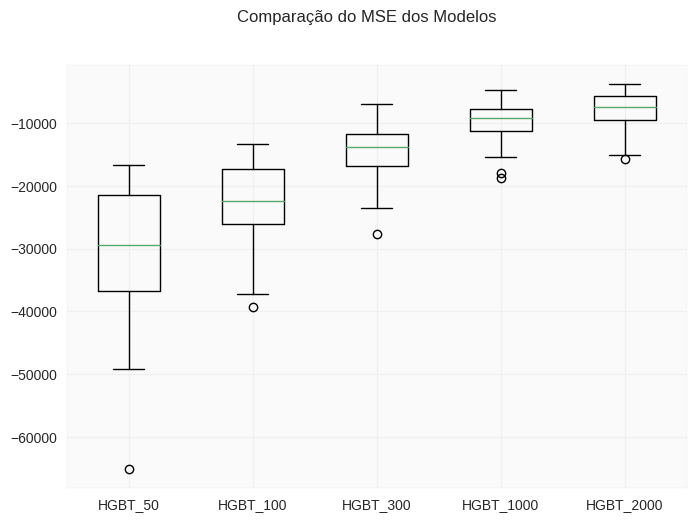

In [ ]:
# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results2)
ax.set_xticklabels(names2)
plt.show()



> Podemos observar que, para o caso analisado, a partir de um determinado número máximo de iterações a diminuição do erro passa a ser mais lenta. Vamos estender a avaliação do modelo para o dataset de teste, considerando o caso com máx_iter = 2000 iterações, sem a validação cruzada.

In [ ]:
model = HistGradientBoostingRegressor(max_leaf_nodes=5,max_iter = 2000, early_stopping=False)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictionsHGBT = model.predict(X_test)

# Estimando o MSE e o RMSE no conjunto de teste
mse = mean_squared_error(y_test, predictionsHGBT)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 9489.66
RMSE 97.41



> Como pode-se observar, para a predição considerando o conjunto de teste, o modelo apresentou RMSE maior que o do Random Forest, melhor algoritmo até o presente momento.




## Avaliação conjunta de vários métodos ensemble: Linha de Base


> Agora que fizemos uma avaliação inicial de dois importantes métodos ensemble, vamos analisar a performance (segundo os critérios MSE e RMSE) de alguns outros modelos. Serão utilizados "parâmetros equivalentes", para tentarmos chegar a uma conclusão mais robusta a respeito dos mesmos.



Bagging: MSE 6137.99 (4025.38) - RMSE 78.35
RF: MSE 6435.02 (4060.76) - RMSE 80.22
ET: MSE 3291.37 (1892.39) - RMSE 57.37
Ada: MSE 87331.42 (14978.89) - RMSE 295.52
HGBT: MSE 6375.42 (3339.03) - RMSE 79.85
GB: MSE 20360.80 (7926.70) - RMSE 142.69
Voting: MSE 24084.84 (10272.96) - RMSE 155.19


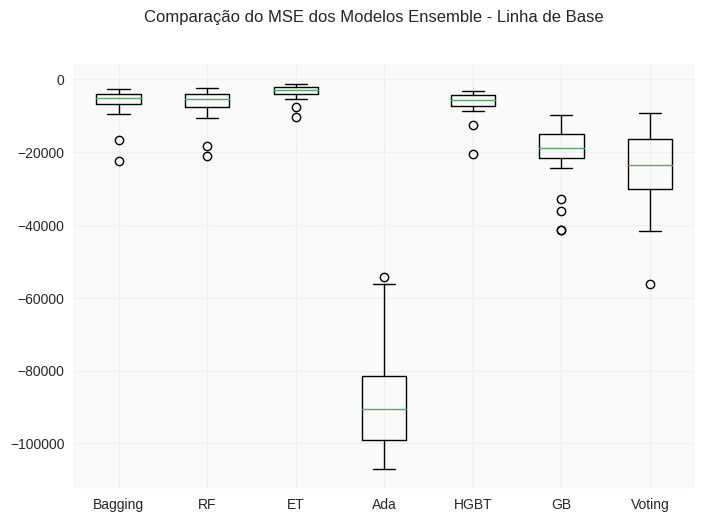

In [ ]:
np.random.seed(0) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Definindo os parâmetros para o Bagging (usaremos Árvore de Decisão)
base = DecisionTreeRegressor()
num_trees = 200
max_features = 3 # o problema original não tem muitos atributos, mas vamos, ainda assim, definir a quantidade máxima de features para a predição

# Criando os modelos para o Voting (Árvore de Decisão; Support Vector Machine e KNN)
bases = []
model1 = DecisionTreeRegressor()
bases.append(('cart', model1))
model2 = SVR()
bases.append(('svm', model2))
model3 = KNeighborsRegressor()
bases.append(('KNN', model3))

# Criando os ensembles e adicionando-os à lista de modelos
models.append(('Bagging', BaggingRegressor(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostRegressor(n_estimators=num_trees)))
models.append(('HGBT', HistGradientBoostingRegressor(max_iter=num_trees)))
models.append(('GB', GradientBoostingRegressor(n_estimators=num_trees)))
models.append(('Voting', VotingRegressor(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos Ensemble - Linha de Base')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()



> Pela avaliação da linha de base, o método de ExtraTrees (com 200 árvores), levou a erros significativamente menores que os demais (considerando o conjunto de testes). A seguir, vamos avaliar todos os modelos já elencados neste trabalho porém plotando todos no mesmo gráfico boxplot, considerando pipelines com os dados originais e também padronizados e normalizados, na tentativa de chegarmos, realmente, ao método que gere melhores erros possíveis.



## Avaliação de todos os modelos elencados: dados originais, padronizados e normalizados

LR-orig: MSE 68452.56 (28194.18) - RMSE 261.63
Ridge-orig: MSE 68452.52 (28193.48) - RMSE 261.63
Lasso-orig: MSE 68612.93 (28322.40) - RMSE 261.94
KNN-orig: MSE 28237.83 (10471.07) - RMSE 168.04
CART-orig: MSE 14342.72 (11809.26) - RMSE 119.76
SVM-orig: MSE 93527.94 (37600.25) - RMSE 305.82
Bag-orig: MSE 6272.97 (4325.76) - RMSE 79.20
RF-orig: MSE 6519.93 (4287.89) - RMSE 80.75
ET-orig: MSE 3270.75 (1874.41) - RMSE 57.19
Ada-orig: MSE 88964.24 (14630.67) - RMSE 298.27
GB-orig: MSE 20475.32 (7946.71) - RMSE 143.09
HGBT-orig: MSE 6375.42 (3339.03) - RMSE 79.85
Vot-orig: MSE 24443.46 (10347.31) - RMSE 156.34
LR-padr: MSE 68452.56 (28194.18) - RMSE 261.63
Ridge-padr: MSE 68516.04 (28316.12) - RMSE 261.76
Lasso-padr: MSE 68898.85 (28546.87) - RMSE 262.49
KNN-padr: MSE 24002.96 (10020.49) - RMSE 154.93
CART-padr: MSE 13607.67 (13066.62) - RMSE 116.65
SVM-padr: MSE 84183.72 (36678.57) - RMSE 290.14
Bag-padr: MSE 6133.68 (4065.13) - RMSE 78.32
RF-padr: MSE 6455.11 (4131.99) - RMSE 80.34
ET-pad

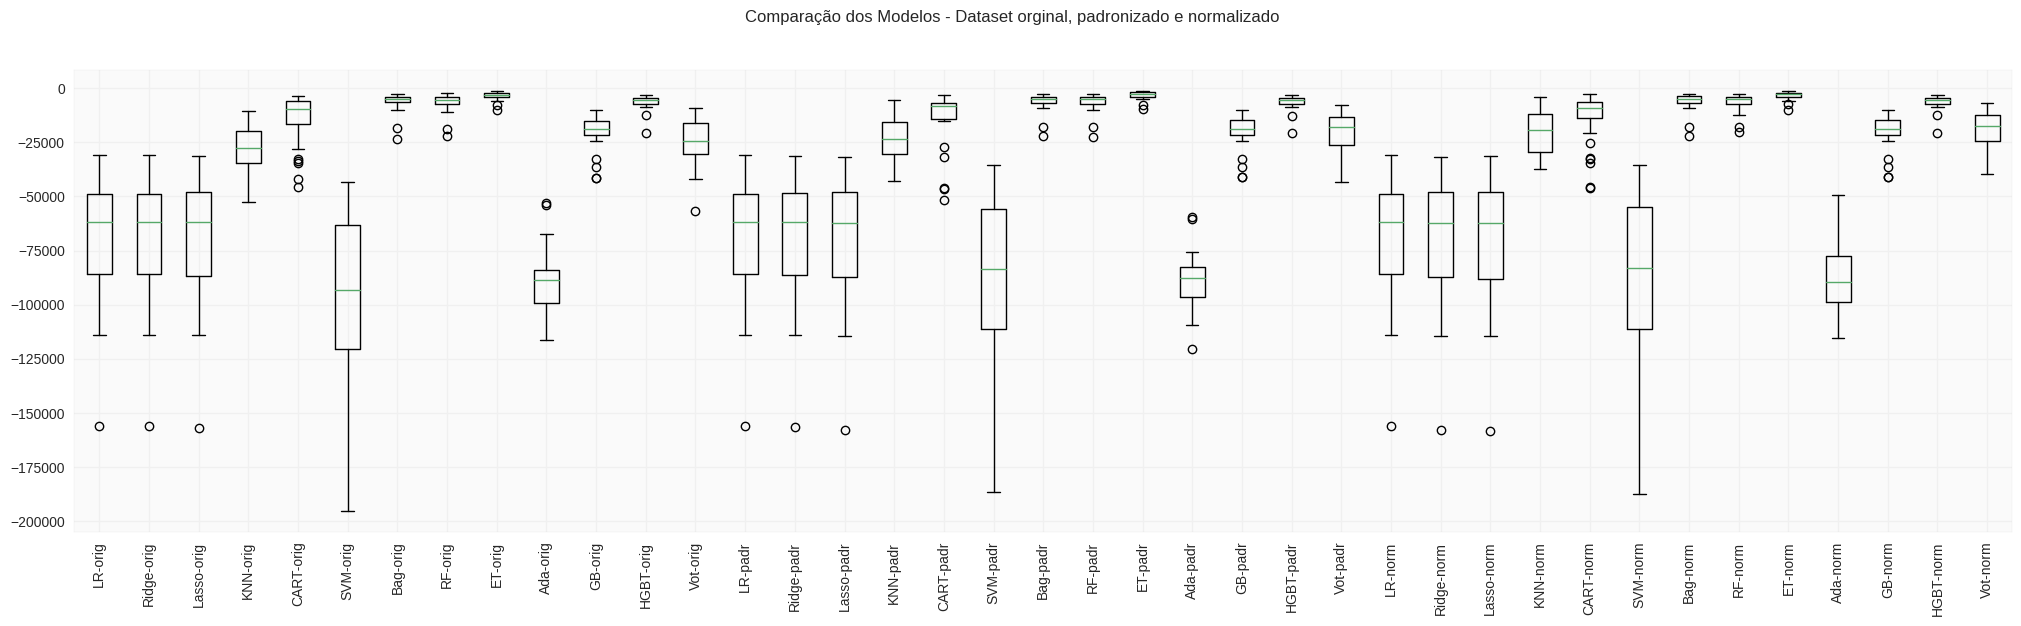

In [ ]:
np.random.seed(0) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados (todos já avaliados em etapas anteriores deste código)

reg_lin=(('LR', LinearRegression()))
ridge=(('Ridge', Ridge()))
lasso=(('Lasso', Lasso()))
knn=(('KNN', KNeighborsRegressor()))
cart=(('CART', DecisionTreeRegressor()))
svm=(('SVM', SVR()))
bagging = ('Bag', BaggingRegressor(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=num_trees))
hist_gradient_boosting = ('HGBT', HistGradientBoostingRegressor(max_iter=num_trees))
voting = ('Voting', VotingRegressor(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler()) # Padronização
min_max_scaler = ('MinMaxScaler', MinMaxScaler()) # Normalização

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_lin])))
pipelines.append(('Ridge-orig', Pipeline([ridge])))
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('HGBT-orig', Pipeline([hist_gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_lin])))
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('HGBT-padr', Pipeline([standard_scaler, hist_gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_lin])))
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler, lasso])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('HGBT-norm', Pipeline([min_max_scaler, hist_gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()



> Conforme observamos no boxplot, o método de Extremely Randomized Trees apresenta os menores erros para o dataset de treinamento, considerando tanto os dados originais, quanto os padronizados quanto os normalizados, com RMSE inferior a 60 Reais/MWh nos três casos. Os métodos Bagging (com Árvore de Decisão como base) e Random Forest, ambos com RMSE inferiores a 100 Reais/MWh, também podem ser boas alternativas para chegarmos a um modelo preditivo robusto, com baixo erro.



## Otimização de Hiperparâmetros
Considerando os resultados apresentados anteriormente, vamos avaliar o impacto de alterarmos alguns dos parâmetros dos métodos que forneceram os menores valores de RMSE pelas análises acima.

In [ ]:
# Tuning do Extremely Randomized Trees

np.random.seed(0) # definindo uma semente global para este bloco
pipelines = []

# Definindo os componentes do pipeline
extra_trees = ('ET', ExtraTreesRegressor())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('ET-orig', Pipeline(steps=[extra_trees])))
pipelines.append(('ET-padr', Pipeline(steps=[standard_scaler, extra_trees])))
pipelines.append(('ET-norm', Pipeline(steps=[min_max_scaler, extra_trees])))

# Vamos variar os parâmetros: n_estimators
param_grid = {
    'ET__n_estimators': [50, 100, 200, 400]
}

In [ ]:
# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring= 'neg_mean_squared_error', cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Avaliação do ExtraTrees: %s - Melhor RMSE: %f usando %s" % (name, np.sqrt(abs(grid.best_score_)), grid.best_params_))

KeyboardInterrupt: ignored



> Ao executarmos a validação cruzada (via GridSearch) alterando o número de estimadores do método ET, mas deixando o parâmetro de máximo número de features como o valor default (e não como 3, parâmetro utilizado nas etapas anteriores), conseguimos obter valores de RMSE ainda menores (para o subconjunto de treino), chegando à faixa dos 45 Reais/MWh, tanto para os valores originais quanto para os normalizados e para os padronizados, sem diferenças significativas entre eles (o caso com os dados originais foi o de menor erro). Ao contrário do que seria mais intuitivo, para o pipeline dos dados originais, a melhor pontuação não foi para o número maior de estimadores do grid. Por esta avaliação, portanto, escolheríamos o método ET, com o dataset de treino original, número máximo de features igual a 1 e número de estimadores = 100.



## Finalização do Modelo

In [406]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = ExtraTreesRegressor(n_estimators=2000)
model.fit(rescaledX, y_train)

# Estimativa do MSE e do RMSE no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste

# Estimando o MSE e o RMSE no conjunto de teste
predictions = model.predict(rescaledTestX)
mse = mean_squared_error(y_test, predictions)
print("MSE %0.2f" % mse)
print("RMSE %0.2f" % np.sqrt(abs(mse)))

MSE 2447.09
RMSE 49.47


In [283]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X_SE) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X_SE) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y_SE)

ExtraTreesRegressor(n_estimators=2000)

## Simulando a aplicação em dados não vistos - Subset de Validação

In [407]:
# Novos dados

print(X_val) # atributos do dataset de validação
print(y_val) # variável target (CMO Médio) dataset de validação

rescaledEntradaX = scaler.transform(X_val)
print(rescaledEntradaX)

[[26208.0 87.81 26068.0 ... 72757.0 35079.9 0]
 [32419.09 67.48 32144.81 ... 41005.15 39015.34 1]
 [42887.38 78.03 41241.11 ... 134038.83 42930.25 1]
 ...
 [23313.96 58.2 22948.36 ... 66956.13 37738.46 1]
 [22288.0 83.53 21555.0 ... 85597.0 28797.27 0]
 [99249.0 186.64 74542.0 ... 135191.0 26459.31 0]]
[472.23 56.65 6.48 ... 287.26 147.04 0.0]
[[-0.46884288 -0.28180379 -0.36683525 ... -0.76638993  0.06271606
  -0.44696605]
 [-0.12539914 -0.99533305  0.04811612 ... -1.57647992  0.93488146
   1.32131347]
 [ 0.45344752 -0.62505593  0.66925159 ...  0.79710313  1.80249703
   1.32131347]
 ...
 [-0.62886953 -1.32103652 -0.57985802 ... -0.91438845  0.65190152
   1.32131347]
 [-0.68560023 -0.43202047 -0.67500279 ... -0.43880097 -1.32962953
  -0.44696605]
 [ 3.56997706  3.18686798  2.94318316 ...  0.82649863 -1.84776418
  -0.44696605]]


In [431]:
saidas = model.predict(rescaledEntradaX)
print(len(saidas))
print(saidas)
print(y_val)
diferenca=saidas-y_val

y_val=pd.DataFrame(y_val,columns=['CMO_Validacao'])
saidas=pd.DataFrame(saidas,columns=['CMO_SaidaModelo'])
diferenca=pd.DataFrame(diferenca,columns=['Diferenca'])
arquivo=pd.concat([y_val,saidas,diferenca],axis=1)
arquivo.to_csv("arquivo2.csv",index=False,encoding ='utf-8')

1016
[4.95965125e+02 6.19793700e+01 1.11504000e+01 ... 2.72425800e+02
 2.12813070e+02 4.85005000e-01]
     CMO_Validacao
0           472.23
1            56.65
2             6.48
3            25.82
4           145.56
...            ...
1011         70.47
1012           0.0
1013        287.26
1014        147.04
1015           0.0

[1016 rows x 1 columns]


ValueError: ignored

Simulando a aplicação do modelo em dados não vistos

# **Seção VI: Conclusão**

O presente trabalho teve como objetivo a obtenção, tratamento e análise dos dados históricos de Energia Natural Afluente, Energia Armazenada, Demanda Elétrica e Custo Marginal da Operação, a partir dos dados diários por subsistema publicados pelo Operador Nacional do Sistema Elétrico. Puderam-se observar os comportamentos das referidas grandezas no período de 2005 a abril/2023, tanto ao longo do tempo, quanto em termos de distribuição (unimodal). Além disso, também foi possível avaliar as correlações entre as mesmas.

As etapas até aqui realizadas visam a, em um próximo momento, possibilitar a elaboração de algoritmos de aprendizagem de máquina no intuito de levar a predições/prescrições sobre expectativas de Custo Marginal da Operação frente a cenários futuros de ENA, EArm e Carga, considerando o histórico das mesmas e do próprio CMO.